# 1era Iteración de código

# Imports

In [21]:
# Importamos las librerías necesarias
import cv2
import numpy as np
import pandas as pd
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam

from typing import Optional, Union

# Configuración para mostrar gráficos en Jupyter
%matplotlib inline

# Carga de Datos

In [22]:
# Cargar el dataset desde un archivo CSV
dataset = pd.read_csv("dataset.csv", sep=";")

# Eliminar filas con valores nulos en la columna 'price'
dataset.dropna(subset=["price"], inplace=True)

# Eliminar columnas completamente vacías
dataset.dropna(axis=1, how="all", inplace=True)

# Mostrar las primeras filas del dataset para verificar la carga correcta
dataset.head(5)

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09


# Filtrado de Columnas y Datos

In [23]:
# Seleccionar columnas relevantes para el análisis
cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "host_is_superhost",
    "host_listings_count",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "property_type",
    "accommodates",
    "beds",
    "number_of_reviews",
    "minimum_nights",
    "maximum_nights",
    "picture_url",
    "price"
]

# Filtrar el dataset para incluir solo las columnas seleccionadas
dataset = dataset[cols]

# Eliminar filas con cualquier valor nulo en las columnas seleccionadas
dataset = dataset.dropna()
dataset.shape

(6449, 15)

# Descarga de Imágenes

In [24]:
# Función para descargar imágenes desde URLs
def download_images(paths: list, canvas: tuple = (224, 224), nb_channels: int = 3, max_imgs: Optional[int] = None) -> tuple:
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels), dtype=np.uint8)
    downloaded_idxs = []

    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            if img.ndim == 2:  # Imagen es en escala de grises
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[2] > 3:  # Imagen tiene canales alfa
                img = img[:, :, :3]  # Eliminar canal alfa
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:  # Error de URL no disponible o conversión
            print(f"Error downloading {url}: {e}")
            continue
    return images.astype("float32") / 255., downloaded_idxs

# Descargar imágenes usando la función definida
images, idxs = download_images(dataset["picture_url"])
images = images.astype("float32") / 255.
images.shape

  1%|▏         | 86/6449 [00:54<1:46:13,  1.00s/it]

Error downloading https://a0.muscache.com/pictures/c168962e-1a48-461d-a568-3ec4bf9a6c65.jpg: HTTP Error 403: Forbidden


  2%|▏         | 114/6449 [01:09<43:18,  2.44it/s]  

Error downloading https://a0.muscache.com/pictures/90646201/a9cbf501_original.jpg: HTTP Error 403: Forbidden


  3%|▎         | 163/6449 [01:33<40:04,  2.61it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-6646604/original/0f04720b-b742-4aba-b252-2be9080145e9.jpeg: HTTP Error 403: Forbidden


  3%|▎         | 201/6449 [01:45<24:57,  4.17it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-7531700/original/67306117-5e1a-46b6-b1a9-8694dc769b9c.jpeg: HTTP Error 403: Forbidden


  4%|▍         | 285/6449 [02:40<44:24,  2.31it/s]  

Error downloading https://a0.muscache.com/pictures/e3f457c4-5f1a-4151-a3c8-e53f161d57fb.jpg: HTTP Error 403: Forbidden


  5%|▍         | 310/6449 [02:54<53:05,  1.93it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-13650313/original/1713739f-5d53-45db-aa2e-611c2098615d.jpeg: HTTP Error 403: Forbidden


  5%|▌         | 328/6449 [03:01<45:09,  2.26it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-14229841/original/c611eaeb-4983-4a3c-9525-fcabb3b0fbf5.jpeg: HTTP Error 403: Forbidden


  5%|▌         | 353/6449 [03:14<27:52,  3.64it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-14976039/original/30b560e4-51f7-4f35-9b4d-343aa5074bc2.jpeg: HTTP Error 403: Forbidden


  6%|▌         | 392/6449 [03:35<1:15:49,  1.33it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-17023481/original/c66d1dcf-8cae-4a0f-b34d-e8a9da3882ab.jpeg: HTTP Error 403: Forbidden


  6%|▌         | 393/6449 [03:35<1:04:32,  1.56it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-17042710/original/0a2e4db0-4940-4a4b-b948-11bef8ec0ed5.jpeg: HTTP Error 403: Forbidden


  7%|▋         | 424/6449 [03:52<33:43,  2.98it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-18032982/original/2c71e21b-33cd-4f6a-ae22-287cdeaedfc0.jpeg: HTTP Error 403: Forbidden


  7%|▋         | 426/6449 [03:53<36:21,  2.76it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-18170647/original/d7c346d7-a904-4e8c-8356-4de5eb79c60f.jpeg: HTTP Error 403: Forbidden


 10%|▉         | 642/6449 [05:41<27:15,  3.55it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-28360335/original/c8d8cd53-ed9e-4831-ba48-a838f2ac2bcf.jpeg: HTTP Error 403: Forbidden


 10%|█         | 665/6449 [05:52<46:41,  2.06it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-29702825/original/32a037b0-43f1-4954-946b-9d1364829d04.jpeg: HTTP Error 403: Forbidden


 11%|█         | 685/6449 [06:05<50:49,  1.89it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-30390378/original/244ec1dc-2c48-4e5e-84cf-fb57110e4bc7.jpeg: HTTP Error 403: Forbidden


 11%|█         | 686/6449 [06:05<42:12,  2.28it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-30397078/original/337887d6-4c7c-4550-9f1f-5e4ee671b8f6.jpeg: HTTP Error 403: Forbidden


 11%|█         | 688/6449 [06:06<31:39,  3.03it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-30516467/original/57a80027-7bdb-4fac-a4dd-5656631425d0.jpeg: HTTP Error 403: Forbidden


 11%|█▏        | 727/6449 [06:23<25:55,  3.68it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-33439464/original/97081848-d2c3-47e1-8647-ac8af1c3f6dc.jpeg: HTTP Error 403: Forbidden


 11%|█▏        | 728/6449 [06:23<24:15,  3.93it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-33440102/original/9c6d9fa6-c962-4f7c-b69f-898bdd560ea4.jpeg: HTTP Error 403: Forbidden


 11%|█▏        | 735/6449 [06:26<35:50,  2.66it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-34133759/original/1dc53195-b06f-4fed-a860-92e1718bdccb.jpeg: HTTP Error 403: Forbidden


 12%|█▏        | 745/6449 [06:31<37:36,  2.53it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-34974052/original/80db035e-1445-4ce8-8314-e9175130884b.jpeg: HTTP Error 403: Forbidden


 12%|█▏        | 756/6449 [06:36<41:15,  2.30it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-35481543/original/38658947-e448-49ca-b0b2-607429f1b5b0.jpeg: HTTP Error 403: Forbidden


 12%|█▏        | 789/6449 [06:49<41:20,  2.28it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-37068313/original/c51bac91-f35e-4e1e-bb88-07934499bfdd.jpeg: HTTP Error 403: Forbidden


 12%|█▏        | 795/6449 [06:53<41:33,  2.27it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-37709158/original/09489cb1-f4c7-436f-a7e8-018a7079c658.jpeg: HTTP Error 403: Forbidden


 12%|█▏        | 805/6449 [06:58<34:02,  2.76it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-38178173/original/e1b494b8-9fc3-466a-8789-9d3afa032807.jpeg: HTTP Error 403: Forbidden


 13%|█▎        | 812/6449 [07:00<33:17,  2.82it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-38513768/original/43b5f7ad-a3a1-4019-993f-c5ebe3168d59.jpeg: HTTP Error 403: Forbidden


 13%|█▎        | 842/6449 [07:15<31:43,  2.95it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-39908091/original/17a09417-8eab-48b1-a21b-904f1837e84f.jpeg: HTTP Error 403: Forbidden


 13%|█▎        | 852/6449 [07:20<37:13,  2.51it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-40423797/original/374a8e77-d840-480b-ba94-51b8d7337e0c.jpeg: HTTP Error 403: Forbidden


 13%|█▎        | 862/6449 [07:23<30:23,  3.06it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-40617998/original/6c9424ed-eaca-433f-9099-a9c9782dea58.jpeg: HTTP Error 403: Forbidden


 14%|█▎        | 878/6449 [07:35<30:27,  3.05it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41102403/original/da9a9606-9604-4c01-b3ea-c1a3670b78e5.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 888/6449 [07:40<39:44,  2.33it/s]

Error downloading https://a0.muscache.com/pictures/2d4d9af2-32eb-4fdd-8ce7-f2b5bdc94853.jpg: HTTP Error 403: Forbidden


 14%|█▍        | 892/6449 [07:42<39:14,  2.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41785374/original/61a91ae7-d44c-4914-8abd-db076afedf4f.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 893/6449 [07:42<33:17,  2.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41785889/original/8f975c1d-488b-432e-81ee-cdb79c1c02aa.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 895/6449 [07:43<34:06,  2.71it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41903226/original/7a269ac9-2f1b-4602-8bdf-4ff24a9a6777.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 896/6449 [07:43<31:00,  2.98it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41925155/original/2ea402f5-82d2-4893-99cf-0d6ceca7f403.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 898/6449 [07:44<30:13,  3.06it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41953347/original/920668ea-3248-402a-a2f4-e85a90c92ca1.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 899/6449 [07:44<29:30,  3.13it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41953381/original/1dfc0495-f723-4331-8a89-4ac4d88edd0c.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 904/6449 [07:46<33:18,  2.77it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42080174/original/70a61753-d83a-4323-b5be-66365f32d0af.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42080205/original/180c0cef-eb46-4641-a6be-71872fc644ee.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 906/6449 [07:47<26:56,  3.43it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42195053/original/66a57514-4d25-4268-815b-68465adc5717.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 915/6449 [07:51<41:00,  2.25it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42708089/original/63e58680-832d-47de-b782-380659efda4c.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 916/6449 [07:51<36:01,  2.56it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42708127/original/91eae4b5-4a53-444e-bbe9-db37ae477471.jpeg: HTTP Error 403: Forbidden


 14%|█▍        | 918/6449 [07:51<26:31,  3.47it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42708174/original/250bd918-a4d8-46d0-8bc9-e9a46413ec41.jpeg: HTTP Error 403: Forbidden


 15%|█▍        | 937/6449 [07:57<30:45,  2.99it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43032465/original/28381099-f671-4471-8727-9e8084e47d4f.jpeg: HTTP Error 403: Forbidden


 15%|█▍        | 938/6449 [07:58<30:48,  2.98it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43032495/original/58abc83b-2b8c-4176-9d7c-5bf91b42c49f.jpeg: HTTP Error 403: Forbidden


 15%|█▍        | 943/6449 [07:59<33:04,  2.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43121210/original/5f99a7da-d07c-43a4-8e67-92a31abe9695.jpeg: HTTP Error 403: Forbidden


 15%|█▍        | 949/6449 [08:01<23:24,  3.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43301136/original/373cca92-f25a-4d44-a5cb-c2e3c253e2d3.jpeg: HTTP Error 403: Forbidden


 15%|█▍        | 962/6449 [08:05<29:45,  3.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43921666/original/ff08f5f6-d1dd-435e-af2e-c7917dfcdc7d.jpeg: HTTP Error 403: Forbidden


 15%|█▍        | 965/6449 [08:06<29:32,  3.09it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44053258/original/48655a82-a536-465e-925a-b901943762e2.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 969/6449 [08:07<28:56,  3.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44242670/original/4b69e1a9-8664-4b90-a9f9-cd0a966df453.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 975/6449 [08:10<36:45,  2.48it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44776954/original/e20fbcfe-fd7e-48a4-9237-71d69f4d207f.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 976/6449 [08:10<33:04,  2.76it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44776967/original/22009d99-ee7d-44ee-b6a5-e3d47e1dbf8a.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 979/6449 [08:11<31:17,  2.91it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-45031773/original/786af0d4-0eb3-4608-a4a3-895bc73c8fc7.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 981/6449 [08:12<34:11,  2.67it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45095953/original/e530a1ff-ca52-4a5e-a210-2536b4d4678a.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 982/6449 [08:13<30:14,  3.01it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45096003/original/0c468432-5000-4423-97b2-5afda54e34f8.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 983/6449 [08:13<27:21,  3.33it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45096017/original/552d794b-b07e-4a21-a7b4-4e513fc2e6b9.jpeg: HTTP Error 403: Forbidden


 15%|█▌        | 995/6449 [08:20<33:05,  2.75it/s]  

Error downloading https://a0.muscache.com/pictures/246931ce-1d84-484a-bde7-4ee607f5d48e.jpg: HTTP Error 403: Forbidden


 15%|█▌        | 996/6449 [08:20<30:36,  2.97it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45443503/original/72ca2b6e-9420-4c81-856d-f3c4ec4cb6f8.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1001/6449 [08:23<36:55,  2.46it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-45501019/original/de13720d-7458-4897-b812-10c014117d01.png: HTTP Error 403: Forbidden


 16%|█▌        | 1007/6449 [08:26<42:01,  2.16it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45539765/original/6ae8c686-fc70-4705-afc5-ef9177681289.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1014/6449 [08:31<1:14:54,  1.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45679998/original/2189dde9-1660-43fd-9f83-6b3b5cd0eec3.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1015/6449 [08:31<59:24,  1.52it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45680010/original/c72ecce3-1fb0-4918-b50f-06df412d1f31.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1016/6449 [08:31<48:49,  1.85it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45680018/original/a60994d1-69e5-4aa8-adfb-e5a05ffeec5c.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1017/6449 [08:32<42:47,  2.12it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45680039/original/ddeaafff-825d-41b2-ae9e-f6f620020533.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1018/6449 [08:32<39:51,  2.27it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689038/original/c43dfacc-5def-4e24-a109-ad5de07a2f87.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1019/6449 [08:32<34:14,  2.64it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689053/original/5e267cf5-62f5-48ce-9f0d-aa460713e441.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1020/6449 [08:33<30:41,  2.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689060/original/51ab7ef4-cd4b-4133-96a9-88a0f4f6b238.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1021/6449 [08:33<28:36,  3.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689110/original/cf17e677-1be1-4046-9336-3d2e0d465310.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1028/6449 [08:37<50:52,  1.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45999950/original/ea2aeb8d-fbb5-4e6a-9dd2-4e1dac7ef52f.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1029/6449 [08:38<43:48,  2.06it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46000223/original/27fd39ae-6eab-4143-bd24-d81504173816.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1031/6449 [08:38<36:33,  2.47it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46074220/original/8d519bd3-3811-48ab-81e8-eff68799db92.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1032/6449 [08:39<31:44,  2.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46074729/original/3ef2e84a-aafe-4f1e-b346-99ecf6f1f5f2.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1033/6449 [08:39<29:14,  3.09it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46074742/original/5748e678-10d5-401b-af05-df788934f705.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1034/6449 [08:39<27:10,  3.32it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46085675/original/1d4604ad-47a4-4c9c-b844-40acd434fb3f.jpeg: HTTP Error 403: Forbidden


 16%|█▌        | 1038/6449 [08:44<1:16:31,  1.18it/s]

Error downloading https://a0.muscache.com/pictures/56a7aa37-27a0-4247-ae7e-221ee644f389.jpg: HTTP Error 403: Forbidden


 16%|█▌        | 1044/6449 [08:47<40:03,  2.25it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46445272/original/bdf6198d-01b9-4988-a99a-231d4e53782d.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1048/6449 [08:48<35:57,  2.50it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46576175/original/653c8eb1-d0fd-4d68-8e88-5b4898d32d98.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1050/6449 [08:49<34:54,  2.58it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46602042/original/8a77cfa9-d271-4e7d-a98f-03d1c8abbd8b.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1051/6449 [08:50<33:41,  2.67it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-46696466/original/0ea7e189-c6df-4717-b1e4-2a5d32d01fa1.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1052/6449 [08:50<30:30,  2.95it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-46697368/original/7c297348-caf3-4d1e-8d70-41b1ad9b86e7.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1053/6449 [08:50<28:14,  3.18it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46730228/original/b49d9f80-2bbc-42ad-aef8-dcc9d4ad8c6d.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1054/6449 [08:50<26:32,  3.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46791068/original/85efb204-1093-4e95-983c-00f405dd6f4c.jpeg: HTTP Error 403: Forbidden


 16%|█▋        | 1055/6449 [08:51<25:37,  3.51it/s]

Error downloading https://a0.muscache.com/pictures/28f70459-7ac9-43bf-b2ca-740d5cbc70db.jpg: HTTP Error 403: Forbidden


 17%|█▋        | 1093/6449 [09:20<36:49,  2.42it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-47576607/original/2a8842a4-c900-4cd9-97de-2617a41b028a.jpeg: HTTP Error 403: Forbidden


 17%|█▋        | 1112/6449 [09:32<48:16,  1.84it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48103622/original/6ccbbd9d-4601-45ea-b07f-b16358373780.jpeg: HTTP Error 403: Forbidden


 17%|█▋        | 1113/6449 [09:32<40:07,  2.22it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48103833/original/313c9151-af54-4716-bffe-4d8a243bfd7d.jpeg: HTTP Error 403: Forbidden


 17%|█▋        | 1114/6449 [09:32<35:03,  2.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48107926/original/d9749ddd-ea24-451e-97c7-8eea156138f3.jpeg: HTTP Error 403: Forbidden


 17%|█▋        | 1115/6449 [09:33<31:45,  2.80it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48107968/original/956795d8-27ef-4f54-8cca-ebfea3a6a425.jpeg: HTTP Error 403: Forbidden


 17%|█▋        | 1122/6449 [09:35<28:15,  3.14it/s]

Error downloading https://a0.muscache.com/pictures/153d5cfa-95d5-4eb4-b45a-1809ff9f1c71.jpg: HTTP Error 403: Forbidden


 17%|█▋        | 1127/6449 [09:38<38:16,  2.32it/s]

Error downloading https://a0.muscache.com/pictures/a5239f12-41bd-4ff2-81bb-4100667e064c.jpg: HTTP Error 403: Forbidden


 18%|█▊        | 1135/6449 [09:40<21:24,  4.14it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48454886/original/17df10d9-f416-40a3-9d77-48eba91ff839.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1139/6449 [09:42<39:36,  2.23it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597887/original/0df41515-85cb-40ca-9102-2c905c77914d.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1140/6449 [09:43<34:03,  2.60it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597894/original/9f1c5a32-2af5-4f0b-a247-413ff0972236.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1141/6449 [09:43<30:01,  2.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597943/original/894b0ae3-272d-46c7-836d-c1ffa371739f.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1142/6449 [09:43<27:40,  3.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597948/original/1447b820-5387-49bf-b1ae-f5eba0cced49.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1143/6449 [09:43<24:58,  3.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597957/original/43aa468b-dd06-456f-9e76-6e83810753b0.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1167/6449 [09:56<27:19,  3.22it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48881055/original/f34c9c5f-4f9e-45a8-a30e-d0e054c8a4fa.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1171/6449 [09:59<1:03:48,  1.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48926365/original/a6b00f63-f34c-4149-a419-168c4987fa0a.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1172/6449 [09:59<51:13,  1.72it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48926392/original/8654b984-8f04-45ab-ae71-591a3f5f5c2b.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1173/6449 [10:00<42:48,  2.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48926432/original/a61e4238-cac8-4486-b0cb-4d5dbf1f79e1.jpeg: HTTP Error 403: Forbidden


 18%|█▊        | 1193/6449 [10:08<36:44,  2.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188782/original/99f5948f-8279-420c-bf20-2dec587a0545.jpeg: HTTP Error 403: Forbidden


 19%|█▊        | 1194/6449 [10:08<34:36,  2.53it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188871/original/72a83436-de2e-4952-a029-47af95fe4509.jpeg: HTTP Error 403: Forbidden


 19%|█▊        | 1195/6449 [10:08<31:45,  2.76it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188886/original/e2be830b-675b-410d-9880-1a6c94df52bf.jpeg: HTTP Error 403: Forbidden


 19%|█▊        | 1196/6449 [10:09<29:47,  2.94it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188948/original/9b76d76e-afdc-42ff-be88-58d40a4b170b.jpeg: HTTP Error 403: Forbidden


 19%|█▊        | 1198/6449 [10:09<29:00,  3.02it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49201633/original/1c4c3312-2fe4-449a-bef7-80739db2cd29.jpeg: HTTP Error 403: Forbidden


 19%|█▊        | 1202/6449 [10:10<23:18,  3.75it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49341416/original/daf693f1-9f0b-4cc3-8cff-9e743424db9a.jpeg: HTTP Error 403: Forbidden


 19%|█▊        | 1205/6449 [10:12<33:53,  2.58it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49459007/original/0558fbae-15ab-4c6b-b91d-266fa8918ce6.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1216/6449 [10:16<34:34,  2.52it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49610522/original/1bf4855c-6543-48ae-bf14-e26f160dbf01.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1217/6449 [10:16<31:18,  2.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49610778/original/d9163a9b-d195-4bd3-ab08-a40e8351411e.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1223/6449 [10:19<37:58,  2.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49752414/original/f81334c9-8612-4c66-b08b-577430dc07c6.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1224/6449 [10:19<32:53,  2.65it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49800523/original/63fe1365-f4ee-4295-8cf2-e16f225955eb.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1228/6449 [10:21<42:08,  2.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49916971/original/f468740d-273a-4f68-ab34-abf7ae2125f1.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1229/6449 [10:22<36:16,  2.40it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49916983/original/d990404d-9367-42d8-9fce-f5ee52ec0310.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1230/6449 [10:22<31:22,  2.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49918081/original/d09c0701-338b-4fad-ab86-3843a6aa77e1.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1239/6449 [10:25<24:00,  3.62it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50017083/original/0220a02b-87a1-4434-9134-67970feb377c.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1241/6449 [10:25<21:32,  4.03it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50017182/original/945f194f-f893-4935-aa5c-08281a189922.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1243/6449 [10:26<27:49,  3.12it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50042062/original/5695dab1-486a-49c6-869c-f122a569cb66.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1246/6449 [10:27<29:40,  2.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50079025/original/09e0771a-9089-4b04-98f4-c694881868e0.jpeg: HTTP Error 403: Forbidden


 19%|█▉        | 1249/6449 [10:28<28:28,  3.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50084542/original/c5e7b728-d2db-4021-8367-c12770be703f.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1265/6449 [10:35<29:36,  2.92it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50386523/original/9445af86-b60f-4298-8a3c-ad67d8e211de.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1267/6449 [10:35<24:06,  3.58it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50386543/original/1cff2a6d-7883-48a9-ac73-c9919818e888.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1273/6449 [10:39<38:16,  2.25it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50562977/original/af9f1ab1-ee6b-4773-ad8e-1d1a8a854f0b.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1274/6449 [10:39<35:47,  2.41it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50563099/original/6a3bcfe3-357e-49f1-8e5e-61c95e5fe335.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1276/6449 [10:39<26:14,  3.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50563127/original/07348b62-4fb4-4a0e-a588-ebb46bcf2195.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1277/6449 [10:40<27:25,  3.14it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50608389/original/ccda248e-99a6-4960-9344-085550adf82c.jpeg: HTTP Error 403: Forbidden


 20%|█▉        | 1278/6449 [10:40<26:00,  3.31it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50608396/original/9d78b34a-cbb6-449a-b4d8-240dcb9d05b0.jpeg: HTTP Error 403: Forbidden


 20%|██        | 1305/6449 [10:55<42:23,  2.02it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51274775/original/599d0e88-2319-4fd1-a2c8-f57589e00ce8.jpeg: HTTP Error 403: Forbidden


 20%|██        | 1306/6449 [10:55<35:52,  2.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51274818/original/b362c342-f952-4104-ae93-178c82eec2b0.jpeg: HTTP Error 403: Forbidden


 20%|██        | 1309/6449 [10:56<27:57,  3.06it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51300156/original/5c19dc35-5cc9-46c2-a33c-0b468a5f204f.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1326/6449 [11:05<55:49,  1.53it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572681/original/f07bf279-db7c-4160-8d84-88fe466096b9.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1327/6449 [11:06<46:32,  1.83it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572775/original/eeb5b893-08c2-4f88-8153-308efa95c258.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1328/6449 [11:06<38:43,  2.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572785/original/15ccce9c-36b1-47d4-bb41-7bd1445943d5.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1329/6449 [11:06<33:36,  2.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572791/original/69db5550-a4db-4ce5-96b6-f9350277a516.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1331/6449 [11:07<26:39,  3.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51573185/original/1f184ccb-4077-4f7f-b74c-76a49a60860d.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1332/6449 [11:07<27:14,  3.13it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-51626666/original/0a3d7139-082e-4c22-a21c-519cefbdd9f2.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1333/6449 [11:07<25:10,  3.39it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-51639653/original/7b511a90-694e-44d5-a188-9566a3ceb375.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1339/6449 [11:13<58:23,  1.46it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51721946/original/94235a1f-8224-4aca-abaa-ae80e5976ae1.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1340/6449 [11:13<55:18,  1.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51722040/original/50fdf6b2-723f-4073-b395-41dc78e17cef.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1347/6449 [11:15<25:23,  3.35it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51810948/original/75535867-2424-4b40-b65f-4f77111bd3c1.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1349/6449 [11:16<21:10,  4.01it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51812329/original/483ba6af-a53f-489f-aab1-2a665512ec03.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1353/6449 [11:17<17:47,  4.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51838132/original/ed885fd6-cf96-406a-8ec9-ba48e511ec91.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1355/6449 [11:17<24:55,  3.41it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51872976/original/f4d017b0-bed3-4eca-a4b4-f5bb74938378.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1359/6449 [11:22<1:18:38,  1.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52046024/original/bd9db217-1a37-473c-9d04-c22554b514fe.jpeg: HTTP Error 403: Forbidden


 21%|██        | 1369/6449 [11:29<1:00:46,  1.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52124041/original/6807a140-6ca6-463a-8329-94c9c0d44551.jpeg: HTTP Error 403: Forbidden


 21%|██▏       | 1371/6449 [11:30<49:25,  1.71it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52249525/original/3a448371-fca1-436c-9cc9-f81c833761c7.jpeg: HTTP Error 403: Forbidden


 21%|██▏       | 1374/6449 [11:32<53:59,  1.57it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52312207/original/d0d8cfa3-d106-4980-9715-3569462eb2ab.jpeg: HTTP Error 403: Forbidden


 21%|██▏       | 1375/6449 [11:33<44:06,  1.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52358493/original/7bce9df4-aacf-497e-af49-13106d0e6432.jpeg: HTTP Error 403: Forbidden


 21%|██▏       | 1376/6449 [11:33<41:18,  2.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52358553/original/f9592681-544c-419b-8dbf-305c284f5d18.jpeg: HTTP Error 403: Forbidden


 21%|██▏       | 1377/6449 [11:33<35:24,  2.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52360274/original/511853f7-19d1-462b-998b-e25771b2b21c.jpeg: HTTP Error 403: Forbidden


 21%|██▏       | 1380/6449 [11:35<34:00,  2.48it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52376819/original/880d41b6-c749-44d7-a169-87ccd55b50eb.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1399/6449 [11:45<35:01,  2.40it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52630071/original/18d18a46-3286-4197-be11-60ac7b5baba4.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1407/6449 [11:49<32:11,  2.61it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52680602/original/1d79caaf-8a57-48b2-8d3e-dabbd5b1d75d.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1408/6449 [11:49<28:21,  2.96it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52680751/original/6348b0ed-c12a-4c0f-bdbe-fa44b8f9897d.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1410/6449 [11:50<24:51,  3.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52681618/original/321ebf00-4c2c-4471-8a59-6c11e001d6a9.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1411/6449 [11:50<24:49,  3.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52682307/original/da6a3fe1-6dd1-4e9e-9e3f-2a1a0ee88b12.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1413/6449 [11:50<22:08,  3.79it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52747167/original/981d3c46-4544-4edf-80c3-01e17abb0942.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1422/6449 [11:55<34:49,  2.41it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52891675/original/d3f6e9e8-421f-4589-b06e-f6be60c8fc10.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52891687/original/48fee597-262d-410c-b972-58665f70f713.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1426/6449 [11:57<28:11,  2.97it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52922842/original/8d76fa38-ee2d-4b41-a9f1-16d45c88fb98.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1427/6449 [11:57<25:48,  3.24it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52928607/original/8a9071c4-1c9e-4d78-8ebc-cee19cb71212.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1430/6449 [11:58<22:48,  3.67it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53026499/original/fe966eed-eb34-46eb-925c-56eac2b6583d.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53026691/original/3a060fb9-690a-4753-b88d-dd813b359c65.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1432/6449 [11:58<20:53,  4.00it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53026920/original/2da62353-bc6b-470e-8a9a-66e90a75acaf.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1433/6449 [11:58<20:18,  4.11it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53027109/original/d5272567-0970-4654-9850-67dcf4ceb4e7.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1434/6449 [11:59<21:04,  3.97it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53027280/original/978d5cf7-184a-4cc3-8825-c8ad4808f916.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1435/6449 [11:59<21:31,  3.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53027387/original/175d1bfa-b960-4dc0-897c-da50c7e87af8.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1436/6449 [11:59<21:46,  3.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53030044/original/bc548525-e3d7-4ec3-9d25-2a856b21d70c.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1437/6449 [11:59<21:01,  3.97it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53056956/original/cac4b366-899a-4716-82ce-7d7f5f44a48e.jpeg: HTTP Error 403: Forbidden


 22%|██▏       | 1451/6449 [12:04<20:38,  4.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53179806/original/29613086-755a-4778-9467-67d8cb915c89.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1462/6449 [12:09<43:04,  1.93it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53307896/original/bdfcb0d8-ae48-425d-84de-f68417c99b15.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1463/6449 [12:09<35:47,  2.32it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53307955/original/3d10cd62-2f28-4aa2-81aa-f9d19696a03d.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1464/6449 [12:09<32:52,  2.53it/s]

Error downloading https://a0.muscache.com/pictures/cc9e1538-7ac2-47c5-8322-32db49b813d4.jpg: HTTP Error 403: Forbidden


 23%|██▎       | 1471/6449 [12:12<42:01,  1.97it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53428804/original/be2eaed8-9b31-480d-98f8-101ab09463ab.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1473/6449 [12:13<28:32,  2.91it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53462366/original/a68d8ef5-de1b-4d65-ab7e-d75ab3e67424.png: HTTP Error 403: Forbidden


 23%|██▎       | 1474/6449 [12:13<24:53,  3.33it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53471426/original/8750208e-5400-4932-884d-2eb7dfa8f9c6.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1480/6449 [12:16<31:55,  2.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53541620/original/c6b2db9a-1876-4696-a6cf-c7834a870d8c.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1490/6449 [12:19<18:40,  4.43it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53699018/original/076e7f99-177e-493c-ae50-a794a4982e11.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1492/6449 [12:19<19:23,  4.26it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53733454/original/53c3e939-e6e9-4de7-914d-beeda824a1fb.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1493/6449 [12:19<19:15,  4.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53733834/original/9d1d0196-1355-4f35-83b7-199ff53c0ad5.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1505/6449 [12:22<17:01,  4.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53873611/original/998d36d4-f555-4788-9462-2192ace76dd0.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1509/6449 [12:24<24:01,  3.43it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53914758/original/af469d69-e8a1-4057-965f-a4d116169619.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1510/6449 [12:24<24:00,  3.43it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53932819/original/a7cca99b-89c4-4878-93a4-1f5c99a3d05e.jpeg: HTTP Error 403: Forbidden


 23%|██▎       | 1511/6449 [12:24<25:37,  3.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53964554/original/751cf211-2da2-4cc2-9716-1527e6da595f.jpeg: HTTP Error 403: Forbidden


 24%|██▎       | 1516/6449 [12:26<18:35,  4.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-54047272/original/f4eb3cfa-21c1-4a69-ab4e-4d2d4d592621.jpeg: HTTP Error 403: Forbidden


 24%|██▎       | 1518/6449 [12:27<32:54,  2.50it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-54159081/original/921d1884-5d26-422d-b5ad-175589408d8d.jpeg: HTTP Error 403: Forbidden


 24%|██▎       | 1520/6449 [12:27<23:28,  3.50it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-54159310/original/779d8c2e-401f-4316-9921-215e22c36edc.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1540/6449 [12:34<20:50,  3.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-542466980559114057/original/f63c7a91-1d1b-4785-80dc-73df231518d9.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1541/6449 [12:34<19:25,  4.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-543436362799833668/original/73dc4fed-1ceb-4076-97a7-a38fa0b5b98f.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1542/6449 [12:34<19:33,  4.18it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-544684082770820787/original/ade61381-22d6-49d3-b706-e142ba879680.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1544/6449 [12:34<17:58,  4.55it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-544686606795535057/original/3a436f2a-4093-4dee-8b13-a6ed9ea64e1a.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1553/6449 [12:43<1:18:26,  1.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-549048342007595380/original/236ff7f9-c853-47ad-93ba-4fc9b2c4994b.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1554/6449 [12:43<1:01:20,  1.33it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-549055903062655337/original/0f70b22e-4a22-4e2a-a7b7-e7d478866f40.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1556/6449 [12:43<38:42,  2.11it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-549058407111290129/original/5179f9aa-f925-41b9-8397-4b35ae9c6ca3.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1560/6449 [12:44<23:56,  3.40it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-553449835647049763/original/be8b6826-9ebe-4a1e-8414-3258e830ce73.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-553450125818531583/original/4b84b104-856c-4180-9344-1df6afc63ee6.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1573/6449 [12:53<51:51,  1.57it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557094168867486125/original/b3d82f92-608f-4da1-b06b-dc6949852f8f.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1574/6449 [12:54<41:40,  1.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557094454595424536/original/295861bf-5054-4abd-b752-ad6949ac387b.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1575/6449 [12:54<36:42,  2.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557861915611213552/original/49369359-68c9-42fd-8ee8-c69b2920c2d1.jpeg: HTTP Error 403: Forbidden


 24%|██▍       | 1576/6449 [12:54<31:57,  2.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557862346669301479/original/b489cbb8-4ade-4edd-9b52-a5a6f5d27344.jpeg: HTTP Error 403: Forbidden


 25%|██▍       | 1584/6449 [12:56<24:02,  3.37it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-562909674759088729/original/1bc9d504-3972-4b52-9ae7-5363a05b6d13.jpeg: HTTP Error 403: Forbidden


 25%|██▍       | 1588/6449 [12:59<38:01,  2.13it/s]

Error downloading https://a0.muscache.com/pictures/57c74e3b-4199-48e7-be0e-fa8b25672c2a.jpg: HTTP Error 403: Forbidden


 25%|██▍       | 1589/6449 [12:59<33:06,  2.45it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-567263377944351900/original/84e7bbe3-615f-474b-a4e4-33a68b0346c1.jpeg: HTTP Error 403: Forbidden


 25%|██▍       | 1590/6449 [12:59<32:01,  2.53it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-568692279938660404/original/14e8826d-5df9-4084-ae4c-5e1db70706aa.jpeg: HTTP Error 403: Forbidden


 25%|██▍       | 1591/6449 [12:59<27:21,  2.96it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-568694788908431933/original/a82a3209-09fa-462a-ad8c-b9d984e82ac3.jpeg: HTTP Error 403: Forbidden


 25%|██▍       | 1593/6449 [13:00<23:16,  3.48it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-569407505309687319/original/233707bb-ef6a-4ea7-a44a-deace00a3418.jpeg: HTTP Error 403: Forbidden


 25%|██▍       | 1599/6449 [13:02<20:46,  3.89it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-573072034648033150/original/27e6a227-5af6-40ed-ba4d-f24fadf97f0f.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1614/6449 [13:09<26:43,  3.02it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-578114881460921853/original/8bf3248c-bff6-452a-93a5-52490d002909.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1615/6449 [13:09<23:48,  3.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-578117391619038483/original/e7cf9e88-f212-4cb5-b0b4-6773c8bd5c91.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1618/6449 [13:10<23:34,  3.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-578829581723459472/original/155e748b-66a5-43f2-a469-174a1e38b3ea.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1628/6449 [13:13<21:48,  3.68it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-579562467128239369/original/63b6a232-7682-4846-91bf-93d1ea32843f.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580336513335041407/original/7f3d580f-714a-42aa-825c-acd981deb23d.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1629/6449 [13:14<20:17,  3.96it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580339548657084895/original/ed78c4a6-4e31-4c8e-afcd-8b8182c50ff9.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1630/6449 [13:14<19:45,  4.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580340188480812217/original/1197adce-808f-47f0-bb65-6da038ac04d5.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1631/6449 [13:14<19:16,  4.17it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580342069798808551/original/0386eaae-0b67-4c96-b2cc-ebadd9e96fb8.jpeg: HTTP Error 403: Forbidden


 25%|██▌       | 1632/6449 [13:14<19:47,  4.06it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580442259470637184/original/642c2f0a-d10e-402b-95b1-0de7bf419fa8.png: HTTP Error 403: Forbidden


 25%|██▌       | 1634/6449 [13:15<19:02,  4.22it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-580524519215857438/original/6e6c5925-10dd-4ea2-9208-b36ab63af73d.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1647/6449 [13:19<29:56,  2.67it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-584818002913089374/original/72c64e24-afb7-4e9b-a83f-bf62039debe4.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1650/6449 [13:21<35:59,  2.22it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-585228758807996843/original/09539fa6-9ab4-4732-bcd0-0c40e12d9d8a.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1657/6449 [13:24<33:51,  2.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-592635565577244428/original/579ac205-ac53-4470-b279-5a9008a77a5b.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1659/6449 [13:26<48:53,  1.63it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-594797282646385297/original/22cb397b-e85f-43b2-81e7-37a84578bf3e.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1667/6449 [13:30<33:35,  2.37it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-598404279154016952/original/34b62598-91cc-40d5-80ee-6bc805c9f2b5.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1675/6449 [13:34<24:15,  3.28it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604223920210757772/original/b73033c1-cd42-4e00-b0ed-a09b5f498c14.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1676/6449 [13:34<21:54,  3.63it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604231971121077035/original/8a842a04-da7b-4a52-8559-4c90a446bd1c.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1677/6449 [13:34<20:50,  3.82it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604232269991905294/original/a22778dc-61b7-4e16-a3c8-9792503504ff.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1680/6449 [13:35<18:52,  4.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604234472085817955/original/761a51e0-aba1-4fc4-a11a-d457b5375822.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1682/6449 [13:35<16:47,  4.73it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604951714437257587/original/767f84ef-275a-4d26-a3d9-65ab3b258c27.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1685/6449 [13:36<16:02,  4.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-608359192793639653/original/c3e76481-b618-4948-af0b-4b71727b1201.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-608359496810075683/original/eadf3fdf-0d24-4922-b7c3-3fa533b1a24a.jpeg: HTTP Error 403: Forbidden


 26%|██▌       | 1686/6449 [13:36<16:45,  4.74it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-608658771570500261/original/4f9287ef-9726-49bd-afd7-1261614c2e23.jpeg: HTTP Error 403: Forbidden


 26%|██▋       | 1708/6449 [13:48<53:37,  1.47it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-619253446291935967/original/6c8e77a8-3db8-4644-a736-8d137bf3d00a.jpeg: HTTP Error 403: Forbidden


 27%|██▋       | 1712/6449 [13:51<44:04,  1.79it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-620726386166322193/original/4ef78345-dfe4-4e20-bc50-f5f846db8dbe.jpeg: HTTP Error 403: Forbidden


 27%|██▋       | 1718/6449 [13:53<27:36,  2.86it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-622413306658128240/original/0a864c78-21a8-412e-b679-c11b68b3eda6.jpeg: HTTP Error 403: Forbidden


 27%|██▋       | 1720/6449 [13:53<28:59,  2.72it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-623029409486034434/original/c291ac87-a95e-4baa-9831-8b80607ea8fa.jpeg: HTTP Error 403: Forbidden


 27%|██▋       | 1724/6449 [13:56<42:40,  1.85it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-623619726219332946/original/14609c8d-a85d-4929-b395-b1f673d19062.jpeg: HTTP Error 403: Forbidden


 27%|██▋       | 1739/6449 [14:01<17:24,  4.51it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-633058908634454665/original/d584f0b2-3d14-4263-b200-b4a159ee0bb4.jpeg: HTTP Error 403: Forbidden


 27%|██▋       | 1745/6449 [14:03<19:40,  3.98it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-634543701606720546/original/6b2b925e-f7ec-400e-8ae5-f9d1696971af.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1786/6449 [14:19<20:57,  3.71it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-655514870814006563/original/724771b1-5a01-4fdd-909c-e7d727a7bd81.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1787/6449 [14:19<20:04,  3.87it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-655515158683197472/original/4b649a39-4db9-4bb2-bff6-5a4bdc248087.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1789/6449 [14:19<17:30,  4.44it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-655515533603303924/original/81017bdd-993a-47c5-9221-58cd085f4a6c.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1794/6449 [14:20<18:52,  4.11it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-658713146354442625/original/43d951e7-f273-4e91-970d-d02965c399e3.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1797/6449 [14:23<41:32,  1.87it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-659156386290642679/original/a5625cb5-579d-496f-9ccb-25b8f722b917.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1812/6449 [14:31<37:24,  2.07it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-666383993088270320/original/143267b2-34a1-4129-91e7-cfbf5ffd99f2.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1821/6449 [14:33<16:16,  4.74it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-670105594005404482/original/c1ffef6e-0359-4048-bbe6-229ca2fb8cd4.jpeg: HTTP Error 403: Forbidden


 28%|██▊       | 1836/6449 [14:41<45:08,  1.70it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-674344475189896557/original/0f94223f-171b-4a36-a250-df3e83b79b73.jpeg: HTTP Error 403: Forbidden


 29%|██▊       | 1840/6449 [14:42<28:05,  2.73it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-676483872976026157/original/95466906-23db-48dc-9947-d752a219a166.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1855/6449 [14:48<23:18,  3.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-683768558849092912/original/ecfe8989-8d18-4c1b-8c30-cb601c156236.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1869/6449 [14:52<16:12,  4.71it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-686659102449877793/original/3480e3f2-af15-463e-a8ed-403fe2efbbf1.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1876/6449 [14:53<14:13,  5.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-688910480628831655/original/7eb3e919-d4d4-4fea-85c6-299d855bb99c.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1878/6449 [14:54<25:50,  2.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-689607534898158572/original/860e07b2-0022-4a83-a3cb-c651897ae6fd.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1885/6449 [14:57<31:21,  2.43it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-690400586934454556/original/eca7926b-53b1-47b7-9e3e-d9f75a03f565.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1886/6449 [14:58<27:20,  2.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-690400874919227004/original/3604456d-ecc0-429a-84f4-d200db16a3a2.jpeg: HTTP Error 403: Forbidden


 29%|██▉       | 1898/6449 [15:01<16:19,  4.64it/s]

Error downloading https://a0.muscache.com/pictures/60f99764-d820-4727-9a0f-5a374cf33550.jpg: HTTP Error 403: Forbidden


 30%|██▉       | 1913/6449 [15:07<27:18,  2.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-700542874333492403/original/462f7165-0c4f-4625-a4fb-70285cf183ce.jpeg: HTTP Error 403: Forbidden


 30%|██▉       | 1916/6449 [15:07<20:10,  3.75it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-701903542880060170/original/72a22598-6367-4d7a-adb4-e65276b03521.jpeg: HTTP Error 403: Forbidden


 30%|██▉       | 1917/6449 [15:08<19:20,  3.90it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-701903839431825131/original/c7900b9a-b922-4727-9ae4-97b7efadb52b.jpeg: HTTP Error 403: Forbidden


 30%|██▉       | 1918/6449 [15:08<19:23,  3.89it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-702072857749096679/original/3abdc597-8b18-42d9-bba0-5279e2d0afb4.jpeg: HTTP Error 403: Forbidden


 30%|██▉       | 1922/6449 [15:09<17:57,  4.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-702196791016760152/original/d0974756-6243-4cc3-a3a6-c4fd2ae11096.jpeg: HTTP Error 403: Forbidden


 30%|██▉       | 1926/6449 [15:10<24:01,  3.14it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-704785038887176281/original/8944038f-882a-4838-8fb2-8eb90483b2f7.jpeg: HTTP Error 403: Forbidden


 30%|██▉       | 1933/6449 [15:14<32:10,  2.34it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-706391605702679581/original/beb334ca-0ad1-485b-8624-d8520c609a93.jpeg: HTTP Error 403: Forbidden


 30%|███       | 1963/6449 [15:29<29:11,  2.56it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-714656100145703498/original/06ce250c-d54d-400f-9758-181d559981c1.jpeg: HTTP Error 403: Forbidden


 31%|███       | 1980/6449 [15:45<33:52,  2.20it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-719990238559489665/original/f7f84f22-7cb1-4c16-bb2e-2f9512d4a457.jpeg: HTTP Error 403: Forbidden


 31%|███       | 1992/6449 [15:52<27:19,  2.72it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-727368563191104397/original/190319a4-3aa3-4c7e-835e-8178968d8c05.jpeg: HTTP Error 403: Forbidden


 31%|███       | 2002/6449 [15:56<30:04,  2.46it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-731581616930727750/original/1a164d45-a9a7-41b0-a8e1-207901dc987a.jpeg: HTTP Error 403: Forbidden


 31%|███▏      | 2016/6449 [16:02<21:39,  3.41it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-741745368954817653/original/0114337a-c460-4155-8091-f2eae2a7de2a.jpeg: HTTP Error 403: Forbidden


 31%|███▏      | 2030/6449 [16:09<35:29,  2.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-751255733039018358/original/da152004-1dcb-4b85-8dc6-650a3e722ab2.jpeg: HTTP Error 403: Forbidden


 31%|███▏      | 2031/6449 [16:09<29:21,  2.51it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-751256340541168925/original/6c5be02b-7131-43a8-93cb-54dd9f014882.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2046/6449 [16:14<16:51,  4.35it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-754921465460632358/original/70bf2190-e417-4dd4-bb6e-67e50c6f6731.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2049/6449 [16:15<24:05,  3.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-755549554190811005/original/b4e9be91-0d2f-4600-8b05-c8aab038524c.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2050/6449 [16:15<21:30,  3.41it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-755550110633481973/original/56a84cb4-52f3-45f9-b369-510f7b97304d.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2054/6449 [16:16<18:02,  4.06it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-757021735358934310/original/0e052465-e5d6-43e6-b365-aebd543bb1d6.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2056/6449 [16:17<15:13,  4.81it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-757022023725678837/original/2dd6f3d9-d2f8-4675-89d1-04dfc65e7ee5.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2060/6449 [16:18<22:35,  3.24it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-759892648386172163/original/00d7d2e1-4d70-45a0-b5b5-70aa5a97df41.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2061/6449 [16:19<20:52,  3.50it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-759893468198280917/original/99beda76-af94-433a-a44e-fc64ec42a1e7.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2063/6449 [16:19<18:10,  4.02it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-759894024434692037/original/e799d2ec-ac47-4c18-aac6-9f7365d68684.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2066/6449 [16:20<19:16,  3.79it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-760402775627338023/original/502b0062-d227-4c70-b9ed-73b47489b8d6.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2068/6449 [16:20<16:54,  4.32it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-761353275730186662/original/9e415f37-14ad-4903-bea0-7b333bc54158.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2069/6449 [16:21<21:09,  3.45it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-762164629747217079/original/bf8c5cf6-82fa-47ca-aa41-fba594e4a465.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2073/6449 [16:23<30:38,  2.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-762779193061469131/original/b3aa3c1a-b4d7-48c2-b53a-85fc5246eea4.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2076/6449 [16:24<22:04,  3.30it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-763110046866087334/original/9217ce0f-6cf4-4c1a-bdc8-9996344b0bd8.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2078/6449 [16:25<24:13,  3.01it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765006355721890182/original/889b9b8d-3793-4303-ab6a-096318081547.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2079/6449 [16:25<22:14,  3.27it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765006895101554698/original/2f892b1f-4c4e-47fc-87ae-d5ea90b0d644.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2085/6449 [16:29<38:01,  1.91it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765841349139671626/original/8b60663a-fa99-40b9-bc36-fba58ddc9897.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2086/6449 [16:29<32:55,  2.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765841775181131141/original/61b43651-164b-4a56-932c-19be2a5c6672.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2088/6449 [16:30<32:04,  2.27it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-766443317316185027/original/b19f62cc-1722-4eca-8471-4e0de00d811b.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2089/6449 [16:31<31:00,  2.34it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-767351808354008385/original/f10e3840-8f80-4971-966d-b0498c8edb38.jpeg: HTTP Error 403: Forbidden


 32%|███▏      | 2090/6449 [16:31<27:36,  2.63it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-767352123386196599/original/58d45c8b-b091-4b48-b9f7-beae0ffbf300.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2110/6449 [16:41<24:09,  2.99it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-775261963711450110/original/9411b324-9455-4f85-8522-3d4722f49e8a.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2116/6449 [16:47<52:31,  1.37it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-776610853880546976/original/d160751f-bf07-4189-9744-2549b6434e0f.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2132/6449 [16:59<23:10,  3.11it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-781001738751122967/original/9762344a-bfb9-49d6-89bc-37581a6eb986.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2137/6449 [17:02<31:48,  2.26it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-786807008620011176/original/111baacf-cf4f-480a-b934-b0dd982356df.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2138/6449 [17:02<26:41,  2.69it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-787547697386254974/original/c2a3c7b3-2ebd-422b-a8b1-651935ef7714.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2152/6449 [17:13<35:43,  2.00it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-797634392623375373/original/f3795ac6-2cab-4776-9e1b-8bd62eb563b0.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2153/6449 [17:13<30:06,  2.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-797634833378646656/original/8424416c-c551-48fd-ab2d-89d3307f9e8e.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2154/6449 [17:13<26:16,  2.72it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-797635200084843258/original/5a215a5f-70d6-47e7-84d2-5631f2c1e11f.jpeg: HTTP Error 403: Forbidden


 33%|███▎      | 2159/6449 [17:30<4:05:40,  3.44s/it]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-798524113485453463/original/d3b5e0a2-bc8e-4d2a-b6d7-8b3e16cb716e.jpeg: HTTP Error 403: Forbidden


 34%|███▎      | 2163/6449 [17:31<1:17:43,  1.09s/it]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-801228312332129657/original/7eb80afa-4e49-41bd-ac94-d40f5e58dd4c.jpeg: HTTP Error 403: Forbidden


 34%|███▎      | 2175/6449 [17:34<17:33,  4.06it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-802781307558619461/original/48e185c7-1d49-4119-bd27-d84aa825db6f.jpeg: HTTP Error 403: Forbidden


 34%|███▍      | 2203/6449 [17:52<23:51,  2.97it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-810755335955230893/original/9a8f92c7-9910-4faa-9de3-d982d41082cf.jpeg: HTTP Error 403: Forbidden


 35%|███▍      | 2240/6449 [18:33<15:57,  4.40it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-821501113985650809/original/8681efda-5f4c-4b0c-8f7c-e97bd9cee294.jpeg: HTTP Error 403: Forbidden


 35%|███▍      | 2253/6449 [18:40<29:41,  2.36it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-825847770808405248/original/92be7552-7d96-4790-8103-c26894761c7c.jpeg: HTTP Error 403: Forbidden


 35%|███▍      | 2256/6449 [18:43<43:19,  1.61it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-826562966046818110/original/a15df900-7671-4279-bed9-141dfa83a04c.jpeg: HTTP Error 403: Forbidden


 35%|███▌      | 2266/6449 [18:46<20:47,  3.35it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-828014040320230036/original/154db478-c931-40ad-863e-a2e0bb214580.jpeg: HTTP Error 403: Forbidden


 35%|███▌      | 2267/6449 [18:47<20:14,  3.44it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-828194448965037333/original/3075b2e5-4c56-4b5a-83f5-c15c8c9a9af3.jpeg: HTTP Error 403: Forbidden


 35%|███▌      | 2282/6449 [18:56<31:16,  2.22it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-831735030713466807/original/2089092b-7f4d-48c4-b58d-85c364518d9d.jpeg: HTTP Error 403: Forbidden


 36%|███▌      | 2308/6449 [19:11<28:24,  2.43it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-837439628788914345/original/98df5bc2-f2b9-4e45-8889-0840694e2a65.jpeg: HTTP Error 403: Forbidden


 36%|███▌      | 2309/6449 [19:11<27:05,  2.55it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-837439944560637250/original/a2ab5dd1-b06b-4bef-9450-059f7fb348dd.jpeg: HTTP Error 403: Forbidden


 36%|███▋      | 2342/6449 [19:20<21:23,  3.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-846872271807146973/original/37a65bbf-bcbf-4962-a9d9-77ec4d18f89b.jpeg: HTTP Error 403: Forbidden


 36%|███▋      | 2343/6449 [19:20<20:40,  3.31it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-846872983266331248/original/91cd35d5-7731-4c46-af04-b74b2402b6b9.jpeg: HTTP Error 403: Forbidden


 37%|███▋      | 2357/6449 [19:27<20:29,  3.33it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-853391813264548119/original/f64e818d-e441-4018-a7bf-1e650c91770d.jpeg: HTTP Error 403: Forbidden


 37%|███▋      | 2372/6449 [19:32<25:35,  2.66it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-861331609777147421/original/8c2cf983-4dab-4ee6-9664-6f3b8c106aac.jpeg: HTTP Error 403: Forbidden


 37%|███▋      | 2388/6449 [19:39<14:23,  4.70it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-865491574396499608/original/1c6e5ec0-13f3-4682-9b38-5d0c89cdc565.jpeg: HTTP Error 403: Forbidden


 37%|███▋      | 2408/6449 [19:46<21:58,  3.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-873655282217473344/original/2ac2684b-614b-4870-8ce5-b89121a28a6e.jpeg: HTTP Error 403: Forbidden


 38%|███▊      | 2443/6449 [20:03<29:06,  2.29it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-886762078865571429/original/1648a07a-d7d6-47e7-862b-72a2f0b88bad.jpeg: HTTP Error 403: Forbidden


 38%|███▊      | 2477/6449 [20:18<19:23,  3.41it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-899769339425439911/original/9f930af1-d3ab-4110-b350-614c42a5a572.jpeg: HTTP Error 403: Forbidden


 39%|███▊      | 2488/6449 [20:24<26:48,  2.46it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-904194014030747377/original/ef61d82e-f20a-446a-9938-d04c678ac447.jpeg: HTTP Error 403: Forbidden


 39%|███▊      | 2495/6449 [20:27<35:25,  1.86it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-907906545606121142/original/404e1bcd-e262-4ed0-805d-4ad4724b4344.jpeg: HTTP Error 403: Forbidden


 39%|███▉      | 2514/6449 [20:36<24:54,  2.63it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-914937299546374137/original/e0b571a8-fce7-4b3f-920f-11f9c6a0eeb0.jpeg: HTTP Error 403: Forbidden


 39%|███▉      | 2516/6449 [20:36<19:21,  3.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-914937604671048989/original/4b19638e-7744-4eea-94ac-713b96b968e9.jpeg: HTTP Error 403: Forbidden


 40%|███▉      | 2563/6449 [20:56<54:14,  1.19it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-929285770816969080/original/4e7e66b1-d451-4bbe-aba0-e1604a605c4f.jpeg: HTTP Error 403: Forbidden


 40%|███▉      | 2575/6449 [21:05<37:07,  1.74it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-929770452264597730/original/7ce83896-a27d-4db0-8384-368d509695cc.jpeg: HTTP Error 403: Forbidden


 40%|███▉      | 2579/6449 [21:07<27:16,  2.37it/s]

Error downloading https://a0.muscache.com/pictures/43cfe8ce-6c16-4db4-ad1e-02fd04b3eaa8.jpg: HTTP Error 403: Forbidden


 40%|████      | 2583/6449 [21:08<19:02,  3.38it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-933341527778815745/original/540b9069-5430-43b8-8f33-d79c1dc2a6ac.jpeg: HTTP Error 403: Forbidden


 40%|████      | 2602/6449 [21:16<18:12,  3.52it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-934549104804900845/original/1a3beb56-aebc-4f4b-bb81-c23fbf17d5bf.jpeg: HTTP Error 403: Forbidden


 41%|████      | 2629/6449 [21:25<15:35,  4.09it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-940287599154412651/original/c587ad66-a8f5-41e6-831b-e3704dbeca4a.jpeg: HTTP Error 403: Forbidden


 41%|████      | 2648/6449 [21:38<37:45,  1.68it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-946041881162753201/original/8302b8b8-162b-44f4-afcb-bc45d5c4ffc4.jpeg: HTTP Error 403: Forbidden


 41%|████      | 2655/6449 [21:43<36:54,  1.71it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947768183186382957/original/06fd11ed-797c-4915-917b-3d401b8bd7bc.jpeg: HTTP Error 403: Forbidden


 41%|████      | 2656/6449 [21:43<29:50,  2.12it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947785851072519783/original/a4c8faea-b069-4f30-809d-5f3ae7d2c30e.jpeg: HTTP Error 403: Forbidden


 41%|████      | 2657/6449 [21:44<27:55,  2.26it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947814132068385867/original/3bff85af-0f89-447a-a61c-43cf4fcd3619.jpeg: HTTP Error 403: Forbidden


 41%|████      | 2660/6449 [21:47<47:53,  1.32it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947846318188738138/original/7cffaef3-6c98-4d8a-87d4-2e78e8ca524c.jpeg: HTTP Error 403: Forbidden


 41%|████▏     | 2661/6449 [21:47<37:34,  1.68it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947863403518702980/original/5b95a086-f155-4b0c-a5a6-2fe65e86a3d2.jpeg: HTTP Error 403: Forbidden


 41%|████▏     | 2663/6449 [21:48<25:12,  2.50it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947884085061009785/original/71b3cac6-42ff-4db8-804f-834c865634db.jpeg: HTTP Error 403: Forbidden


 41%|████▏     | 2666/6449 [21:48<20:25,  3.09it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-949154671772958720/original/2b7f0abc-ba7b-4a43-a7be-5a6243c24413.jpeg: HTTP Error 403: Forbidden


 42%|████▏     | 2713/6449 [22:05<22:57,  2.71it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-958648577659799676/original/9ad5cdd6-9295-4d90-81a6-98a88206be2b.jpeg: HTTP Error 403: Forbidden


 42%|████▏     | 2715/6449 [22:06<28:27,  2.19it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-959888489456599762/original/c72ecb2b-4c2b-4653-aeef-8c28bdb8e5d3.jpeg: HTTP Error 403: Forbidden


 43%|████▎     | 2753/6449 [22:23<29:59,  2.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-968593353964170175/original/893ed19f-8ee2-41c6-a9fa-89883ef33054.jpeg: HTTP Error 403: Forbidden


 43%|████▎     | 2791/6449 [22:33<22:41,  2.69it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-958648577659799676/original/9ad5cdd6-9295-4d90-81a6-98a88206be2b.jpeg: HTTP Error 403: Forbidden


 46%|████▌     | 2958/6449 [24:29<57:00,  1.02it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1022632138884104441/original/106e8264-b80e-4ebc-b7d2-edd873622e64.jpeg: HTTP Error 403: Forbidden


 46%|████▌     | 2972/6449 [24:38<26:03,  2.22it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1023250667892620550/original/98caa91b-37aa-49ba-8b68-2e5aecdb394a.png: HTTP Error 403: Forbidden


 47%|████▋     | 3000/6449 [24:53<23:31,  2.44it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1024001223963546696/original/1d5139e3-0fdd-4f22-bc56-94c8bf765d3a.jpeg: HTTP Error 403: Forbidden


 47%|████▋     | 3002/6449 [24:53<17:32,  3.27it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1024012837777489958/original/ba9b4b51-10bd-4718-9549-ca7c1a22299f.jpeg: HTTP Error 403: Forbidden


 47%|████▋     | 3029/6449 [25:02<14:28,  3.94it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1024642924142042035/original/8315a95d-62be-47bb-bbc5-9cc8e8ae21a8.jpeg: HTTP Error 403: Forbidden


 48%|████▊     | 3068/6449 [25:21<38:16,  1.47it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1025387432542746150/original/eb58eafc-0060-4cec-9b88-802cdf15bd13.jpeg: HTTP Error 403: Forbidden


 48%|████▊     | 3076/6449 [25:25<16:07,  3.49it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1025423935350953497/original/431d7db3-12ba-4b51-b913-9588f91079a7.jpeg: HTTP Error 403: Forbidden


 49%|████▊     | 3134/6449 [25:53<17:47,  3.10it/s]  

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1029205665203211474/original/0d0e4b16-57b7-4bad-a9af-930af25672cc.jpeg: HTTP Error 403: Forbidden


 51%|█████▏    | 3311/6449 [27:45<48:33,  1.08it/s]  

Error downloading https://a0.muscache.com/pictures/c168962e-1a48-461d-a568-3ec4bf9a6c65.jpg: HTTP Error 403: Forbidden


 52%|█████▏    | 3339/6449 [27:59<21:03,  2.46it/s]

Error downloading https://a0.muscache.com/pictures/90646201/a9cbf501_original.jpg: HTTP Error 403: Forbidden


 53%|█████▎    | 3389/6449 [28:21<15:00,  3.40it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-6646604/original/0f04720b-b742-4aba-b252-2be9080145e9.jpeg: HTTP Error 403: Forbidden


 53%|█████▎    | 3426/6449 [28:32<13:14,  3.81it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-7531700/original/67306117-5e1a-46b6-b1a9-8694dc769b9c.jpeg: HTTP Error 403: Forbidden


 54%|█████▍    | 3510/6449 [29:28<19:44,  2.48it/s]  

Error downloading https://a0.muscache.com/pictures/e3f457c4-5f1a-4151-a3c8-e53f161d57fb.jpg: HTTP Error 403: Forbidden


 55%|█████▍    | 3535/6449 [29:40<19:21,  2.51it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-13650313/original/1713739f-5d53-45db-aa2e-611c2098615d.jpeg: HTTP Error 403: Forbidden


 55%|█████▌    | 3554/6449 [29:48<11:48,  4.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-14229841/original/c611eaeb-4983-4a3c-9525-fcabb3b0fbf5.jpeg: HTTP Error 403: Forbidden


 55%|█████▌    | 3578/6449 [29:58<14:05,  3.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-14976039/original/30b560e4-51f7-4f35-9b4d-343aa5074bc2.jpeg: HTTP Error 403: Forbidden


 56%|█████▌    | 3617/6449 [30:18<33:16,  1.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-17023481/original/c66d1dcf-8cae-4a0f-b34d-e8a9da3882ab.jpeg: HTTP Error 403: Forbidden


 56%|█████▌    | 3618/6449 [30:18<26:44,  1.76it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-17042710/original/0a2e4db0-4940-4a4b-b948-11bef8ec0ed5.jpeg: HTTP Error 403: Forbidden


 57%|█████▋    | 3648/6449 [30:35<24:06,  1.94it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-18032982/original/2c71e21b-33cd-4f6a-ae22-287cdeaedfc0.jpeg: HTTP Error 403: Forbidden


 57%|█████▋    | 3651/6449 [30:36<19:48,  2.35it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-18170647/original/d7c346d7-a904-4e8c-8356-4de5eb79c60f.jpeg: HTTP Error 403: Forbidden


 60%|█████▉    | 3867/6449 [32:23<13:12,  3.26it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-28360335/original/c8d8cd53-ed9e-4831-ba48-a838f2ac2bcf.jpeg: HTTP Error 403: Forbidden


 60%|██████    | 3890/6449 [32:34<20:30,  2.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-29702825/original/32a037b0-43f1-4954-946b-9d1364829d04.jpeg: HTTP Error 403: Forbidden


 61%|██████    | 3910/6449 [32:47<23:56,  1.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-30390378/original/244ec1dc-2c48-4e5e-84cf-fb57110e4bc7.jpeg: HTTP Error 403: Forbidden


 61%|██████    | 3911/6449 [32:48<20:15,  2.09it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-30397078/original/337887d6-4c7c-4550-9f1f-5e4ee671b8f6.jpeg: HTTP Error 403: Forbidden


 61%|██████    | 3913/6449 [32:48<16:12,  2.61it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-30516467/original/57a80027-7bdb-4fac-a4dd-5656631425d0.jpeg: HTTP Error 403: Forbidden


 61%|██████▏   | 3953/6449 [33:10<11:33,  3.60it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-33439464/original/97081848-d2c3-47e1-8647-ac8af1c3f6dc.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-33440102/original/9c6d9fa6-c962-4f7c-b69f-898bdd560ea4.jpeg: HTTP Error 403: Forbidden


 61%|██████▏   | 3960/6449 [33:15<17:50,  2.32it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-34133759/original/1dc53195-b06f-4fed-a860-92e1718bdccb.jpeg: HTTP Error 403: Forbidden


 62%|██████▏   | 3970/6449 [33:20<16:27,  2.51it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-34974052/original/80db035e-1445-4ce8-8314-e9175130884b.jpeg: HTTP Error 403: Forbidden


 62%|██████▏   | 3981/6449 [33:25<17:58,  2.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-35481543/original/38658947-e448-49ca-b0b2-607429f1b5b0.jpeg: HTTP Error 403: Forbidden


 62%|██████▏   | 4014/6449 [33:39<18:10,  2.23it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-37068313/original/c51bac91-f35e-4e1e-bb88-07934499bfdd.jpeg: HTTP Error 403: Forbidden


 62%|██████▏   | 4020/6449 [33:43<18:46,  2.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-37709158/original/09489cb1-f4c7-436f-a7e8-018a7079c658.jpeg: HTTP Error 403: Forbidden


 63%|██████▎   | 4031/6449 [33:48<12:35,  3.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-38178173/original/e1b494b8-9fc3-466a-8789-9d3afa032807.jpeg: HTTP Error 403: Forbidden


 63%|██████▎   | 4037/6449 [33:50<13:49,  2.91it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-38513768/original/43b5f7ad-a3a1-4019-993f-c5ebe3168d59.jpeg: HTTP Error 403: Forbidden


 63%|██████▎   | 4067/6449 [34:04<10:14,  3.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-39908091/original/17a09417-8eab-48b1-a21b-904f1837e84f.jpeg: HTTP Error 403: Forbidden


 63%|██████▎   | 4077/6449 [34:08<12:52,  3.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-40423797/original/374a8e77-d840-480b-ba94-51b8d7337e0c.jpeg: HTTP Error 403: Forbidden


 63%|██████▎   | 4087/6449 [34:12<13:49,  2.85it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-40617998/original/6c9424ed-eaca-433f-9099-a9c9782dea58.jpeg: HTTP Error 403: Forbidden


 64%|██████▎   | 4102/6449 [34:25<15:32,  2.52it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41102403/original/da9a9606-9604-4c01-b3ea-c1a3670b78e5.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4113/6449 [34:29<16:25,  2.37it/s]

Error downloading https://a0.muscache.com/pictures/2d4d9af2-32eb-4fdd-8ce7-f2b5bdc94853.jpg: HTTP Error 403: Forbidden


 64%|██████▍   | 4117/6449 [34:32<21:55,  1.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41785374/original/61a91ae7-d44c-4914-8abd-db076afedf4f.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4118/6449 [34:32<18:01,  2.15it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41785889/original/8f975c1d-488b-432e-81ee-cdb79c1c02aa.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4121/6449 [34:33<12:56,  3.00it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41903226/original/7a269ac9-2f1b-4602-8bdf-4ff24a9a6777.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41925155/original/2ea402f5-82d2-4893-99cf-0d6ceca7f403.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4123/6449 [34:34<13:33,  2.86it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41953347/original/920668ea-3248-402a-a2f4-e85a90c92ca1.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4124/6449 [34:34<11:52,  3.26it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-41953381/original/1dfc0495-f723-4331-8a89-4ac4d88edd0c.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4129/6449 [34:36<13:06,  2.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42080174/original/70a61753-d83a-4323-b5be-66365f32d0af.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4130/6449 [34:36<11:42,  3.30it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42080205/original/180c0cef-eb46-4641-a6be-71872fc644ee.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4131/6449 [34:37<12:50,  3.01it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42195053/original/66a57514-4d25-4268-815b-68465adc5717.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4140/6449 [34:41<17:38,  2.18it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42708089/original/63e58680-832d-47de-b782-380659efda4c.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4141/6449 [34:41<15:55,  2.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42708127/original/91eae4b5-4a53-444e-bbe9-db37ae477471.jpeg: HTTP Error 403: Forbidden


 64%|██████▍   | 4143/6449 [34:42<11:25,  3.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-42708174/original/250bd918-a4d8-46d0-8bc9-e9a46413ec41.jpeg: HTTP Error 403: Forbidden


 65%|██████▍   | 4162/6449 [34:46<10:32,  3.61it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43032465/original/28381099-f671-4471-8727-9e8084e47d4f.jpeg: HTTP Error 403: Forbidden


 65%|██████▍   | 4164/6449 [34:47<09:32,  3.99it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43032495/original/58abc83b-2b8c-4176-9d7c-5bf91b42c49f.jpeg: HTTP Error 403: Forbidden


 65%|██████▍   | 4169/6449 [34:48<11:04,  3.43it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43121210/original/5f99a7da-d07c-43a4-8e67-92a31abe9695.jpeg: HTTP Error 403: Forbidden


 65%|██████▍   | 4175/6449 [34:50<07:50,  4.83it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43301136/original/373cca92-f25a-4d44-a5cb-c2e3c253e2d3.jpeg: HTTP Error 403: Forbidden


 65%|██████▍   | 4187/6449 [34:53<10:14,  3.68it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-43921666/original/ff08f5f6-d1dd-435e-af2e-c7917dfcdc7d.jpeg: HTTP Error 403: Forbidden


 65%|██████▍   | 4190/6449 [34:53<10:13,  3.68it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44053258/original/48655a82-a536-465e-925a-b901943762e2.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4194/6449 [34:55<10:32,  3.56it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44242670/original/4b69e1a9-8664-4b90-a9f9-cd0a966df453.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4200/6449 [34:57<12:06,  3.10it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44776954/original/e20fbcfe-fd7e-48a4-9237-71d69f4d207f.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4201/6449 [34:57<11:28,  3.27it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-44776967/original/22009d99-ee7d-44ee-b6a5-e3d47e1dbf8a.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4204/6449 [34:58<10:57,  3.41it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-45031773/original/786af0d4-0eb3-4608-a4a3-895bc73c8fc7.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4206/6449 [34:59<13:49,  2.71it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45095953/original/e530a1ff-ca52-4a5e-a210-2536b4d4678a.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4207/6449 [34:59<12:33,  2.97it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45096003/original/0c468432-5000-4423-97b2-5afda54e34f8.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4208/6449 [35:00<12:43,  2.93it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45096017/original/552d794b-b07e-4a21-a7b4-4e513fc2e6b9.jpeg: HTTP Error 403: Forbidden


 65%|██████▌   | 4220/6449 [35:06<11:17,  3.29it/s]

Error downloading https://a0.muscache.com/pictures/246931ce-1d84-484a-bde7-4ee607f5d48e.jpg: HTTP Error 403: Forbidden


 65%|██████▌   | 4221/6449 [35:06<10:24,  3.57it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45443503/original/72ca2b6e-9420-4c81-856d-f3c4ec4cb6f8.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4226/6449 [35:08<13:46,  2.69it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-45501019/original/de13720d-7458-4897-b812-10c014117d01.png: HTTP Error 403: Forbidden


 66%|██████▌   | 4232/6449 [35:10<13:17,  2.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45539765/original/6ae8c686-fc70-4705-afc5-ef9177681289.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4238/6449 [35:14<19:44,  1.87it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45679998/original/2189dde9-1660-43fd-9f83-6b3b5cd0eec3.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4239/6449 [35:14<17:02,  2.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45680010/original/c72ecce3-1fb0-4918-b50f-06df412d1f31.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4240/6449 [35:15<15:14,  2.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45680018/original/a60994d1-69e5-4aa8-adfb-e5a05ffeec5c.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4241/6449 [35:15<13:19,  2.76it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45680039/original/ddeaafff-825d-41b2-ae9e-f6f620020533.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4242/6449 [35:15<11:39,  3.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689038/original/c43dfacc-5def-4e24-a109-ad5de07a2f87.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4243/6449 [35:15<11:25,  3.22it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689053/original/5e267cf5-62f5-48ce-9f0d-aa460713e441.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4244/6449 [35:16<11:01,  3.33it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689060/original/51ab7ef4-cd4b-4133-96a9-88a0f4f6b238.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4245/6449 [35:16<09:58,  3.69it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45689110/original/cf17e677-1be1-4046-9336-3d2e0d465310.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4252/6449 [35:19<13:45,  2.66it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-45999950/original/ea2aeb8d-fbb5-4e6a-9dd2-4e1dac7ef52f.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4253/6449 [35:19<13:29,  2.71it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46000223/original/27fd39ae-6eab-4143-bd24-d81504173816.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4255/6449 [35:20<11:37,  3.15it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46074220/original/8d519bd3-3811-48ab-81e8-eff68799db92.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4256/6449 [35:20<10:35,  3.45it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46074729/original/3ef2e84a-aafe-4f1e-b346-99ecf6f1f5f2.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4257/6449 [35:20<09:56,  3.67it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46074742/original/5748e678-10d5-401b-af05-df788934f705.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4258/6449 [35:21<09:34,  3.82it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46085675/original/1d4604ad-47a4-4c9c-b844-40acd434fb3f.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4263/6449 [35:25<19:39,  1.85it/s]

Error downloading https://a0.muscache.com/pictures/56a7aa37-27a0-4247-ae7e-221ee644f389.jpg: HTTP Error 403: Forbidden


 66%|██████▌   | 4268/6449 [35:27<10:40,  3.40it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46445272/original/bdf6198d-01b9-4988-a99a-231d4e53782d.jpeg: HTTP Error 403: Forbidden


 66%|██████▌   | 4272/6449 [35:28<13:04,  2.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46576175/original/653c8eb1-d0fd-4d68-8e88-5b4898d32d98.jpeg: HTTP Error 403: Forbidden


 66%|██████▋   | 4274/6449 [35:29<13:39,  2.66it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46602042/original/8a77cfa9-d271-4e7d-a98f-03d1c8abbd8b.jpeg: HTTP Error 403: Forbidden


 66%|██████▋   | 4275/6449 [35:29<11:50,  3.06it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-46696466/original/0ea7e189-c6df-4717-b1e4-2a5d32d01fa1.jpeg: HTTP Error 403: Forbidden


 66%|██████▋   | 4276/6449 [35:30<10:29,  3.45it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-46697368/original/7c297348-caf3-4d1e-8d70-41b1ad9b86e7.jpeg: HTTP Error 403: Forbidden


 66%|██████▋   | 4277/6449 [35:30<10:22,  3.49it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46730228/original/b49d9f80-2bbc-42ad-aef8-dcc9d4ad8c6d.jpeg: HTTP Error 403: Forbidden


 66%|██████▋   | 4278/6449 [35:30<10:12,  3.55it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-46791068/original/85efb204-1093-4e95-983c-00f405dd6f4c.jpeg: HTTP Error 403: Forbidden


 66%|██████▋   | 4279/6449 [35:30<09:22,  3.86it/s]

Error downloading https://a0.muscache.com/pictures/28f70459-7ac9-43bf-b2ca-740d5cbc70db.jpg: HTTP Error 403: Forbidden


 67%|██████▋   | 4317/6449 [35:59<15:28,  2.30it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-47576607/original/2a8842a4-c900-4cd9-97de-2617a41b028a.jpeg: HTTP Error 403: Forbidden


 67%|██████▋   | 4336/6449 [36:10<16:38,  2.12it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48103622/original/6ccbbd9d-4601-45ea-b07f-b16358373780.jpeg: HTTP Error 403: Forbidden


 67%|██████▋   | 4337/6449 [36:10<14:10,  2.48it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48103833/original/313c9151-af54-4716-bffe-4d8a243bfd7d.jpeg: HTTP Error 403: Forbidden


 67%|██████▋   | 4338/6449 [36:10<12:23,  2.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48107926/original/d9749ddd-ea24-451e-97c7-8eea156138f3.jpeg: HTTP Error 403: Forbidden


 67%|██████▋   | 4340/6449 [36:10<10:19,  3.40it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48107968/original/956795d8-27ef-4f54-8cca-ebfea3a6a425.jpeg: HTTP Error 403: Forbidden


 67%|██████▋   | 4346/6449 [36:13<09:58,  3.51it/s]

Error downloading https://a0.muscache.com/pictures/153d5cfa-95d5-4eb4-b45a-1809ff9f1c71.jpg: HTTP Error 403: Forbidden


 67%|██████▋   | 4352/6449 [36:15<11:20,  3.08it/s]

Error downloading https://a0.muscache.com/pictures/a5239f12-41bd-4ff2-81bb-4100667e064c.jpg: HTTP Error 403: Forbidden


 68%|██████▊   | 4359/6449 [36:16<07:24,  4.71it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48454886/original/17df10d9-f416-40a3-9d77-48eba91ff839.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4364/6449 [36:18<11:30,  3.02it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597887/original/0df41515-85cb-40ca-9102-2c905c77914d.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597894/original/9f1c5a32-2af5-4f0b-a247-413ff0972236.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4365/6449 [36:19<10:40,  3.25it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597943/original/894b0ae3-272d-46c7-836d-c1ffa371739f.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4366/6449 [36:19<09:58,  3.48it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597948/original/1447b820-5387-49bf-b1ae-f5eba0cced49.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4367/6449 [36:19<09:38,  3.60it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48597957/original/43aa468b-dd06-456f-9e76-6e83810753b0.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4391/6449 [36:30<08:46,  3.91it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48881055/original/f34c9c5f-4f9e-45a8-a30e-d0e054c8a4fa.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4395/6449 [36:34<24:55,  1.37it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48926365/original/a6b00f63-f34c-4149-a419-168c4987fa0a.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4396/6449 [36:34<19:50,  1.72it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48926392/original/8654b984-8f04-45ab-ae71-591a3f5f5c2b.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4397/6449 [36:34<17:50,  1.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-48926432/original/a61e4238-cac8-4486-b0cb-4d5dbf1f79e1.jpeg: HTTP Error 403: Forbidden


 68%|██████▊   | 4417/6449 [36:40<11:08,  3.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188782/original/99f5948f-8279-420c-bf20-2dec587a0545.jpeg: HTTP Error 403: Forbidden


 69%|██████▊   | 4418/6449 [36:40<10:04,  3.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188871/original/72a83436-de2e-4952-a029-47af95fe4509.jpeg: HTTP Error 403: Forbidden


 69%|██████▊   | 4419/6449 [36:41<09:22,  3.61it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188886/original/e2be830b-675b-410d-9880-1a6c94df52bf.jpeg: HTTP Error 403: Forbidden


 69%|██████▊   | 4420/6449 [36:41<08:43,  3.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49188948/original/9b76d76e-afdc-42ff-be88-58d40a4b170b.jpeg: HTTP Error 403: Forbidden


 69%|██████▊   | 4423/6449 [36:42<07:17,  4.63it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49201633/original/1c4c3312-2fe4-449a-bef7-80739db2cd29.jpeg: HTTP Error 403: Forbidden


 69%|██████▊   | 4426/6449 [36:42<06:43,  5.02it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49341416/original/daf693f1-9f0b-4cc3-8cff-9e743424db9a.jpeg: HTTP Error 403: Forbidden


 69%|██████▊   | 4429/6449 [36:43<09:22,  3.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49459007/original/0558fbae-15ab-4c6b-b91d-266fa8918ce6.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4440/6449 [36:46<10:00,  3.35it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49610522/original/1bf4855c-6543-48ae-bf14-e26f160dbf01.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4441/6449 [36:47<09:23,  3.56it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49610778/original/d9163a9b-d195-4bd3-ab08-a40e8351411e.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4447/6449 [36:49<11:02,  3.02it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49752414/original/f81334c9-8612-4c66-b08b-577430dc07c6.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4448/6449 [36:49<11:44,  2.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49800523/original/63fe1365-f4ee-4295-8cf2-e16f225955eb.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4452/6449 [36:51<12:14,  2.72it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49916971/original/f468740d-273a-4f68-ab34-abf7ae2125f1.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4453/6449 [36:51<10:46,  3.09it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49916983/original/d990404d-9367-42d8-9fce-f5ee52ec0310.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4455/6449 [36:51<08:52,  3.74it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-49918081/original/d09c0701-338b-4fad-ab86-3843a6aa77e1.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4463/6449 [36:53<07:50,  4.22it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50017083/original/0220a02b-87a1-4434-9134-67970feb377c.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4465/6449 [36:54<10:49,  3.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50017182/original/945f194f-f893-4935-aa5c-08281a189922.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4468/6449 [36:55<09:53,  3.34it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50042062/original/5695dab1-486a-49c6-869c-f122a569cb66.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4470/6449 [36:55<08:05,  4.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50079025/original/09e0771a-9089-4b04-98f4-c694881868e0.jpeg: HTTP Error 403: Forbidden


 69%|██████▉   | 4473/6449 [36:56<08:14,  4.00it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50084542/original/c5e7b728-d2db-4021-8367-c12770be703f.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4489/6449 [37:01<07:45,  4.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50386523/original/9445af86-b60f-4298-8a3c-ad67d8e211de.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4491/6449 [37:02<07:06,  4.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50386543/original/1cff2a6d-7883-48a9-ac73-c9919818e888.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4497/6449 [37:04<10:19,  3.15it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50562977/original/af9f1ab1-ee6b-4773-ad8e-1d1a8a854f0b.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4498/6449 [37:04<09:27,  3.44it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50563099/original/6a3bcfe3-357e-49f1-8e5e-61c95e5fe335.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4500/6449 [37:04<07:47,  4.17it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50563127/original/07348b62-4fb4-4a0e-a588-ebb46bcf2195.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4501/6449 [37:05<08:00,  4.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50608389/original/ccda248e-99a6-4960-9344-085550adf82c.jpeg: HTTP Error 403: Forbidden


 70%|██████▉   | 4502/6449 [37:05<08:08,  3.99it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-50608396/original/9d78b34a-cbb6-449a-b4d8-240dcb9d05b0.jpeg: HTTP Error 403: Forbidden


 70%|███████   | 4529/6449 [37:17<13:54,  2.30it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51274775/original/599d0e88-2319-4fd1-a2c8-f57589e00ce8.jpeg: HTTP Error 403: Forbidden


 70%|███████   | 4530/6449 [37:18<12:09,  2.63it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51274818/original/b362c342-f952-4104-ae93-178c82eec2b0.jpeg: HTTP Error 403: Forbidden


 70%|███████   | 4533/6449 [37:19<10:05,  3.17it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51300156/original/5c19dc35-5cc9-46c2-a33c-0b468a5f204f.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4550/6449 [37:26<17:29,  1.81it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572681/original/f07bf279-db7c-4160-8d84-88fe466096b9.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572775/original/eeb5b893-08c2-4f88-8153-308efa95c258.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4552/6449 [37:27<12:14,  2.58it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572785/original/15ccce9c-36b1-47d4-bb41-7bd1445943d5.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51572791/original/69db5550-a4db-4ce5-96b6-f9350277a516.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4555/6449 [37:27<08:54,  3.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51573185/original/1f184ccb-4077-4f7f-b74c-76a49a60860d.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4556/6449 [37:27<08:27,  3.73it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-51626666/original/0a3d7139-082e-4c22-a21c-519cefbdd9f2.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4557/6449 [37:28<08:23,  3.75it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-51639653/original/7b511a90-694e-44d5-a188-9566a3ceb375.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4563/6449 [37:33<22:06,  1.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51721946/original/94235a1f-8224-4aca-abaa-ae80e5976ae1.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4565/6449 [37:34<14:05,  2.23it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51722040/original/50fdf6b2-723f-4073-b395-41dc78e17cef.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4571/6449 [37:36<10:25,  3.00it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51810948/original/75535867-2424-4b40-b65f-4f77111bd3c1.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4573/6449 [37:36<08:08,  3.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51812329/original/483ba6af-a53f-489f-aab1-2a665512ec03.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4577/6449 [37:37<05:38,  5.53it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51838132/original/ed885fd6-cf96-406a-8ec9-ba48e511ec91.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4579/6449 [37:37<07:52,  3.96it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-51872976/original/f4d017b0-bed3-4eca-a4b4-f5bb74938378.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4583/6449 [37:41<23:59,  1.30it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52046024/original/bd9db217-1a37-473c-9d04-c22554b514fe.jpeg: HTTP Error 403: Forbidden


 71%|███████   | 4592/6449 [37:47<23:57,  1.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52124041/original/6807a140-6ca6-463a-8329-94c9c0d44551.jpeg: HTTP Error 403: Forbidden


 71%|███████▏  | 4596/6449 [37:48<12:35,  2.45it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52249525/original/3a448371-fca1-436c-9cc9-f81c833761c7.jpeg: HTTP Error 403: Forbidden


 71%|███████▏  | 4598/6449 [37:49<13:12,  2.34it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52312207/original/d0d8cfa3-d106-4980-9715-3569462eb2ab.jpeg: HTTP Error 403: Forbidden


 71%|███████▏  | 4599/6449 [37:50<13:03,  2.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52358493/original/7bce9df4-aacf-497e-af49-13106d0e6432.jpeg: HTTP Error 403: Forbidden


 71%|███████▏  | 4600/6449 [37:50<11:00,  2.80it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52358553/original/f9592681-544c-419b-8dbf-305c284f5d18.jpeg: HTTP Error 403: Forbidden


 71%|███████▏  | 4601/6449 [37:50<09:41,  3.18it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52360274/original/511853f7-19d1-462b-998b-e25771b2b21c.jpeg: HTTP Error 403: Forbidden


 71%|███████▏  | 4605/6449 [37:51<09:48,  3.13it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52376819/original/880d41b6-c749-44d7-a169-87ccd55b50eb.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4623/6449 [38:01<12:53,  2.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52630071/original/18d18a46-3286-4197-be11-60ac7b5baba4.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4631/6449 [38:06<12:47,  2.37it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52680602/original/1d79caaf-8a57-48b2-8d3e-dabbd5b1d75d.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4633/6449 [38:06<09:29,  3.19it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52680751/original/6348b0ed-c12a-4c0f-bdbe-fa44b8f9897d.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4634/6449 [38:06<09:48,  3.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52681618/original/321ebf00-4c2c-4471-8a59-6c11e001d6a9.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4636/6449 [38:07<07:49,  3.86it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52682307/original/da6a3fe1-6dd1-4e9e-9e3f-2a1a0ee88b12.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4637/6449 [38:08<11:24,  2.65it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52747167/original/981d3c46-4544-4edf-80c3-01e17abb0942.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4645/6449 [38:13<15:58,  1.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52891675/original/d3f6e9e8-421f-4589-b06e-f6be60c8fc10.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4646/6449 [38:13<13:26,  2.24it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52891687/original/48fee597-262d-410c-b972-58665f70f713.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4650/6449 [38:14<10:32,  2.84it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52922842/original/8d76fa38-ee2d-4b41-a9f1-16d45c88fb98.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4651/6449 [38:15<09:49,  3.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-52928607/original/8a9071c4-1c9e-4d78-8ebc-cee19cb71212.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4654/6449 [38:16<09:10,  3.26it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53026499/original/fe966eed-eb34-46eb-925c-56eac2b6583d.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4655/6449 [38:16<08:49,  3.38it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53026691/original/3a060fb9-690a-4753-b88d-dd813b359c65.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4656/6449 [38:16<08:22,  3.57it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53026920/original/2da62353-bc6b-470e-8a9a-66e90a75acaf.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4657/6449 [38:16<08:28,  3.52it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53027109/original/d5272567-0970-4654-9850-67dcf4ceb4e7.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4658/6449 [38:17<08:33,  3.49it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53027280/original/978d5cf7-184a-4cc3-8825-c8ad4808f916.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4659/6449 [38:17<08:43,  3.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53027387/original/175d1bfa-b960-4dc0-897c-da50c7e87af8.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4660/6449 [38:17<08:23,  3.55it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53030044/original/bc548525-e3d7-4ec3-9d25-2a856b21d70c.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4661/6449 [38:17<07:59,  3.73it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53056956/original/cac4b366-899a-4716-82ce-7d7f5f44a48e.jpeg: HTTP Error 403: Forbidden


 72%|███████▏  | 4675/6449 [38:22<07:15,  4.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53179806/original/29613086-755a-4778-9467-67d8cb915c89.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4686/6449 [38:27<16:24,  1.79it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53307896/original/bdfcb0d8-ae48-425d-84de-f68417c99b15.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4687/6449 [38:27<14:12,  2.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53307955/original/3d10cd62-2f28-4aa2-81aa-f9d19696a03d.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4688/6449 [38:28<12:38,  2.32it/s]

Error downloading https://a0.muscache.com/pictures/cc9e1538-7ac2-47c5-8322-32db49b813d4.jpg: HTTP Error 403: Forbidden


 73%|███████▎  | 4695/6449 [38:31<15:14,  1.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53428804/original/be2eaed8-9b31-480d-98f8-101ab09463ab.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53462366/original/a68d8ef5-de1b-4d65-ab7e-d75ab3e67424.png: HTTP Error 403: Forbidden


 73%|███████▎  | 4698/6449 [38:32<09:16,  3.14it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53471426/original/8750208e-5400-4932-884d-2eb7dfa8f9c6.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4704/6449 [38:35<13:13,  2.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53541620/original/c6b2db9a-1876-4696-a6cf-c7834a870d8c.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4714/6449 [38:38<07:40,  3.77it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53699018/original/076e7f99-177e-493c-ae50-a794a4982e11.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4716/6449 [38:39<07:41,  3.75it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53733454/original/53c3e939-e6e9-4de7-914d-beeda824a1fb.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4717/6449 [38:39<07:22,  3.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53733834/original/9d1d0196-1355-4f35-83b7-199ff53c0ad5.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4729/6449 [38:42<05:34,  5.15it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53873611/original/998d36d4-f555-4788-9462-2192ace76dd0.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4733/6449 [38:43<07:57,  3.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53914758/original/af469d69-e8a1-4057-965f-a4d116169619.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4734/6449 [38:43<07:45,  3.68it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53932819/original/a7cca99b-89c4-4878-93a4-1f5c99a3d05e.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4735/6449 [38:44<08:53,  3.21it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-53964554/original/751cf211-2da2-4cc2-9716-1527e6da595f.jpeg: HTTP Error 403: Forbidden


 73%|███████▎  | 4740/6449 [38:45<06:32,  4.35it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-54047272/original/f4eb3cfa-21c1-4a69-ab4e-4d2d4d592621.jpeg: HTTP Error 403: Forbidden


 74%|███████▎  | 4743/6449 [38:47<09:19,  3.05it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-54159081/original/921d1884-5d26-422d-b5ad-175589408d8d.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-54159310/original/779d8c2e-401f-4316-9921-215e22c36edc.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4763/6449 [38:53<08:49,  3.19it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-542466980559114057/original/f63c7a91-1d1b-4785-80dc-73df231518d9.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4765/6449 [38:54<07:38,  3.67it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-543436362799833668/original/73dc4fed-1ceb-4076-97a7-a38fa0b5b98f.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4766/6449 [38:54<07:17,  3.85it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-544684082770820787/original/ade61381-22d6-49d3-b706-e142ba879680.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4768/6449 [38:54<06:36,  4.24it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-544686606795535057/original/3a436f2a-4093-4dee-8b13-a6ed9ea64e1a.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4777/6449 [39:02<26:22,  1.06it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-549048342007595380/original/236ff7f9-c853-47ad-93ba-4fc9b2c4994b.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4778/6449 [39:03<20:33,  1.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-549055903062655337/original/0f70b22e-4a22-4e2a-a7b7-e7d478866f40.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4780/6449 [39:03<13:01,  2.13it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-549058407111290129/original/5179f9aa-f925-41b9-8397-4b35ae9c6ca3.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4784/6449 [39:04<09:01,  3.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-553449835647049763/original/be8b6826-9ebe-4a1e-8414-3258e830ce73.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4785/6449 [39:04<08:25,  3.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-553450125818531583/original/4b84b104-856c-4180-9344-1df6afc63ee6.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4797/6449 [39:13<14:22,  1.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557094168867486125/original/b3d82f92-608f-4da1-b06b-dc6949852f8f.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4798/6449 [39:13<12:05,  2.27it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557094454595424536/original/295861bf-5054-4abd-b752-ad6949ac387b.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4799/6449 [39:13<10:32,  2.61it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557861915611213552/original/49369359-68c9-42fd-8ee8-c69b2920c2d1.jpeg: HTTP Error 403: Forbidden


 74%|███████▍  | 4800/6449 [39:14<09:42,  2.83it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-557862346669301479/original/b489cbb8-4ade-4edd-9b52-a5a6f5d27344.jpeg: HTTP Error 403: Forbidden


 75%|███████▍  | 4808/6449 [39:16<07:08,  3.83it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-562909674759088729/original/1bc9d504-3972-4b52-9ae7-5363a05b6d13.jpeg: HTTP Error 403: Forbidden


 75%|███████▍  | 4812/6449 [39:18<11:48,  2.31it/s]

Error downloading https://a0.muscache.com/pictures/57c74e3b-4199-48e7-be0e-fa8b25672c2a.jpg: HTTP Error 403: Forbidden


 75%|███████▍  | 4813/6449 [39:18<10:15,  2.66it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-567263377944351900/original/84e7bbe3-615f-474b-a4e4-33a68b0346c1.jpeg: HTTP Error 403: Forbidden


 75%|███████▍  | 4814/6449 [39:18<09:28,  2.87it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-568692279938660404/original/14e8826d-5df9-4084-ae4c-5e1db70706aa.jpeg: HTTP Error 403: Forbidden


 75%|███████▍  | 4815/6449 [39:19<08:45,  3.11it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-568694788908431933/original/a82a3209-09fa-462a-ad8c-b9d984e82ac3.jpeg: HTTP Error 403: Forbidden


 75%|███████▍  | 4817/6449 [39:19<09:58,  2.73it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-569407505309687319/original/233707bb-ef6a-4ea7-a44a-deace00a3418.jpeg: HTTP Error 403: Forbidden


 75%|███████▍  | 4823/6449 [39:22<09:15,  2.93it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-573072034648033150/original/27e6a227-5af6-40ed-ba4d-f24fadf97f0f.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4838/6449 [39:29<09:56,  2.70it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-578114881460921853/original/8bf3248c-bff6-452a-93a5-52490d002909.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4839/6449 [39:29<09:11,  2.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-578117391619038483/original/e7cf9e88-f212-4cb5-b0b4-6773c8bd5c91.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4842/6449 [39:30<08:48,  3.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-578829581723459472/original/155e748b-66a5-43f2-a469-174a1e38b3ea.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4851/6449 [39:33<09:08,  2.91it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-579562467128239369/original/63b6a232-7682-4846-91bf-93d1ea32843f.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4852/6449 [39:34<08:34,  3.11it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580336513335041407/original/7f3d580f-714a-42aa-825c-acd981deb23d.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4853/6449 [39:34<08:51,  3.00it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580339548657084895/original/ed78c4a6-4e31-4c8e-afcd-8b8182c50ff9.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4854/6449 [39:34<08:29,  3.13it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580340188480812217/original/1197adce-808f-47f0-bb65-6da038ac04d5.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4855/6449 [39:35<08:10,  3.25it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580342069798808551/original/0386eaae-0b67-4c96-b2cc-ebadd9e96fb8.jpeg: HTTP Error 403: Forbidden


 75%|███████▌  | 4856/6449 [39:35<07:43,  3.44it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-580442259470637184/original/642c2f0a-d10e-402b-95b1-0de7bf419fa8.png: HTTP Error 403: Forbidden


 75%|███████▌  | 4857/6449 [39:35<07:09,  3.71it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-580524519215857438/original/6e6c5925-10dd-4ea2-9208-b36ab63af73d.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4871/6449 [39:40<09:25,  2.79it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-584818002913089374/original/72c64e24-afb7-4e9b-a83f-bf62039debe4.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4874/6449 [39:42<10:52,  2.41it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-585228758807996843/original/09539fa6-9ab4-4732-bcd0-0c40e12d9d8a.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4881/6449 [39:44<09:51,  2.65it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-592635565577244428/original/579ac205-ac53-4470-b279-5a9008a77a5b.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4883/6449 [39:46<15:03,  1.73it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-594797282646385297/original/22cb397b-e85f-43b2-81e7-37a84578bf3e.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4891/6449 [39:50<11:56,  2.17it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-598404279154016952/original/34b62598-91cc-40d5-80ee-6bc805c9f2b5.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4899/6449 [39:54<09:11,  2.81it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604223920210757772/original/b73033c1-cd42-4e00-b0ed-a09b5f498c14.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4900/6449 [39:54<08:13,  3.14it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604231971121077035/original/8a842a04-da7b-4a52-8559-4c90a446bd1c.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4901/6449 [39:55<07:35,  3.40it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604232269991905294/original/a22778dc-61b7-4e16-a3c8-9792503504ff.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4903/6449 [39:55<06:59,  3.68it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604234472085817955/original/761a51e0-aba1-4fc4-a11a-d457b5375822.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4905/6449 [39:56<06:43,  3.83it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-604951714437257587/original/767f84ef-275a-4d26-a3d9-65ab3b258c27.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4908/6449 [39:56<06:12,  4.14it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-608359192793639653/original/c3e76481-b618-4948-af0b-4b71727b1201.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4909/6449 [39:57<06:32,  3.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-608359496810075683/original/eadf3fdf-0d24-4922-b7c3-3fa533b1a24a.jpeg: HTTP Error 403: Forbidden


 76%|███████▌  | 4910/6449 [39:57<07:21,  3.49it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-608658771570500261/original/4f9287ef-9726-49bd-afd7-1261614c2e23.jpeg: HTTP Error 403: Forbidden


 76%|███████▋  | 4932/6449 [40:11<17:48,  1.42it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-619253446291935967/original/6c8e77a8-3db8-4644-a736-8d137bf3d00a.jpeg: HTTP Error 403: Forbidden


 77%|███████▋  | 4936/6449 [40:14<13:25,  1.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-620726386166322193/original/4ef78345-dfe4-4e20-bc50-f5f846db8dbe.jpeg: HTTP Error 403: Forbidden


 77%|███████▋  | 4942/6449 [40:16<10:05,  2.49it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-622413306658128240/original/0a864c78-21a8-412e-b679-c11b68b3eda6.jpeg: HTTP Error 403: Forbidden


 77%|███████▋  | 4944/6449 [40:17<10:00,  2.51it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-623029409486034434/original/c291ac87-a95e-4baa-9831-8b80607ea8fa.jpeg: HTTP Error 403: Forbidden


 77%|███████▋  | 4948/6449 [40:19<12:33,  1.99it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-623619726219332946/original/14609c8d-a85d-4929-b395-b1f673d19062.jpeg: HTTP Error 403: Forbidden


 77%|███████▋  | 4963/6449 [40:25<05:45,  4.30it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-633058908634454665/original/d584f0b2-3d14-4263-b200-b4a159ee0bb4.jpeg: HTTP Error 403: Forbidden


 77%|███████▋  | 4968/6449 [40:27<07:09,  3.45it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-634543701606720546/original/6b2b925e-f7ec-400e-8ae5-f9d1696971af.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5010/6449 [40:42<07:32,  3.18it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-655514870814006563/original/724771b1-5a01-4fdd-909c-e7d727a7bd81.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5011/6449 [40:42<06:51,  3.49it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-655515158683197472/original/4b649a39-4db9-4bb2-bff6-5a4bdc248087.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5013/6449 [40:43<05:55,  4.04it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-655515533603303924/original/81017bdd-993a-47c5-9221-58cd085f4a6c.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5018/6449 [40:44<04:57,  4.82it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-658713146354442625/original/43d951e7-f273-4e91-970d-d02965c399e3.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5021/6449 [40:46<12:35,  1.89it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-659156386290642679/original/a5625cb5-579d-496f-9ccb-25b8f722b917.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5036/6449 [40:54<07:14,  3.25it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-666383993088270320/original/143267b2-34a1-4129-91e7-cfbf5ffd99f2.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5045/6449 [40:56<04:51,  4.82it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-670105594005404482/original/c1ffef6e-0359-4048-bbe6-229ca2fb8cd4.jpeg: HTTP Error 403: Forbidden


 78%|███████▊  | 5060/6449 [41:02<12:02,  1.92it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-674344475189896557/original/0f94223f-171b-4a36-a250-df3e83b79b73.jpeg: HTTP Error 403: Forbidden


 79%|███████▊  | 5064/6449 [41:04<07:19,  3.15it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-676483872976026157/original/95466906-23db-48dc-9947-d752a219a166.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5079/6449 [41:08<06:21,  3.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-683768558849092912/original/ecfe8989-8d18-4c1b-8c30-cb601c156236.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5093/6449 [41:11<04:05,  5.52it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-686659102449877793/original/3480e3f2-af15-463e-a8ed-403fe2efbbf1.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5100/6449 [41:13<05:46,  3.89it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-688910480628831655/original/7eb3e919-d4d4-4fea-85c6-299d855bb99c.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5102/6449 [41:14<07:13,  3.10it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-689607534898158572/original/860e07b2-0022-4a83-a3cb-c651897ae6fd.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5109/6449 [41:17<08:46,  2.54it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-690400586934454556/original/eca7926b-53b1-47b7-9e3e-d9f75a03f565.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5110/6449 [41:17<07:33,  2.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-690400874919227004/original/3604456d-ecc0-429a-84f4-d200db16a3a2.jpeg: HTTP Error 403: Forbidden


 79%|███████▉  | 5122/6449 [41:21<05:01,  4.40it/s]

Error downloading https://a0.muscache.com/pictures/60f99764-d820-4727-9a0f-5a374cf33550.jpg: HTTP Error 403: Forbidden


 80%|███████▉  | 5137/6449 [41:27<08:27,  2.58it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-700542874333492403/original/462f7165-0c4f-4625-a4fb-70285cf183ce.jpeg: HTTP Error 403: Forbidden


 80%|███████▉  | 5140/6449 [41:28<05:41,  3.83it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-701903542880060170/original/72a22598-6367-4d7a-adb4-e65276b03521.jpeg: HTTP Error 403: Forbidden


 80%|███████▉  | 5141/6449 [41:28<05:20,  4.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-701903839431825131/original/c7900b9a-b922-4727-9ae4-97b7efadb52b.jpeg: HTTP Error 403: Forbidden


 80%|███████▉  | 5142/6449 [41:28<05:53,  3.70it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-702072857749096679/original/3abdc597-8b18-42d9-bba0-5279e2d0afb4.jpeg: HTTP Error 403: Forbidden


 80%|███████▉  | 5146/6449 [41:29<05:04,  4.28it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-702196791016760152/original/d0974756-6243-4cc3-a3a6-c4fd2ae11096.jpeg: HTTP Error 403: Forbidden


 80%|███████▉  | 5150/6449 [41:31<06:05,  3.55it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-704785038887176281/original/8944038f-882a-4838-8fb2-8eb90483b2f7.jpeg: HTTP Error 403: Forbidden


 80%|███████▉  | 5157/6449 [41:34<10:37,  2.03it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-706391605702679581/original/beb334ca-0ad1-485b-8624-d8520c609a93.jpeg: HTTP Error 403: Forbidden


 80%|████████  | 5187/6449 [41:47<06:30,  3.24it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-714656100145703498/original/06ce250c-d54d-400f-9758-181d559981c1.jpeg: HTTP Error 403: Forbidden


 81%|████████  | 5204/6449 [42:01<09:49,  2.11it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-719990238559489665/original/f7f84f22-7cb1-4c16-bb2e-2f9512d4a457.jpeg: HTTP Error 403: Forbidden


 81%|████████  | 5216/6449 [42:09<08:48,  2.33it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-727368563191104397/original/190319a4-3aa3-4c7e-835e-8178968d8c05.jpeg: HTTP Error 403: Forbidden


 81%|████████  | 5226/6449 [42:13<08:41,  2.34it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-731581616930727750/original/1a164d45-a9a7-41b0-a8e1-207901dc987a.jpeg: HTTP Error 403: Forbidden


 81%|████████▏ | 5240/6449 [42:20<07:10,  2.81it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-741745368954817653/original/0114337a-c460-4155-8091-f2eae2a7de2a.jpeg: HTTP Error 403: Forbidden


 81%|████████▏ | 5254/6449 [42:27<10:02,  1.98it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-751255733039018358/original/da152004-1dcb-4b85-8dc6-650a3e722ab2.jpeg: HTTP Error 403: Forbidden


 81%|████████▏ | 5255/6449 [42:28<09:37,  2.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-751256340541168925/original/6c5be02b-7131-43a8-93cb-54dd9f014882.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5270/6449 [42:33<05:31,  3.55it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-754921465460632358/original/70bf2190-e417-4dd4-bb6e-67e50c6f6731.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5273/6449 [42:35<07:07,  2.75it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-755549554190811005/original/b4e9be91-0d2f-4600-8b05-c8aab038524c.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5274/6449 [42:35<06:43,  2.91it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-755550110633481973/original/56a84cb4-52f3-45f9-b369-510f7b97304d.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5278/6449 [42:36<06:26,  3.03it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-757021735358934310/original/0e052465-e5d6-43e6-b365-aebd543bb1d6.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5279/6449 [42:37<06:05,  3.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-757022023725678837/original/2dd6f3d9-d2f8-4675-89d1-04dfc65e7ee5.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5284/6449 [42:39<06:59,  2.78it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-759892648386172163/original/00d7d2e1-4d70-45a0-b5b5-70aa5a97df41.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5285/6449 [42:39<06:23,  3.03it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-759893468198280917/original/99beda76-af94-433a-a44e-fc64ec42a1e7.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5286/6449 [42:39<06:18,  3.07it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-759894024434692037/original/e799d2ec-ac47-4c18-aac6-9f7365d68684.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5290/6449 [42:40<05:51,  3.30it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-760402775627338023/original/502b0062-d227-4c70-b9ed-73b47489b8d6.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5291/6449 [42:41<05:45,  3.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-761353275730186662/original/9e415f37-14ad-4903-bea0-7b333bc54158.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5293/6449 [42:41<05:41,  3.39it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-762164629747217079/original/bf8c5cf6-82fa-47ca-aa41-fba594e4a465.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5297/6449 [42:43<06:41,  2.87it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-762779193061469131/original/b3aa3c1a-b4d7-48c2-b53a-85fc5246eea4.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5300/6449 [42:44<05:53,  3.25it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-763110046866087334/original/9217ce0f-6cf4-4c1a-bdc8-9996344b0bd8.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5302/6449 [42:45<06:38,  2.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765006355721890182/original/889b9b8d-3793-4303-ab6a-096318081547.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5303/6449 [42:45<05:59,  3.19it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765006895101554698/original/2f892b1f-4c4e-47fc-87ae-d5ea90b0d644.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5309/6449 [42:49<10:31,  1.81it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765841349139671626/original/8b60663a-fa99-40b9-bc36-fba58ddc9897.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5310/6449 [42:50<08:48,  2.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-765841775181131141/original/61b43651-164b-4a56-932c-19be2a5c6672.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5312/6449 [42:50<07:02,  2.69it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-766443317316185027/original/b19f62cc-1722-4eca-8471-4e0de00d811b.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5313/6449 [42:51<06:33,  2.88it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-767351808354008385/original/f10e3840-8f80-4971-966d-b0498c8edb38.jpeg: HTTP Error 403: Forbidden


 82%|████████▏ | 5314/6449 [42:51<05:54,  3.20it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-767352123386196599/original/58d45c8b-b091-4b48-b9f7-beae0ffbf300.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5334/6449 [43:00<06:44,  2.76it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-775261963711450110/original/9411b324-9455-4f85-8522-3d4722f49e8a.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5340/6449 [43:04<11:22,  1.62it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-776610853880546976/original/d160751f-bf07-4189-9744-2549b6434e0f.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5356/6449 [43:15<05:32,  3.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-781001738751122967/original/9762344a-bfb9-49d6-89bc-37581a6eb986.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5361/6449 [43:18<07:41,  2.36it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-786807008620011176/original/111baacf-cf4f-480a-b934-b0dd982356df.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5362/6449 [43:18<06:55,  2.62it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-787547697386254974/original/c2a3c7b3-2ebd-422b-a8b1-651935ef7714.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5376/6449 [43:28<08:31,  2.10it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-797634392623375373/original/f3795ac6-2cab-4776-9e1b-8bd62eb563b0.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5377/6449 [43:28<07:24,  2.41it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-797634833378646656/original/8424416c-c551-48fd-ab2d-89d3307f9e8e.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5378/6449 [43:28<06:45,  2.64it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-797635200084843258/original/5a215a5f-70d6-47e7-84d2-5631f2c1e11f.jpeg: HTTP Error 403: Forbidden


 83%|████████▎ | 5383/6449 [43:45<1:00:46,  3.42s/it]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-798524113485453463/original/d3b5e0a2-bc8e-4d2a-b6d7-8b3e16cb716e.jpeg: HTTP Error 403: Forbidden


 84%|████████▎ | 5386/6449 [43:46<24:05,  1.36s/it]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-801228312332129657/original/7eb80afa-4e49-41bd-ac94-d40f5e58dd4c.jpeg: HTTP Error 403: Forbidden


 84%|████████▎ | 5400/6449 [43:48<03:07,  5.60it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-802781307558619461/original/48e185c7-1d49-4119-bd27-d84aa825db6f.jpeg: HTTP Error 403: Forbidden


 84%|████████▍ | 5427/6449 [44:05<06:26,  2.65it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-810755335955230893/original/9a8f92c7-9910-4faa-9de3-d982d41082cf.jpeg: HTTP Error 403: Forbidden


 85%|████████▍ | 5464/6449 [44:44<03:23,  4.83it/s]  

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-821501113985650809/original/8681efda-5f4c-4b0c-8f7c-e97bd9cee294.jpeg: HTTP Error 403: Forbidden


 85%|████████▍ | 5477/6449 [44:50<04:50,  3.35it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-825847770808405248/original/92be7552-7d96-4790-8103-c26894761c7c.jpeg: HTTP Error 403: Forbidden


 85%|████████▍ | 5481/6449 [44:52<07:02,  2.29it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-826562966046818110/original/a15df900-7671-4279-bed9-141dfa83a04c.jpeg: HTTP Error 403: Forbidden


 85%|████████▌ | 5490/6449 [44:55<04:08,  3.85it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-828014040320230036/original/154db478-c931-40ad-863e-a2e0bb214580.jpeg: HTTP Error 403: Forbidden


 85%|████████▌ | 5491/6449 [44:55<03:53,  4.10it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-828194448965037333/original/3075b2e5-4c56-4b5a-83f5-c15c8c9a9af3.jpeg: HTTP Error 403: Forbidden


 85%|████████▌ | 5506/6449 [45:03<05:56,  2.65it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-831735030713466807/original/2089092b-7f4d-48c4-b58d-85c364518d9d.jpeg: HTTP Error 403: Forbidden


 86%|████████▌ | 5533/6449 [45:15<03:26,  4.44it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-837439628788914345/original/98df5bc2-f2b9-4e45-8889-0840694e2a65.jpeg: HTTP Error 403: Forbidden
Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-837439944560637250/original/a2ab5dd1-b06b-4bef-9450-059f7fb348dd.jpeg: HTTP Error 403: Forbidden


 86%|████████▋ | 5566/6449 [45:26<03:12,  4.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-846872271807146973/original/37a65bbf-bcbf-4962-a9d9-77ec4d18f89b.jpeg: HTTP Error 403: Forbidden


 86%|████████▋ | 5567/6449 [45:27<03:36,  4.08it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-846872983266331248/original/91cd35d5-7731-4c46-af04-b74b2402b6b9.jpeg: HTTP Error 403: Forbidden


 87%|████████▋ | 5581/6449 [45:32<04:08,  3.50it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-853391813264548119/original/f64e818d-e441-4018-a7bf-1e650c91770d.jpeg: HTTP Error 403: Forbidden


 87%|████████▋ | 5596/6449 [45:38<05:02,  2.82it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-861331609777147421/original/8c2cf983-4dab-4ee6-9664-6f3b8c106aac.jpeg: HTTP Error 403: Forbidden


 87%|████████▋ | 5612/6449 [45:42<02:31,  5.51it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-865491574396499608/original/1c6e5ec0-13f3-4682-9b38-5d0c89cdc565.jpeg: HTTP Error 403: Forbidden


 87%|████████▋ | 5633/6449 [45:49<03:28,  3.91it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-873655282217473344/original/2ac2684b-614b-4870-8ce5-b89121a28a6e.jpeg: HTTP Error 403: Forbidden


 88%|████████▊ | 5667/6449 [46:06<07:02,  1.85it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-886762078865571429/original/1648a07a-d7d6-47e7-862b-72a2f0b88bad.jpeg: HTTP Error 403: Forbidden


 88%|████████▊ | 5701/6449 [46:16<03:27,  3.60it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-899769339425439911/original/9f930af1-d3ab-4110-b350-614c42a5a572.jpeg: HTTP Error 403: Forbidden


 89%|████████▊ | 5712/6449 [46:22<05:36,  2.19it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-904194014030747377/original/ef61d82e-f20a-446a-9938-d04c678ac447.jpeg: HTTP Error 403: Forbidden


 89%|████████▊ | 5719/6449 [46:25<06:35,  1.84it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-907906545606121142/original/404e1bcd-e262-4ed0-805d-4ad4724b4344.jpeg: HTTP Error 403: Forbidden


 89%|████████▉ | 5738/6449 [46:32<03:38,  3.25it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-914937299546374137/original/e0b571a8-fce7-4b3f-920f-11f9c6a0eeb0.jpeg: HTTP Error 403: Forbidden


 89%|████████▉ | 5740/6449 [46:32<02:50,  4.16it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-914937604671048989/original/4b19638e-7744-4eea-94ac-713b96b968e9.jpeg: HTTP Error 403: Forbidden


 90%|████████▉ | 5787/6449 [46:53<12:49,  1.16s/it]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-929285770816969080/original/4e7e66b1-d451-4bbe-aba0-e1604a605c4f.jpeg: HTTP Error 403: Forbidden


 90%|████████▉ | 5800/6449 [47:05<05:32,  1.95it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-929770452264597730/original/7ce83896-a27d-4db0-8384-368d509695cc.jpeg: HTTP Error 403: Forbidden


 90%|████████▉ | 5803/6449 [47:06<04:41,  2.29it/s]

Error downloading https://a0.muscache.com/pictures/43cfe8ce-6c16-4db4-ad1e-02fd04b3eaa8.jpg: HTTP Error 403: Forbidden


 90%|█████████ | 5806/6449 [47:08<04:40,  2.29it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-933341527778815745/original/540b9069-5430-43b8-8f33-d79c1dc2a6ac.jpeg: HTTP Error 403: Forbidden


 90%|█████████ | 5826/6449 [47:19<05:53,  1.76it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-934549104804900845/original/1a3beb56-aebc-4f4b-bb81-c23fbf17d5bf.jpeg: HTTP Error 403: Forbidden


 91%|█████████ | 5852/6449 [47:32<04:41,  2.12it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-940287599154412651/original/c587ad66-a8f5-41e6-831b-e3704dbeca4a.jpeg: HTTP Error 403: Forbidden


 91%|█████████ | 5872/6449 [47:52<08:23,  1.15it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-946041881162753201/original/8302b8b8-162b-44f4-afcb-bc45d5c4ffc4.jpeg: HTTP Error 403: Forbidden


 91%|█████████ | 5879/6449 [48:01<08:37,  1.10it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947768183186382957/original/06fd11ed-797c-4915-917b-3d401b8bd7bc.jpeg: HTTP Error 403: Forbidden


 91%|█████████ | 5880/6449 [48:01<07:03,  1.34it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947785851072519783/original/a4c8faea-b069-4f30-809d-5f3ae7d2c30e.jpeg: HTTP Error 403: Forbidden


 91%|█████████ | 5881/6449 [48:01<06:02,  1.57it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947814132068385867/original/3bff85af-0f89-447a-a61c-43cf4fcd3619.jpeg: HTTP Error 403: Forbidden


 91%|█████████ | 5884/6449 [48:06<10:58,  1.17s/it]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947846318188738138/original/7cffaef3-6c98-4d8a-87d4-2e78e8ca524c.jpeg: HTTP Error 403: Forbidden


 91%|█████████▏| 5885/6449 [48:07<08:35,  1.09it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947863403518702980/original/5b95a086-f155-4b0c-a5a6-2fe65e86a3d2.jpeg: HTTP Error 403: Forbidden


 91%|█████████▏| 5886/6449 [48:07<07:05,  1.32it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-947884085061009785/original/71b3cac6-42ff-4db8-804f-834c865634db.jpeg: HTTP Error 403: Forbidden


 91%|█████████▏| 5890/6449 [48:09<05:55,  1.57it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-949154671772958720/original/2b7f0abc-ba7b-4a43-a7be-5a6243c24413.jpeg: HTTP Error 403: Forbidden


 92%|█████████▏| 5937/6449 [48:43<05:16,  1.62it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-958648577659799676/original/9ad5cdd6-9295-4d90-81a6-98a88206be2b.jpeg: HTTP Error 403: Forbidden


 92%|█████████▏| 5939/6449 [48:45<06:20,  1.34it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-959888489456599762/original/c72ecb2b-4c2b-4653-aeef-8c28bdb8e5d3.jpeg: HTTP Error 403: Forbidden


 93%|█████████▎| 5977/6449 [49:02<03:02,  2.59it/s]

Error downloading https://a0.muscache.com/pictures/prohost-api/Hosting-968593353964170175/original/893ed19f-8ee2-41c6-a9fa-89883ef33054.jpeg: HTTP Error 403: Forbidden


 93%|█████████▎| 6015/6449 [49:10<01:51,  3.91it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-958648577659799676/original/9ad5cdd6-9295-4d90-81a6-98a88206be2b.jpeg: HTTP Error 403: Forbidden


 96%|█████████▌| 6182/6449 [51:08<04:27,  1.00s/it]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1022632138884104441/original/106e8264-b80e-4ebc-b7d2-edd873622e64.jpeg: HTTP Error 403: Forbidden


 96%|█████████▌| 6196/6449 [51:19<02:41,  1.57it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1023250667892620550/original/98caa91b-37aa-49ba-8b68-2e5aecdb394a.png: HTTP Error 403: Forbidden


 97%|█████████▋| 6224/6449 [51:32<01:29,  2.51it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1024001223963546696/original/1d5139e3-0fdd-4f22-bc56-94c8bf765d3a.jpeg: HTTP Error 403: Forbidden


 97%|█████████▋| 6227/6449 [51:33<00:56,  3.91it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1024012837777489958/original/ba9b4b51-10bd-4718-9549-ca7c1a22299f.jpeg: HTTP Error 403: Forbidden


 97%|█████████▋| 6253/6449 [51:41<00:50,  3.86it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1024642924142042035/original/8315a95d-62be-47bb-bbc5-9cc8e8ae21a8.jpeg: HTTP Error 403: Forbidden


 98%|█████████▊| 6292/6449 [52:01<01:42,  1.54it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1025387432542746150/original/eb58eafc-0060-4cec-9b88-802cdf15bd13.jpeg: HTTP Error 403: Forbidden


 98%|█████████▊| 6300/6449 [52:04<00:41,  3.60it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1025423935350953497/original/431d7db3-12ba-4b51-b913-9588f91079a7.jpeg: HTTP Error 403: Forbidden


 99%|█████████▊| 6358/6449 [52:28<00:26,  3.42it/s]

Error downloading https://a0.muscache.com/pictures/miso/Hosting-1029205665203211474/original/0d0e4b16-57b7-4bad-a9af-930af25672cc.jpeg: HTTP Error 403: Forbidden


100%|██████████| 6449/6449 [53:27<00:00,  2.01it/s]


(6449, 224, 224, 3)

# Obtención de Embeddings

In [25]:
# Crear un modelo ResNet50 preentrenado para extraer embeddings
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
feature_extractor = Model(base_resnet.input, x)

# Extraer embeddings de las imágenes
embeddings = []
preprocess = imagenet_utils.preprocess_input
for im in tqdm(images):
    input_im = preprocess(np.expand_dims(im, axis=0))
    embeddings.append(feature_extractor.predict(input_im, verbose=0))

embeddings = np.array(embeddings)

# Filtrar el dataset para mantener solo las filas correspondientes a las imágenes descargadas
dataset = dataset.iloc[idxs]
dataset.reset_index(drop=True, inplace=True)
dataset.shape

100%|██████████| 6449/6449 [15:38<00:00,  6.87it/s]


(5761, 15)

# Particionado de Datos

In [26]:
# Dividir el dataset en conjuntos de entrenamiento, validación y prueba
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
print(f"Muestras en TRAIN ({len(train_df)}), VAL ({len(val_df)}), TEST ({len(test_df)})")

# Guardar los índices de cada conjunto
train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

Muestras en TRAIN (3225), VAL (807), TEST (1729)


# Obtención de Etiquetas

## Transformación de Precios

In [27]:
# Función para eliminar el símbolo de dólar y convertir a flotante
def remove_dollar(price: str) -> int:
    return float((price.replace("$", "").replace(",", "")))

# Aplicar la función de limpieza a la columna 'price'
for df in [train_df, val_df, test_df]:
    df["price"] = df["price"].apply(remove_dollar)

## Etiquetado para Clasificación

Barato si menor que: 90.0
Promedio si menor que: 162.0
Caro si mayor que: 162.0


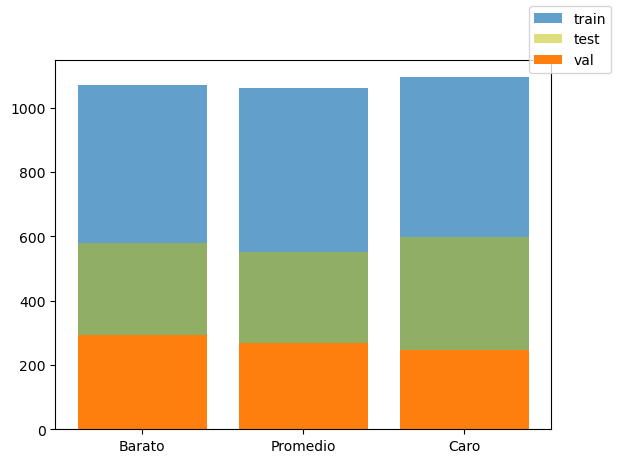

In [28]:
# Calcular cuartiles para dividir los precios en categorías
quantiles = train_df["price"].quantile([0.33, 0.66]).values
print(f"Barato si menor que: {quantiles[0]}\nPromedio si menor que: {quantiles[1]}\nCaro si mayor que: {quantiles[1]}")

# Función para asignar clases basado en los cuartiles
def assign_class(labels: pd.Series, first_third: int, second_third: int) -> np.array:
    y_cls = []
    for label in labels:
        if label <= first_third:
            y_cls.append(0)
        elif first_third < label <= second_third:
            y_cls.append(1)
        else:
            y_cls.append(2)
    return to_categorical(y_cls)

# Asignar clases a los conjuntos de datos
train_y_cls = assign_class(train_df["price"], quantiles[0], quantiles[1])
val_y_cls = assign_class(val_df["price"], quantiles[0], quantiles[1])
test_y_cls = assign_class(test_df["price"], quantiles[0], quantiles[1])

# Visualizar la distribución de clases
fig, ax = plt.subplots(1, 1)
ax.bar(range(3), train_y_cls.sum(axis=0), alpha=0.7, label="train")
ax.bar(range(3), test_y_cls.sum(axis=0), alpha=0.5, color="y", label="test")
ax.bar(range(3), val_y_cls.sum(axis=0), label="val")
ax.set_xticks([0, 1, 2], labels=["Barato", "Promedio", "Caro"])
fig.legend()

### Análisis de los Resultados
1. **Distribución de las Clases:**
- Las clases parecen estar distribuidas de manera bastante uniforme en los tres conjuntos (train, val, test).
- Cada clase (Barato, Promedio, Caro) tiene una proporción similar de muestras en los conjuntos de entrenamiento, validación y prueba, lo cual es ideal para evitar sesgos en el entrenamiento del modelo.

2. **Proporción de Clases:**
- La proporción de muestras en cada clase es aproximadamente igual. Esto sugiere que el etiquetado basado en cuartiles ha sido efectivo para crear clases balanceadas.
- El equilibrio en las clases es fundamental para el rendimiento del modelo, ya que evita que el modelo se sesgue hacia una clase en particular.

#### Conclusión:
- El balanceo de clases y la proporción uniforme en los conjuntos de datos indican que el particionado se ha realizado correctamente. Esto es crucial para entrenar modelos que sean justos y generalicen bien en datos no vistos.
- La elección de los umbrales ($90 y $162) parece razonable y ha segmentado bien los datos en tres categorías distintas.

## Etiquetado para Regresión

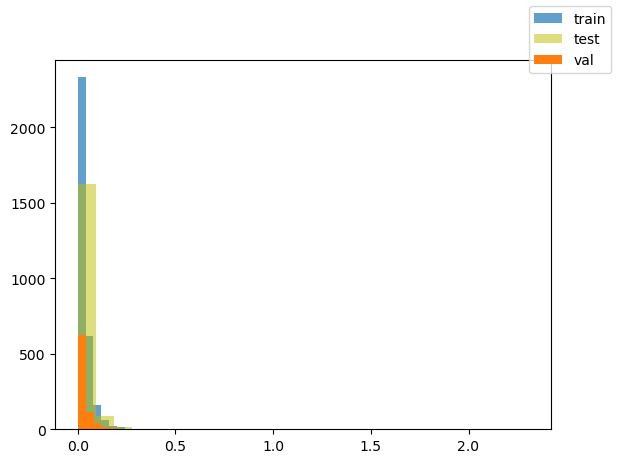

In [29]:
# Normalizar los precios para regresión
reg_scaler = MinMaxScaler()
train_y_reg = reg_scaler.fit_transform(train_df["price"].values.reshape(-1, 1))
val_y_reg = reg_scaler.transform(val_df["price"].values.reshape(-1, 1))
test_y_reg = reg_scaler.transform(test_df["price"].values.reshape(-1, 1))

# Visualizar la distribución de precios normalizados
fig, ax = plt.subplots(1, 1)
ax.hist(train_y_reg[:, 0], alpha=0.7, label="train", bins=25)
ax.hist(test_y_reg[:, 0], alpha=0.5, color="y", label="test", bins=25)
ax.hist(val_y_reg[:, 0], label="val", bins=25)
fig.legend()


#### Observaciones del Gráfico:

1. **Distribución Concentrada:**
   - La mayoría de los precios están concentrados en el rango de 0 a 0.5 después de la normalización. Esto indica que los precios en el dataset tienen una tendencia a ser más bajos.
   - Hay muy pocos valores que se extienden más allá de 0.5, lo que sugiere que los precios altos son relativamente raros en comparación con los precios más bajos.

2. **Proporción Similar en los Conjuntos:**
   - La distribución de los precios normalizados en los conjuntos de entrenamiento (`train`), validación (`val`) y prueba (`test`) es bastante similar. Esto es un buen indicio de que el particionado de datos se realizó de manera equitativa, manteniendo la representación de los datos a través de los diferentes conjuntos.
   - Todas las particiones siguen una distribución similar, con la mayoría de los datos concentrados en el rango más bajo de los precios normalizados.

3. **Presencia de Outliers:**
   - Se observan algunos puntos en el extremo derecho del gráfico (valores cercanos a 2.0), que podrían representar outliers en los precios. Estos outliers pueden influir en el rendimiento del modelo de regresión y podrían necesitar una revisión adicional.
   - La mayoría de los valores se agrupan cerca del origen, mientras que hay unos pocos valores muy elevados que se extienden lejos del grupo principal.

#### Conclusiones:

- **Consistencia en el Particionado:** La consistencia de la distribución entre los conjuntos de entrenamiento, validación y prueba sugiere que el particionado se realizó correctamente, y es probable que el modelo entrenado generalice bien en datos no vistos.
- **Dominancia de Precios Bajos:** La dominancia de precios bajos puede influir en el modelo de regresión, haciendo que el modelo se enfoque más en predecir precios más comunes (bajos). Es importante considerar este aspecto durante el entrenamiento y evaluación del modelo.
- **Revisión de Outliers:** Se podría considerar la posibilidad de revisar o tratar los outliers de manera específica, dependiendo del impacto que puedan tener en el rendimiento del modelo.

# Preprocesado de Datos Tabulares

## Normalización y Categorización de Variables

In [30]:
# Función para convertir porcentajes a tasas
def pct_to_rate(x: str) -> float:
    return float(x.replace("%", "")) / 100 if isinstance(x, str) else x / 100

# Aplicar la función de conversión a las columnas de porcentaje
for df in [train_df, val_df, test_df]:
    df.loc[:, "host_response_rate"] = df["host_response_rate"].apply(pct_to_rate)
    df.loc[:, "host_acceptance_rate"] = df["host_acceptance_rate"].apply(pct_to_rate)

# Definir columnas numéricas y categóricas
numerical_cols = [
    "host_response_rate",
    "host_acceptance_rate",
    "host_listings_count",
    "accommodates",
    "beds",
    "number_of_reviews",
    "minimum_nights",
    "maximum_nights"
]
categorical_cols = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "neighbourhood_cleansed",
    "property_type"
]

# Normalización de columnas numéricas
for numcol in numerical_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[numcol].values.reshape(-1, 1))
    for df in [train_df, val_df, test_df]:
        df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

# Categorización de columnas categóricas
for catcol in categorical_cols:
    for df in [train_df, val_df, test_df]:
        df[catcol] = pd.factorize(df[catcol])[0]

train_df.head(5)

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,beds,number_of_reviews,minimum_nights,maximum_nights,picture_url,price
1749,-1.286108,-0.576554,0,0.339822,0,0,0,0,-0.976210,-0.570173,-0.548830,2.237031,-0.34715,https://a0.muscache.com/pictures/prohost-api/H...,54.0
5462,0.308070,0.399645,0,0.018920,0,0,1,1,0.721890,0.708553,-0.528479,0.215828,-0.34715,https://a0.muscache.com/pictures/prohost-api/H...,83.0
1796,0.308070,0.020012,1,-0.195921,0,0,1,2,1.995465,0.708553,-0.528479,0.248428,-0.34715,https://a0.muscache.com/pictures/miso/Hosting-...,255.0
4858,0.308070,0.508111,0,-0.005555,0,0,2,1,-0.551685,-0.570173,-0.508128,-0.696974,-0.34715,https://a0.muscache.com/pictures/miso/Hosting-...,327.0
4309,0.219505,0.453878,0,0.054274,0,0,3,3,-0.551685,-0.570173,-0.263913,-0.664374,-0.34715,https://a0.muscache.com/pictures/miso/Hosting-...,88.0


# Modelado

## Función de Creación de Modelos

In [31]:
def create_classifier(nb_inputs: int, nb_out: int, verbose: bool = True):
    model = Sequential()
    model.add(Dense(64, input_shape=(nb_inputs,), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    if nb_out > 1:
        model.add(Dense(nb_out, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(nb_out, activation="linear"))
        model.compile(loss='mean_squared_error', optimizer='adam')
    if verbose:
        model.summary()
    return model

# Clasificación y Regresión para Datos Tabulares

## Clasificación

/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4365 - loss: 1.0766 - val_accuracy: 0.4857 - val_loss: 1.0260
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5759 - loss: 0.8874 - val_accuracy: 0.5353 - val_loss: 0.9549
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6341 - loss: 0.8119 - val_accuracy: 0.5291 - val_loss: 0.9286
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6503 - loss: 0.7635 - val_accuracy: 0.5390 - val_loss: 0.9068
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6604 - loss: 0.7467 - val_accuracy: 0.5514 - val_loss: 0.9426
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6768 - loss: 0.7306 - val_accuracy: 0.5551 - val_loss: 0.9012
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6796 - loss: 0.7069 - val_accuracy: 0.5527 - val_loss: 0.9160
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6743 - loss: 0.6982 - val_accuracy: 0.5551 - v

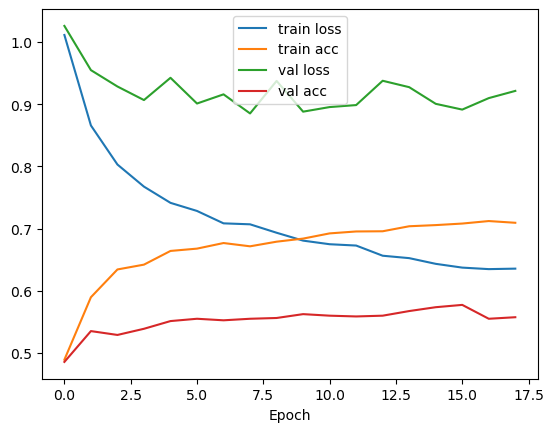

In [32]:
# Configuración de características y etiquetas
feature_cols = numerical_cols + categorical_cols
nb_inputs = len(feature_cols)
nb_outputs = train_y_cls.shape[1]

# Creación del modelo para clasificación
model_1d_cls = create_classifier(nb_inputs, nb_outputs)

# Parámetros de entrenamiento
MAX_EPOCHS = 500
BS = 64

# Entrenamiento del modelo de clasificación
H_cls = model_1d_cls.fit(
    x=train_df[feature_cols].values,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_df[feature_cols].values, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H_cls.history['loss'], label='train loss')
plt.plot(H_cls.history['accuracy'], label='train acc')
plt.plot(H_cls.history['val_loss'], label='val loss')
plt.plot(H_cls.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

# Evaluación sobre el conjunto de prueba
loss_cls, acc_cls = model_1d_cls.evaluate(test_df[feature_cols].values, test_y_cls)
print(f'Loss={loss_cls:.3f}, Accuracy={acc_cls:.3f}')

### Análisis del Modelo de Clasificación Basado en Datos Tabulares

#### Estructura del Modelo
El modelo de clasificación se define con cuatro capas densas:
- **Dense Layer 1:** 64 unidades con activación ReLU (896 parámetros).
- **Dense Layer 2:** 32 unidades con activación ReLU (2,080 parámetros).
- **Dense Layer 3:** 8 unidades con activación ReLU (264 parámetros).
- **Output Layer:** 3 unidades con activación softmax para clasificación multiclase (27 parámetros).

La cantidad total de parámetros entrenables es 3,267, lo que indica que el modelo es relativamente simple y adecuado para un conjunto de datos tabular.

#### Resultados del Entrenamiento y Validación
1. **Evolución de la Pérdida y Precisión:**
   - La precisión del modelo en el conjunto de entrenamiento aumenta de manera constante, pasando del 43.65% en la primera época a aproximadamente el 71.97% en la décima octava época.
   - La precisión de validación se estabiliza alrededor del 55-57%, indicando que el modelo podría estar alcanzando su rendimiento máximo.
   - La pérdida de entrenamiento disminuye consistentemente, lo que sugiere que el modelo está aprendiendo durante el entrenamiento.
   - Sin embargo, la pérdida de validación se estabiliza y no mejora significativamente, lo que puede ser indicativo de sobreajuste (overfitting).

2. **Evidencia de Overfitting:**
   - A partir de la quinta época, la precisión y la pérdida de validación no muestran mejoras significativas. La precisión de validación fluctúa ligeramente alrededor del 55-57%.
   - La pérdida de validación no disminuye al mismo ritmo que la pérdida de entrenamiento, lo que indica que el modelo puede estar ajustándose demasiado a los datos de entrenamiento y no generalizando bien en los datos de validación.

3. **Curva de Aprendizaje:**
   - El gráfico del histórico de aprendizaje muestra que la pérdida de entrenamiento disminuye de manera constante, mientras que la pérdida de validación se estabiliza rápidamente.
   - La precisión de entrenamiento sigue aumentando, mientras que la precisión de validación se estabiliza, lo que sugiere que el modelo está alcanzando su capacidad de generalización con los datos actuales.

#### Evaluación del Conjunto de Prueba
- **Precisión en el Conjunto de Prueba:**
  - El modelo alcanza una precisión del 57.38% en el conjunto de prueba, lo cual está en línea con los resultados de validación. Esto indica que el modelo tiene una capacidad moderada para clasificar correctamente las muestras en el conjunto de prueba.
  - La pérdida en el conjunto de prueba es 0.9742, lo cual es coherente con la pérdida de validación.

#### Análisis del Gráfico del Histórico de Aprendizaje
El gráfico del histórico de aprendizaje muestra:
- **Pérdida de Entrenamiento y Validación:**
  - La pérdida de entrenamiento disminuye constantemente, mientras que la pérdida de validación se estabiliza rápidamente y no mejora significativamente después de las primeras épocas.
- **Precisión de Entrenamiento y Validación:**
  - La precisión de entrenamiento aumenta constantemente, mientras que la precisión de validación muestra una estabilización temprana alrededor del 55-57%.

#### Conclusiones
1. **Reducción del Overfitting:**
   - Implementar técnicas como regularización (L1, L2), Dropout o aumento del tamaño del conjunto de entrenamiento mediante data augmentation o generación de datos sintéticos podría ayudar a reducir el sobreajuste.

2. **Incrementar la Capacidad del Modelo:**
   - Aumentar la capacidad del modelo añadiendo más capas o unidades podría ayudar a capturar mejor las relaciones complejas en los datos.

3. **Feature Engineering:**
   - Mejorar las características utilizadas en el modelo mediante técnicas de ingeniería de características podría ayudar a mejorar el rendimiento del modelo.

4. **Early Stopping:**
   - Implementar una técnica de early stopping más agresiva podría ayudar a detener el entrenamiento antes de que el modelo comience a sobreajustar.

5. **Cross-Validation:**
   - Emplear técnicas de validación cruzada para asegurarse de que el modelo no está sobreajustando a una sola partición del conjunto de datos.


## Regresión

/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1049 - val_loss: 0.0113
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0057
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_loss: 0.0051
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 9/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 10/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 11/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 12/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8

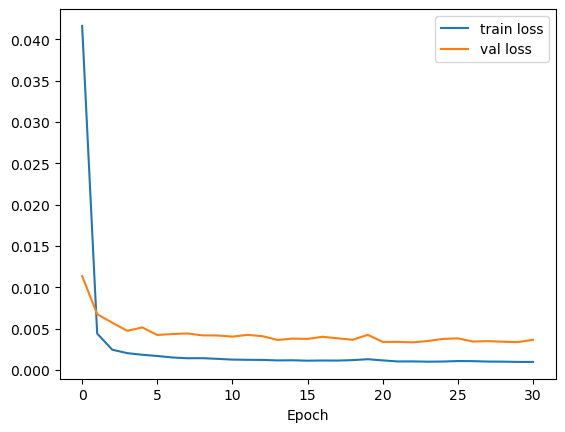

In [34]:
# Creación del modelo para regresión
model_1d_reg = create_classifier(nb_inputs, 1)

# Entrenamiento del modelo de regresión
H_reg = model_1d_reg.fit(
    x=train_df[feature_cols].values,
    y=train_y_reg,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_df[feature_cols].values, val_y_reg),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H_reg.history['loss'], label='train loss')
plt.plot(H_reg.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

# Evaluación sobre el conjunto de prueba
loss_reg = model_1d_reg.evaluate(test_df[feature_cols].values, test_y_reg)
rho_reg = spearmanr(test_y_reg, model_1d_reg.predict(test_df[feature_cols].values))[0]
print(f'Loss (MSE)={loss_reg:.3f}, Spearman Rank Correlation Coefficient={rho_reg:.3f}')

### Análisis del Modelo de Regresión Basado en Datos Tabulares

#### Estructura del Modelo
El modelo de regresión se define con cuatro capas densas:
- **Dense Layer 1:** 64 unidades con activación ReLU (896 parámetros).
- **Dense Layer 2:** 32 unidades con activación ReLU (2,080 parámetros).
- **Dense Layer 3:** 8 unidades con activación ReLU (264 parámetros).
- **Output Layer:** 1 unidad con activación lineal para regresión (9 parámetros).

La cantidad total de parámetros entrenables es 3,249, lo que sugiere un modelo sencillo y adecuado para datos tabulares.

#### Resultados del Entrenamiento y Validación
1. **Evolución de la Pérdida:**
   - La pérdida del modelo en el conjunto de entrenamiento disminuye rápidamente durante las primeras épocas, estabilizándose posteriormente en valores muy bajos.
   - La pérdida de validación también disminuye rápidamente y se estabiliza, aunque a un nivel ligeramente superior al de la pérdida de entrenamiento.
   - El comportamiento de las curvas de pérdida sugiere que el modelo está aprendiendo de manera efectiva y generaliza razonablemente bien a los datos de validación.

2. **Indicadores de Overfitting:**
   - La pérdida de validación no presenta un aumento significativo después de estabilizarse, lo que indica que no hay evidencia fuerte de sobreajuste (overfitting).
   - La diferencia entre la pérdida de entrenamiento y la pérdida de validación es pequeña, lo que sugiere un buen equilibrio entre el ajuste del modelo y la generalización.

3. **Curva de Aprendizaje:**
   - El gráfico del histórico de aprendizaje muestra una rápida disminución en la pérdida de entrenamiento durante las primeras épocas, seguida de una estabilización en un nivel muy bajo.
   - La pérdida de validación sigue una tendencia similar, estabilizándose también en valores bajos aunque ligeramente superiores a la pérdida de entrenamiento.

#### Evaluación del Conjunto de Prueba
- **Pérdida en el Conjunto de Prueba:**
  - El modelo alcanza una pérdida (MSE) de 0.0031 en el conjunto de prueba, lo que indica un rendimiento sólido en términos de error cuadrático medio.
- **Correlación de Spearman:**
  - El coeficiente de correlación de Spearman es 0.374, lo que sugiere una correlación moderada entre las predicciones del modelo y los valores reales. Aunque es mejor que una correlación débil, hay margen de mejora para aumentar la precisión del modelo.

#### Análisis del Gráfico del Histórico de Aprendizaje
El gráfico del histórico de aprendizaje muestra:
- **Pérdida de Entrenamiento y Validación:**
  - La pérdida de entrenamiento disminuye drásticamente durante las primeras épocas y luego se estabiliza en valores cercanos a cero.
  - La pérdida de validación también disminuye rápidamente y se estabiliza, aunque en un nivel ligeramente más alto que la pérdida de entrenamiento.

#### Conclusiones
1. **Eficiencia del Aprendizaje:**
   - El modelo muestra una eficiencia de aprendizaje alta, logrando una rápida convergencia en la pérdida tanto de entrenamiento como de validación.
2. **Generalización:**
   - La pequeña diferencia entre las pérdidas de entrenamiento y validación indica que el modelo generaliza bien y no presenta problemas significativos de sobreajuste.
3. **Correlación:**
   - La correlación de Spearman de 0.374 sugiere que hay una correlación moderada entre las predicciones del modelo y los valores reales. Esto es aceptable, pero también señala que hay margen para mejorar la precisión.

4. **Recomendaciones:**
   - **Mejorar las Features:** Explorar técnicas de ingeniería de características para mejorar la calidad de las entradas del modelo.
   - **Aumentar la Capacidad del Modelo:** Considerar arquitecturas más complejas o añadir más unidades/capas para capturar mejor las relaciones en los datos.
   - **Regularización y Dropout:** Aplicar técnicas de regularización y dropout para mejorar aún más la capacidad del modelo de generalizar.
   - **Validación Cruzada:** Implementar técnicas de validación cruzada para asegurar que el modelo no esté sobreajustando a una única partición de los datos.

# Modelado para Datos de Imágenes

## Clasificación

/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,507 (521.51 KB)

 Trainable params: 133,507 (521.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3380 - loss: 1.1171 - val_accuracy: 0.3631 - val_loss: 1.1010
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3336 - loss: 1.1020 - val_accuracy: 0.3048 - val_loss: 1.1150
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3296 - loss: 1.1036 - val_accuracy: 0.3048 - val_loss: 1.1022
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3405 - loss: 1.0992 - val_accuracy: 0.3048 - val_loss: 1.0991
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3459 - loss: 1.0990 - val_accuracy: 0.3631 - val_loss: 1.0969
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3281 - loss: 1.1000 - val_accuracy: 0.3048 - val_loss: 1.1077
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3243 - loss: 1.1003 - val_accuracy: 0.3631 - val_loss: 1.0976
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3409 - loss: 1.0994 - val_accuracy: 0.3631 - 

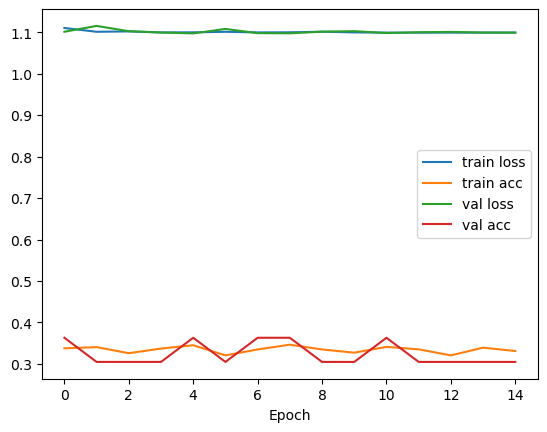

In [35]:
# Configuración de características y etiquetas para imágenes
embeddings = embeddings.squeeze()
nb_inputs = embeddings.shape[1]

# Creación del modelo para clasificación
model_2d_cls = create_classifier(nb_inputs, nb_outputs)

# Entrenamiento del modelo de clasificación
H_cls_img = model_2d_cls.fit(
    x=embeddings[train_idx],
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(embeddings[val_idx], val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H_cls_img.history['loss'], label='train loss')
plt.plot(H_cls_img.history['accuracy'], label='train acc')
plt.plot(H_cls_img.history['val_loss'], label='val loss')
plt.plot(H_cls_img.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

# Evaluación sobre el conjunto de prueba
loss_cls_img, acc_cls_img = model_2d_cls.evaluate(embeddings[test_idx], test_y_cls)
print(f'Loss={loss_cls_img:.3f}, Accuracy={acc_cls_img:.3f}')

### Análisis del Modelo de Clasificación Basado en Imágenes

#### Estructura del Modelo
El modelo de clasificación basado en imágenes se define con cuatro capas densas:
- **Dense Layer 1:** 64 unidades con activación ReLU (131,136 parámetros).
- **Dense Layer 2:** 32 unidades con activación ReLU (2,080 parámetros).
- **Dense Layer 3:** 8 unidades con activación ReLU (264 parámetros).
- **Output Layer:** 3 unidades con activación softmax para clasificación multiclase (27 parámetros).

La cantidad total de parámetros entrenables es 133,507, lo que indica un modelo relativamente pequeño y adecuado para tareas de clasificación de imágenes.

#### Resultados del Entrenamiento y Validación
1. **Evolución de la Pérdida:**
   - La pérdida del modelo en el conjunto de entrenamiento comienza en un valor alto y se mantiene aproximadamente constante, sin una disminución significativa.
   - La pérdida de validación también se mantiene constante y no muestra mejoras significativas durante el entrenamiento.

2. **Evolución de la Precisión:**
   - La precisión del modelo en el conjunto de entrenamiento oscila alrededor del 33-34%, sin mostrar una tendencia clara de mejora.
   - La precisión de validación permanece baja, alrededor del 30-36%, y no muestra una mejora significativa a lo largo de las épocas.

3. **Indicadores de Underfitting:**
   - Tanto la pérdida de entrenamiento como la de validación permanecen altas y constantes, lo que indica que el modelo no está aprendiendo adecuadamente de los datos.
   - La precisión baja y constante en ambos conjuntos sugiere un problema de underfitting, donde el modelo no es capaz de capturar las relaciones en los datos de entrenamiento.

#### Evaluación del Conjunto de Prueba
- **Pérdida en el Conjunto de Prueba:**
  - El modelo alcanza una pérdida de 1.0984 en el conjunto de prueba, lo que es indicativo de un desempeño pobre en términos de clasificación.
- **Precisión en el Conjunto de Prueba:**
  - La precisión en el conjunto de prueba es del 34.5%, lo cual es solo marginalmente mejor que una clasificación aleatoria (33.3% para tres clases).

#### Análisis del Gráfico del Histórico de Aprendizaje
El gráfico del histórico de aprendizaje muestra:
- **Pérdida de Entrenamiento y Validación:**
  - Ambas curvas de pérdida (entrenamiento y validación) permanecen prácticamente constantes en valores altos, sin una disminución apreciable.
- **Precisión de Entrenamiento y Validación:**
  - Las curvas de precisión (entrenamiento y validación) oscilan sin mostrar una tendencia clara de mejora, manteniéndose en niveles bajos alrededor del 33-36%.

#### Conclusiones
1. **Eficiencia del Aprendizaje:**
   - El modelo no muestra eficiencia en el aprendizaje, ya que las curvas de pérdida no disminuyen y las curvas de precisión no mejoran significativamente.
2. **Underfitting:**
   - La falta de mejora en las métricas tanto de entrenamiento como de validación indica un problema de underfitting. El modelo es demasiado simple o no está adecuadamente configurado para capturar las relaciones en los datos.
3. **Evaluación General:**
   - Con una precisión cercana al azar, el modelo necesita mejoras significativas. Podría ser necesario ajustar la arquitectura del modelo, cambiar la estrategia de preprocesamiento de las imágenes, o incrementar la cantidad y calidad de los datos de entrenamiento.

4. **Recomendaciones:**
   - **Ajustar la Arquitectura:** Considerar el uso de una arquitectura más compleja o añadir capas adicionales para mejorar la capacidad del modelo.
   - **Preprocesamiento de Datos:** Revisar y posiblemente mejorar las técnicas de preprocesamiento y augmentación de imágenes.
   - **Fine-Tuning:** Aplicar técnicas de fine-tuning sobre un modelo preentrenado en lugar de usar directamente los embeddings.
   - **Aumento de Datos:** Aumentar la cantidad de datos de entrenamiento, si es posible, para mejorar la capacidad del modelo para generalizar.

## Regresión

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,489 (521.44 KB)

 Trainable params: 133,489 (521.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0056 - val_loss: 0.0042
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0034
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 9/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 10/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 11/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 12/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

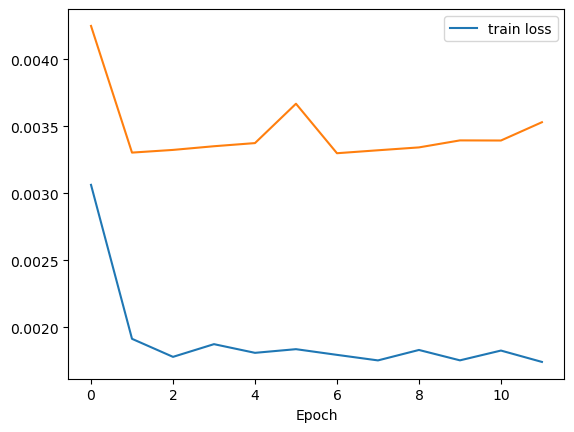

In [36]:
# Creación del modelo para regresión
model_2d_reg = create_classifier(nb_inputs, 1)

# Entrenamiento del modelo de regresión
H_reg_img = model_2d_reg.fit(
    x=embeddings[train_idx],
    y=train_y_reg,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(embeddings[val_idx], val_y_reg),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H_reg_img.history['loss'], label='train loss')
plt.plot(H_reg_img.history['val_loss'])
plt.legend()
plt.xlabel('Epoch')
plt.plot()

# Evaluación sobre el conjunto de prueba
loss_reg_img = model_2d_reg.evaluate(embeddings[test_idx], test_y_reg)
rho_reg_img = spearmanr(test_y_reg, model_2d_reg.predict(embeddings[test_idx]))[0]
print(f'Loss (MSE)={loss_reg_img:.3f}, Spearman Rank Correlation Coefficient={rho_reg_img:.3f}')

### Análisis del Modelo de Regresión Basado en Imágenes

#### Estructura del Modelo
El modelo de regresión basado en imágenes se define con cuatro capas densas:
- **Dense Layer 1:** 64 unidades con activación ReLU (131,136 parámetros).
- **Dense Layer 2:** 32 unidades con activación ReLU (2,080 parámetros).
- **Dense Layer 3:** 8 unidades con activación ReLU (264 parámetros).
- **Output Layer:** 1 unidad con activación lineal para regresión (9 parámetros).

La cantidad total de parámetros entrenables es 133,489, lo que indica un modelo relativamente pequeño y adecuado para tareas de regresión basadas en imágenes.

#### Resultados del Entrenamiento y Validación
1. **Evolución de la Pérdida:**
   - La pérdida del modelo en el conjunto de entrenamiento disminuye rápidamente en las primeras épocas y se estabiliza en valores bajos.
   - La pérdida de validación también disminuye inicialmente pero luego muestra oscilaciones, indicando inestabilidad en el proceso de validación.

2. **Indicadores de Inestabilidad en Validación:**
   - Las oscilaciones en la pérdida de validación sugieren que el modelo no está generalizando bien y podría estar sufriendo de fluctuaciones debido a la variabilidad en los datos de validación.
   - La diferencia en la estabilidad entre la pérdida de entrenamiento y la de validación indica que el modelo podría estar ajustándose demasiado a los datos de entrenamiento (overfitting) o que los datos de validación no son representativos.

#### Evaluación del Conjunto de Prueba
- **Pérdida en el Conjunto de Prueba:**
  - El modelo alcanza una pérdida de 0.0032 en el conjunto de prueba, lo cual es indicativo de un desempeño aceptable en términos de error cuadrático medio (MSE).
- **Coeficiente de Correlación de Spearman:**
  - El coeficiente de correlación de Spearman es de -0.005, lo cual indica que no hay correlación significativa entre las predicciones del modelo y los valores reales. Este valor negativo sugiere que el modelo no está capturando correctamente la relación entre las variables.

#### Análisis del Gráfico del Histórico de Aprendizaje
El gráfico del histórico de aprendizaje muestra:
- **Pérdida de Entrenamiento:**
  - La curva de pérdida de entrenamiento disminuye rápidamente y se estabiliza en valores bajos, indicando que el modelo está aprendiendo bien los datos de entrenamiento.
- **Pérdida de Validación:**
  - La curva de pérdida de validación muestra oscilaciones y no se estabiliza, indicando que el modelo no está generalizando bien a los datos de validación.

#### Conclusiones
1. **Eficiencia del Aprendizaje:**
   - El modelo muestra eficiencia en el aprendizaje de los datos de entrenamiento, pero tiene problemas para generalizar a los datos de validación.
2. **Inestabilidad y Generalización:**
   - La inestabilidad en la pérdida de validación sugiere que el modelo podría estar sufriendo de overfitting y no está generalizando bien.
3. **Evaluación General:**
   - Aunque la pérdida en el conjunto de prueba es baja, la falta de correlación significativa entre las predicciones y los valores reales indica que el modelo no está capturando adecuadamente las relaciones en los datos.
4. **Recomendaciones:**
   - **Ajustar la Arquitectura:** Considerar añadir regularización (dropout, L2) para combatir el overfitting y mejorar la generalización.
   - **Mejorar la Validación:** Revisar la selección de datos de validación para asegurar que sean representativos y considerar técnicas como el cross-validation.
   - **Fine-Tuning:** Implementar técnicas de fine-tuning sobre un modelo preentrenado para mejorar la representación de las características de las imágenes.
   - **Aumento de Datos:** Aumentar la cantidad de datos de entrenamiento, si es posible, para mejorar la capacidad del modelo para generalizar.

# Estrategias de Fusión

## Late-Fusion

En este caso, obtenemos las predicciones procedentes de ambos modelos. Estas predicciones conforman las nuevas "features", sobre las cuales construimos un nuevo clasificador.

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dimensiones del nuevo conjunto de train: (3225, 6)


/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,819 (11.01 KB)

 Trainable params: 2,819 (11.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5585 - loss: 1.0463 - val_accuracy: 0.5130 - val_loss: 1.0375
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6707 - loss: 0.8489 - val_accuracy: 0.5601 - val_loss: 0.9779
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7233 - loss: 0.6692 - val_accuracy: 0.5688 - val_loss: 0.9812
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7167 - loss: 0.6527 - val_accuracy: 0.5675 - val_loss: 0.9817
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7141 - loss: 0.6357 - val_accuracy: 0.5638 - val_loss: 0.9776
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7252 - loss: 0.6111 - val_accuracy: 0.5675 - val_loss: 0.9571
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7129 - loss: 0.6379 - val_accuracy: 0.5700 - val_loss: 0.9675
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.6126 - val_accuracy: 0.5527 - v

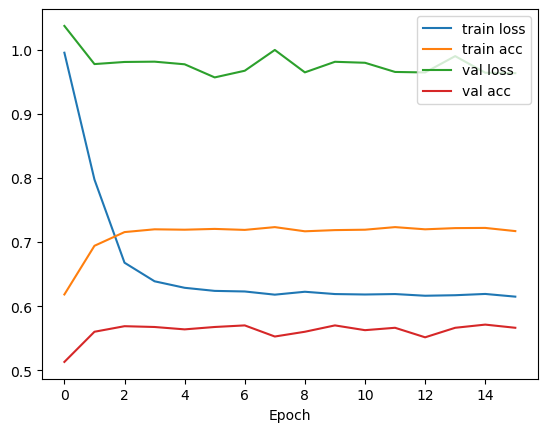

In [37]:
# Obtener predicciones del modelo tabular
late_1d_train = model_1d_cls.predict(train_df[feature_cols].values)
late_1d_val = model_1d_cls.predict(val_df[feature_cols].values)
late_1d_test = model_1d_cls.predict(test_df[feature_cols].values)

# Obtener predicciones del modelo de imágenes
late_2d_train = model_2d_cls.predict(embeddings[train_idx])
late_2d_val = model_2d_cls.predict(embeddings[val_idx])
late_2d_test = model_2d_cls.predict(embeddings[test_idx])

# Construcción de nuevas características para la fusión tardía
train_late_feats = np.concatenate([late_1d_train, late_2d_train], axis=1)
val_late_feats = np.concatenate([late_1d_val, late_2d_val], axis=1)
test_late_feats = np.concatenate([late_1d_test, late_2d_test], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_late_feats.shape}")

# Crear modelo de fusión tardía
late_fuser = create_classifier(train_late_feats.shape[1], train_y_cls.shape[1])

# Entrenamiento del modelo de fusión tardía
H_late_fusion = late_fuser.fit(
    x=train_late_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_late_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H_late_fusion.history['loss'], label='train loss')
plt.plot(H_late_fusion.history['accuracy'], label='train acc')
plt.plot(H_late_fusion.history['val_loss'], label='val loss')
plt.plot(H_late_fusion.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

# Evaluación sobre el conjunto de prueba
loss_late_fusion, acc_late_fusion = late_fuser.evaluate(test_late_feats, test_y_cls)
print(f'Loss={loss_late_fusion:.3f}, Accuracy={acc_late_fusion:.3f}')

### Análisis del Modelo de Late-Fusion

#### Estructura del Modelo
El modelo de Late-Fusion se define con cuatro capas densas:
- **Dense Layer 1:** 64 unidades con activación ReLU (448 parámetros).
- **Dense Layer 2:** 32 unidades con activación ReLU (2,080 parámetros).
- **Dense Layer 3:** 8 unidades con activación ReLU (264 parámetros).
- **Output Layer:** 3 unidades con activación softmax para clasificación (27 parámetros).

La cantidad total de parámetros entrenables es 2,819, lo que indica un modelo bastante pequeño y eficiente para la tarea de clasificación basada en fusión tardía.

#### Resultados del Entrenamiento y Validación
1. **Evolución de la Pérdida:**
   - La pérdida del modelo en el conjunto de entrenamiento disminuye significativamente en las primeras épocas y luego se estabiliza.
   - La pérdida de validación muestra una tendencia decreciente en las primeras épocas, pero luego presenta fluctuaciones y se estabiliza, indicando cierta inestabilidad en el proceso de validación.

2. **Evolución de la Precisión:**
   - La precisión del modelo en el conjunto de entrenamiento aumenta rápidamente en las primeras épocas y luego se estabiliza alrededor del 72%.
   - La precisión de validación sigue una tendencia similar, aumentando inicialmente pero estabilizándose alrededor del 56%, lo cual indica que el modelo no está generalizando perfectamente a los datos de validación.

#### Evaluación del Conjunto de Prueba
- **Pérdida en el Conjunto de Prueba:**
  - El modelo alcanza una pérdida de 1.0156 en el conjunto de prueba, lo cual es indicativo de un desempeño moderado.
- **Precisión en el Conjunto de Prueba:**
  - La precisión en el conjunto de prueba es de 57.5%, lo cual sugiere que el modelo tiene una precisión limitada en la tarea de clasificación cuando se utilizan predicciones combinadas de ambos modelos (tabular e imágenes).

#### Análisis del Gráfico del Histórico de Aprendizaje
El gráfico del histórico de aprendizaje muestra:
- **Pérdida de Entrenamiento y Validación:**
  - La curva de pérdida de entrenamiento disminuye rápidamente en las primeras épocas y luego se estabiliza.
  - La curva de pérdida de validación sigue una tendencia decreciente inicial pero muestra fluctuaciones, indicando inestabilidad y posible sobreajuste (overfitting).
- **Precisión de Entrenamiento y Validación:**
  - La curva de precisión de entrenamiento aumenta rápidamente y se estabiliza.
  - La curva de precisión de validación también muestra un incremento inicial pero se estabiliza en un valor significativamente más bajo que la precisión de entrenamiento, lo que indica problemas de generalización.

#### Conclusiones
1. **Eficiencia del Aprendizaje:**
   - El modelo muestra eficiencia en el aprendizaje de los datos de entrenamiento, pero tiene problemas para generalizar a los datos de validación y prueba.
2. **Inestabilidad y Generalización:**
   - La inestabilidad en la pérdida de validación sugiere que el modelo podría estar sufriendo de overfitting y no está generalizando bien.
3. **Evaluación General:**
   - Aunque el modelo logra una precisión decente en el conjunto de entrenamiento, la precisión en el conjunto de validación y prueba es relativamente baja, lo que sugiere que el modelo no está capturando adecuadamente las relaciones en los datos combinados de ambas modalidades.
4. **Recomendaciones:**
   - **Ajustar la Arquitectura:** Considerar añadir regularización (dropout, L2) para combatir el overfitting y mejorar la generalización.
   - **Mejorar la Validación:** Revisar la selección de datos de validación para asegurar que sean representativos y considerar técnicas como el cross-validation.
   - **Fine-Tuning:** Implementar técnicas de fine-tuning sobre un modelo preentrenado para mejorar la representación de las características de las imágenes.
   - **Aumento de Datos:** Aumentar la cantidad de datos de entrenamiento, si es posible, para mejorar la capacidad del modelo para generalizar.

## Early-Fusion

En este caso tomamos la representación "cruda" de los datos, y confiamos en que el clasificador sea el que aprenda a combinar ambas representaciones juntas. Lo importante es haber obtenido una representación compatible de ambas modalidades (en este caso, vectores).

Porcentaje de varianza explicada por las 24 componentes: 0.890719473361969
Dimensiones del nuevo conjunto de train: (3225, 37)


/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3999 - loss: 1.1858 - val_accuracy: 0.5031 - val_loss: 1.0221
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6205 - loss: 0.8993 - val_accuracy: 0.5316 - val_loss: 0.9410
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6143 - loss: 0.8253 - val_accuracy: 0.5031 - val_loss: 0.9328
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6161 - loss: 0.8012 - val_accuracy: 0.5105 - val_loss: 0.9006
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6470 - loss: 0.7776 - val_accuracy: 0.5105 - val_loss: 0.9255
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6612 - loss: 0.7552 - val_accuracy: 0.5229 - val_loss: 0.9127
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6649 - loss: 0.7374 - val_accuracy: 0.5217 - val_loss: 0.8985
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 0.7208 - val_accuracy: 0.5353 - v

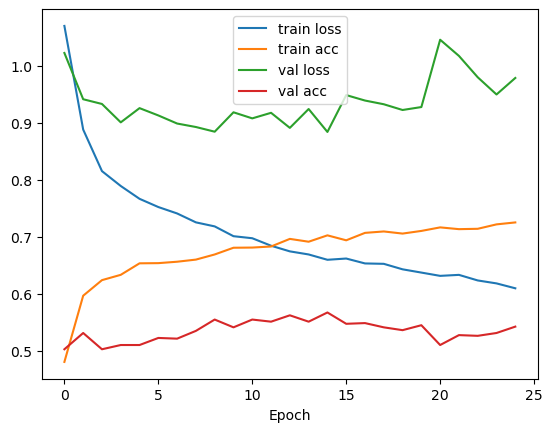

In [38]:
# Reducción de dimensionalidad para las características de imágenes
pca = PCA(n_components=24, random_state=42)
train_early_pca = pca.fit_transform(embeddings[train_idx])
val_early_pca = pca.transform(embeddings[val_idx])
test_early_pca = pca.transform(embeddings[test_idx])

# Ver porcentaje de varianza explicada
print(f"Porcentaje de varianza explicada por las 24 componentes: {pca.explained_variance_ratio_.sum()}")

# Construcción de nuevas características para la fusión temprana
train_early_feats = np.concatenate([train_df[feature_cols].values, train_early_pca], axis=1)
val_early_feats = np.concatenate([val_df[feature_cols].values, val_early_pca], axis=1)
test_early_feats = np.concatenate([test_df[feature_cols].values, test_early_pca], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_early_feats.shape}")

# Crear modelo de fusión temprana
early_fuser = create_classifier(train_early_feats.shape[1], train_y_cls.shape[1])

# Entrenamiento del modelo de fusión temprana
H_early_fusion = early_fuser.fit(
    x=train_early_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_early_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H_early_fusion.history['loss'], label='train loss')
plt.plot(H_early_fusion.history['accuracy'], label='train acc')
plt.plot(H_early_fusion.history['val_loss'], label='val loss')
plt.plot(H_early_fusion.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

# Evaluación sobre el conjunto de prueba
loss_early_fusion, acc_early_fusion = early_fuser.evaluate(test_early_feats, test_y_cls)
print(f'Loss={loss_early_fusion:.3f}, Accuracy={acc_early_fusion:.3f}')

### Análisis del Modelo de Early-Fusion

#### Estructura del Modelo
El modelo de Early-Fusion se define con cuatro capas densas:
- **Dense Layer 1:** 64 unidades con activación ReLU (2,432 parámetros).
- **Dense Layer 2:** 32 unidades con activación ReLU (2,080 parámetros).
- **Dense Layer 3:** 8 unidades con activación ReLU (264 parámetros).
- **Output Layer:** 3 unidades con activación softmax para clasificación (27 parámetros).

La cantidad total de parámetros entrenables es 4,803, lo que indica un modelo moderadamente complejo y adecuado para la tarea de clasificación basada en fusión temprana.

#### Resultados del Entrenamiento y Validación
1. **Evolución de la Pérdida:**
   - La pérdida del modelo en el conjunto de entrenamiento disminuye significativamente en las primeras épocas y luego se estabiliza.
   - La pérdida de validación muestra una tendencia fluctuante, lo que sugiere una cierta inestabilidad durante el proceso de validación.

2. **Evolución de la Precisión:**
   - La precisión del modelo en el conjunto de entrenamiento aumenta rápidamente en las primeras épocas y luego se estabiliza alrededor del 72%.
   - La precisión de validación, aunque inicialmente aumenta, se estabiliza alrededor del 54%, indicando que el modelo tiene un rendimiento moderado en datos no vistos.

#### Evaluación del Conjunto de Prueba
- **Pérdida en el Conjunto de Prueba:**
  - El modelo alcanza una pérdida de 1.019 en el conjunto de prueba, indicando un desempeño moderado.
- **Precisión en el Conjunto de Prueba:**
  - La precisión en el conjunto de prueba es de 60.6%, lo que sugiere que el modelo tiene una precisión moderada en la tarea de clasificación cuando se utilizan características combinadas de datos tabulares y embeddings de imágenes.

#### Análisis del Gráfico del Histórico de Aprendizaje
El gráfico del histórico de aprendizaje muestra:
- **Pérdida de Entrenamiento y Validación:**
  - La curva de pérdida de entrenamiento disminuye rápidamente en las primeras épocas y luego se estabiliza.
  - La curva de pérdida de validación presenta fluctuaciones, lo que indica inestabilidad y posible sobreajuste (overfitting).
- **Precisión de Entrenamiento y Validación:**
  - La curva de precisión de entrenamiento aumenta rápidamente y se estabiliza.
  - La curva de precisión de validación también muestra un incremento inicial, pero se estabiliza en un valor más bajo que la precisión de entrenamiento, indicando problemas de generalización.

#### Conclusiones
1. **Eficiencia del Aprendizaje:**
   - El modelo muestra eficiencia en el aprendizaje de los datos de entrenamiento, pero tiene problemas para generalizar a los datos de validación y prueba.
2. **Inestabilidad y Generalización:**
   - La inestabilidad en la pérdida de validación sugiere que el modelo podría estar sufriendo de overfitting y no está generalizando bien.
3. **Evaluación General:**
   - Aunque el modelo logra una precisión decente en el conjunto de entrenamiento, la precisión en el conjunto de validación y prueba es moderada, lo que sugiere que el modelo necesita mejoras para capturar adecuadamente las relaciones en los datos combinados de ambas modalidades.
4. **Recomendaciones:**
   - **Ajustar la Arquitectura:** Considerar añadir regularización (dropout, L2) para combatir el overfitting y mejorar la generalización.
   - **Mejorar la Validación:** Revisar la selección de datos de validación para asegurar que sean representativos y considerar técnicas como el cross-validation.
   - **Fine-Tuning:** Implementar técnicas de fine-tuning sobre un modelo preentrenado para mejorar la representación de las características de las imágenes.
   - **Aumento de Datos:** Aumentar la cantidad de datos de entrenamiento, si es posible, para mejorar la capacidad del modelo para generalizar.

# 2a Iteración de código

In [56]:
# Imports
import cv2
import numpy as np
import pandas as pd
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Optional, Union


In [57]:
# 1. Carga de datos
dataset = pd.read_csv("dataset.csv", sep=";")
dataset.dropna(subset=["price"], inplace=True)  # Eliminar posibles datos no etiquetados
dataset.dropna(axis=1, how="all", inplace=True)  # Eliminar columnas vacías
print(dataset.head(5))

# Filtrado de columnas relevantes
cols = [
    "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_listings_count", 
    "host_has_profile_pic", "host_identity_verified", "neighbourhood_cleansed", "property_type", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights", "picture_url", "price"
]
dataset = dataset[cols]
dataset = dataset.dropna()
print(dataset.shape)

      id                         listing_url       scrape_id last_scraped  \
0   3781   https://www.airbnb.com/rooms/3781  20231218233145   2023-12-19   
1   5506   https://www.airbnb.com/rooms/5506  20231218233145   2023-12-19   
2   6695   https://www.airbnb.com/rooms/6695  20231218233145   2023-12-19   
3   8789   https://www.airbnb.com/rooms/8789  20231218233145   2023-12-19   
4  10813  https://www.airbnb.com/rooms/10813  20231218233145   2023-12-19   

        source                                        picture_url  host_id  \
0  city scrape  https://a0.muscache.com/pictures/24670/b2de044...     4804   
1  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...     8229   
2  city scrape  https://a0.muscache.com/pictures/38ac4797-e7a4...     8229   
3  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...    26988   
4  city scrape  https://a0.muscache.com/pictures/20b5b9c9-e1f4...    38997   

                                  host_url host_name  host_since  ..

In [58]:
# 2. Descarga de las Imágenes
def download_images(paths: list, canvas: tuple = (224, 224), nb_channels: int = 3, max_imgs: Optional[int] = None) -> tuple:
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels), dtype=np.uint8)
    downloaded_idxs = []
    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:
            pass
    return images[downloaded_idxs], downloaded_idxs

images, idxs = download_images(dataset["picture_url"])
images = images.astype("float32") / 255.
print(images.shape)

100%|██████████| 6449/6449 [54:12<00:00,  1.98it/s]  


(5761, 224, 224, 3)


In [59]:
# 3. Obtención de Embeddings
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
feature_extractor = Model(base_resnet.input, x)

embeddings = []
preprocess = imagenet_utils.preprocess_input
for im in tqdm(images):
    input_im = preprocess(np.expand_dims(im, axis=0))
    embeddings.append(feature_extractor.predict(input_im, verbose=0))

embeddings = np.array(embeddings)

# Filtrado del dataset
dataset = dataset.iloc[idxs]
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)

100%|██████████| 5761/5761 [16:03<00:00,  5.98it/s]


(5761, 15)


In [60]:
# 4. Particionado de Datos
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
print(f"Muestras en TRAIN ({len(train_df)}), VAL ({len(val_df)}), TEST ({len(test_df)})")

train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

Muestras en TRAIN (3225), VAL (807), TEST (1729)


Barato si menor que: 90.0
Promedio si menor que: 162.0
Caro si mayor que: 162.0


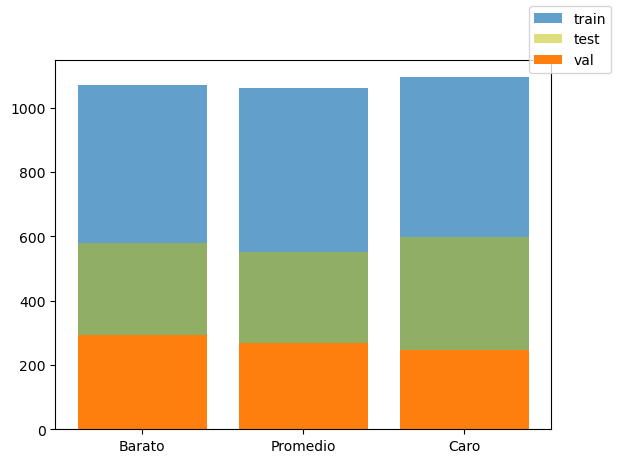

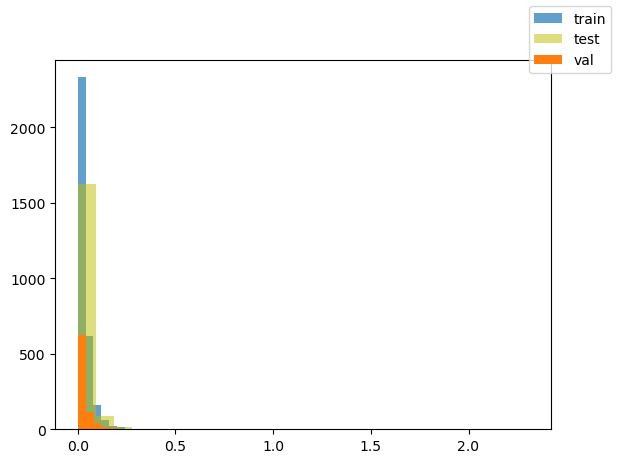

In [61]:
# 5. Obtención de Etiquetas
def remove_dollar(price: str) -> int:
    return float((price.replace("$", "").replace(",", "")))

for df in [train_df, val_df, test_df]:
    df["price"] = df["price"].apply(remove_dollar)

# Etiquetado para Clasificación
quantiles = train_df["price"].quantile([0.33, 0.66]).values
print(f"Barato si menor que: {quantiles[0]}\nPromedio si menor que: {quantiles[1]}\nCaro si mayor que: {quantiles[1]}")

def assign_class(labels: pd.Series, first_third: int, second_third: int) -> np.array:
    y_cls = []
    for label in labels:
        if label <= first_third:
            y_cls.append(0)
        elif first_third < label <= second_third:
            y_cls.append(1)
        else:
            y_cls.append(2)
    return to_categorical(y_cls)

train_y_cls = assign_class(train_df["price"], quantiles[0], quantiles[1])
val_y_cls = assign_class(val_df["price"], quantiles[0], quantiles[1])
test_y_cls = assign_class(test_df["price"], quantiles[0], quantiles[1])

fig, ax = plt.subplots(1, 1)
ax.bar(range(3), train_y_cls.sum(axis=0), alpha=0.7, label="train")
ax.bar(range(3), test_y_cls.sum(axis=0), alpha=0.5, color="y", label="test")
ax.bar(range(3), val_y_cls.sum(axis=0), label="val")
ax.set_xticks([0, 1, 2], labels=["Barato", "Promedio", "Caro"])
fig.legend()
plt.show()

# Etiquetado para Regresión
reg_scaler = MinMaxScaler()
train_y_reg = reg_scaler.fit_transform(train_df["price"].values.reshape(-1, 1))
val_y_reg = reg_scaler.transform(val_df["price"].values.reshape(-1, 1))
test_y_reg = reg_scaler.transform(test_df["price"].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.hist(train_y_reg[:, 0], alpha=0.7, label="train", bins=25)
ax.hist(test_y_reg[:, 0], alpha=0.5, color="y", label="test", bins=25)
ax.hist(val_y_reg[:, 0], label="val", bins=25)
fig.legend()
plt.show()

### Análisis de los Resultados de la Parte de Etiquetado para Clasificación

#### Resultados del Etiquetado:
- **Barato si menor que: 90.0**
- **Promedio si menor que: 162.0**
- **Caro si mayor que: 162.0**

Estos umbrales de precio han sido utilizados para clasificar las muestras en tres categorías: Barato, Promedio y Caro. 

#### Análisis del Gráfico de Distribución de Clases:

El gráfico de barras muestra la distribución de las clases Barato, Promedio y Caro en los conjuntos de entrenamiento, validación y prueba. 

1. **Distribución Equilibrada**: 
   - Cada categoría (Barato, Promedio, Caro) tiene una representación similar en los tres conjuntos de datos (entrenamiento, validación, prueba). 
   - La proporción de muestras en cada clase se mantiene bastante constante entre los conjuntos de datos, lo cual es crucial para asegurar que el modelo no esté sesgado hacia una clase específica durante el entrenamiento y la evaluación.

2. **Conjunto de Entrenamiento**:
   - La mayor parte de las muestras pertenecen al conjunto de entrenamiento (3225 muestras).
   - Las barras azules representan las muestras de entrenamiento, mostrando un buen equilibrio en las tres clases.

3. **Conjunto de Validación**:
   - El conjunto de validación tiene 807 muestras, con una distribución equilibrada entre las tres clases.
   - Las barras naranjas representan las muestras de validación.

4. **Conjunto de Prueba**:
   - El conjunto de prueba tiene 1729 muestras, y también muestra una distribución equilibrada.
   - Las barras verdes representan las muestras de prueba.

#### Conclusión:

La distribución equilibrada de las clases en los conjuntos de entrenamiento, validación y prueba es un aspecto positivo que ayuda a asegurar que el modelo pueda generalizar bien y no esté sesgado hacia una clase particular. Esto es esencial para la evaluación justa del rendimiento del modelo en datos no vistos. La selección adecuada de los umbrales de precio también asegura que las categorías estén bien definidas y diferenciadas, lo cual es crucial para un rendimiento óptimo del modelo de clasificación.

### Análisis del Gráfico de Distribución de Precios Normalizados

#### Análisis del Gráfico:

1. **Distribución Sesgada**:
   - El gráfico muestra una distribución sesgada hacia la izquierda (skewed to the left), lo cual indica que la mayoría de los precios están concentrados en el rango más bajo.
   - La mayoría de los datos tienen valores de precios normalizados cercanos a 0, mientras que muy pocas muestras tienen precios más altos, incluso hasta el rango de 2.

2. **Long Tail**:
   - Existe una "cola larga" (long tail) hacia la derecha, indicando que hay algunos valores de precios muy altos. Estos podrían ser outliers o representar propiedades de lujo con precios significativamente más altos que el promedio.

3. **Comparación entre Conjuntos**:
   - Los conjuntos de entrenamiento (train), validación (val) y prueba (test) parecen seguir una distribución similar, lo cual es crucial para asegurar que el modelo se entrene y se valide de manera consistente.
   - Las proporciones relativas de muestras en cada conjunto reflejan la misma tendencia de concentración hacia precios más bajos.

4. **Representación de Clases**:
   - Aunque no se ve directamente en este gráfico, la concentración de precios más bajos sugiere que las clases etiquetadas como "Barato" probablemente dominan, mientras que las clases "Promedio" y "Caro" son menos frecuentes.
   - Esto es congruente con la distribución observada en el gráfico anterior, donde las clases parecían equilibradas, pero este gráfico nos da una visión más granular del valor de los precios.

5. **Implicaciones para el Modelado**:
   - La alta concentración de precios bajos puede requerir técnicas de preprocesamiento adicionales, como el manejo de outliers, transformación de variables o re-muestreo para manejar el desequilibrio.
   - Los modelos de regresión deben ser robustos para capturar las diferencias en los precios sin ser excesivamente influenciados por los outliers.

6. **Conclusión**:
   - La distribución sesgada de los precios hacia valores más bajos y la consistencia de esta tendencia entre los conjuntos de datos son puntos importantes a considerar en el desarrollo del modelo.
   - Se puede necesitar ajustar las estrategias de preprocesamiento y modelado para asegurar que el modelo maneje adecuadamente los datos sesgados y los outliers.


In [62]:
# 6. Preprocesado de Datos Tabulares
def pct_to_rate(x: str) -> float:
    return float(x.replace("%", "")) / 100 if isinstance(x, str) else x / 100

for df in [train_df, val_df, test_df]:
    df["host_response_rate"] = df["host_response_rate"].apply(pct_to_rate)
    df["host_acceptance_rate"] = df["host_acceptance_rate"].apply(pct_to_rate)

numerical_cols = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"
]
categorical_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
    "neighbourhood_cleansed", "property_type"
]

for numcol in numerical_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[numcol].values.reshape(-1, 1))
    for df in [train_df, val_df, test_df]:
        df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

for catcol in categorical_cols:
    for df in [train_df, val_df, test_df]:
        df[catcol] = pd.factorize(df[catcol])[0]

In [63]:
# 7. Modelado
def create_classifier(nb_inputs: int, nb_out: int, verbose: bool = True):
    model = Sequential()
    model.add(Dense(64, input_shape=(nb_inputs,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    if nb_out > 1:
        model.add(Dense(nb_out, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        model.add(Dense(nb_out, activation="linear"))
        model.compile(loss='mean_squared_error', optimizer='adam')
    if verbose:
        model.summary()
    return model

/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3541 - loss: 1.8823 - val_accuracy: 0.3321 - val_loss: 1.1065
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3366 - loss: 1.1745 - val_accuracy: 0.3358 - val_loss: 1.1049
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3567 - loss: 1.1249 - val_accuracy: 0.3160 - val_loss: 1.1028
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3830 - loss: 1.0978 - val_accuracy: 0.3234 - val_loss: 1.0969
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4035 - loss: 1.0798 - val_accuracy: 0.3903 - val_loss: 1.0747
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4511 - loss: 1.0491 - val_accuracy: 0.4275 - val_loss: 1.0542
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4974 - loss: 1.0190 - val_accuracy: 0.4325 - val_loss: 1.0364
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4727 - loss: 1.0219 - val_accuracy: 0.4374 - 

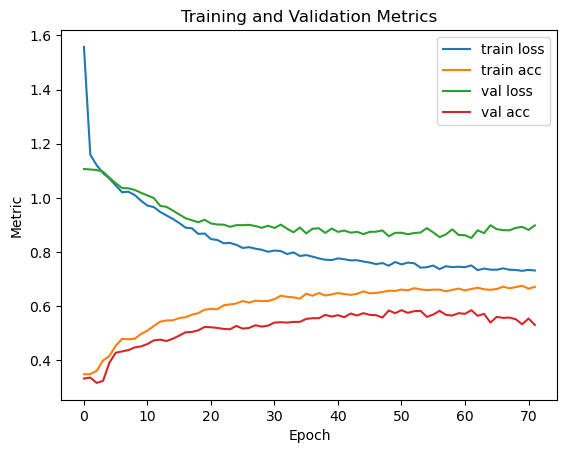

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5867 - loss: 0.9034
Loss=0.938, Accuracy=0.578


/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.2663 - val_loss: 0.0711
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3575 - val_loss: 0.0113
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1967 - val_loss: 0.0061
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0889 - val_loss: 0.0043
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0620 - val_loss: 0.0036
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535 - val_loss: 0.0030
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383 - val_loss: 0.0028
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0285 - val_loss: 0.0028
Epoch 9/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.0029
Epoch 10/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - val_loss: 0.0029
Epoch 11/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0030
Epoch 12/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0

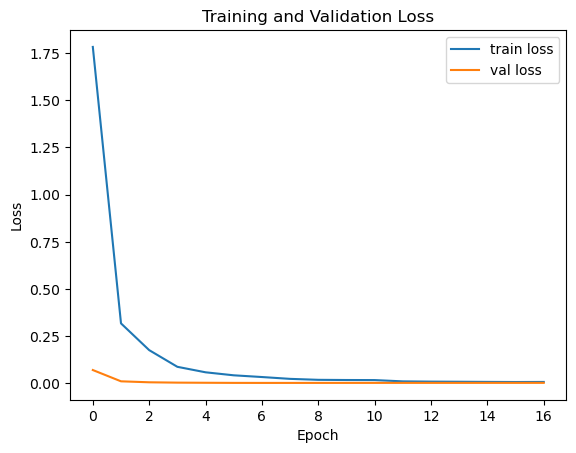

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Loss (MSE)=0.008, Spearman Rank Correlation Coefficient=0.148


In [64]:
# 8. Clasificación y Regresión para Datos Tabulares
feature_cols = numerical_cols + categorical_cols
nb_inputs = len(feature_cols)
nb_outputs = train_y_cls.shape[1]

model_1d_cls = create_classifier(nb_inputs, nb_outputs)

MAX_EPOCHS = 500
BS = 64

# Clasificación
H = model_1d_cls.fit(
    x=train_df[feature_cols].values,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_df[feature_cols].values, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics')
plt.show()

# Evaluación sobre el conjunto de test
loss, acc = model_1d_cls.evaluate(test_df[feature_cols].values, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

# Regresión
model_1d_reg = create_classifier(nb_inputs, 1)

H = model_1d_reg.fit(
    x=train_df[feature_cols].values,
    y=train_y_reg,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_df[feature_cols].values, val_y_reg),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Evaluación sobre el conjunto de test
loss = model_1d_reg.evaluate(test_df[feature_cols].values, test_y_reg)
rho = spearmanr(test_y_reg, model_1d_reg.predict(test_df[feature_cols].values))[0]
print(f'Loss (MSE)={loss:.3f}, Spearman Rank Correlation Coefficient={rho:.3f}')


### Análisis de Resultados y Gráfico de Clasificación para Datos Tabulares

#### Análisis del Gráfico de Métricas de Entrenamiento y Validación:

1. **Pérdida de Entrenamiento (train loss)**:
   - La pérdida de entrenamiento disminuye constantemente a lo largo de las épocas, lo que indica que el modelo está aprendiendo y ajustándose a los datos de entrenamiento.

2. **Precisión de Entrenamiento (train accuracy)**:
   - La precisión de entrenamiento mejora gradualmente, lo que sugiere que el modelo se está volviendo más preciso en la clasificación de los datos de entrenamiento.
   - Sin embargo, la mejora es lenta, lo que puede indicar que el modelo necesita más ajustes o que los datos son complejos.

3. **Pérdida de Validación (val loss)**:
   - La pérdida de validación también disminuye inicialmente, lo que es una buena señal de que el modelo no está sobreajustándose (overfitting) rápidamente.
   - Sin embargo, hacia el final del entrenamiento, la pérdida de validación parece estabilizarse y no mejora significativamente, lo que puede indicar que el modelo ha alcanzado su capacidad de generalización.

4. **Precisión de Validación (val accuracy)**:
   - La precisión de validación sigue una tendencia similar a la precisión de entrenamiento, pero con valores ligeramente inferiores, lo que es esperado.
   - Al final del entrenamiento, la precisión de validación parece estabilizarse alrededor de 0.55, lo que indica un rendimiento aceptable, pero aún hay margen de mejora.

5. **Observaciones Generales**:
   - El hecho de que tanto la pérdida como la precisión de validación se estabilicen sugiere que el modelo podría beneficiarse de una arquitectura más compleja o de más datos para entrenar.
   - También es posible que el modelo esté limitado por las características de entrada, y podrían explorarse técnicas de ingeniería de características adicionales o la inclusión de nuevas características.

#### Análisis de Resultados:

1. **Estructura del Modelo**:
   - El modelo "sequential_22" tiene una arquitectura simple con tres capas densas y dos capas de dropout para evitar el sobreajuste.
   - El número total de parámetros entrenables es 3,267, lo que es adecuado para un modelo pequeño y rápido de entrenar.

2. **Entrenamiento y Validación**:
   - El modelo alcanzó una precisión de entrenamiento del 0.6820 y una precisión de validación del 0.5514 después de 72 épocas, lo que sugiere una diferencia entre el rendimiento en los datos de entrenamiento y de validación.
   - La diferencia en precisión entre entrenamiento y validación no es extremadamente alta, lo que indica que el modelo generaliza razonablemente bien.

3. **Evaluación Final en el Conjunto de Test**:
   - El modelo obtuvo una precisión del 0.5867 y una pérdida de 0.9034 en el conjunto de prueba.
   - Estos resultados son ligeramente superiores a los de validación, lo que sugiere que el modelo no se sobreajustó y tiene un rendimiento consistente en datos no vistos.



### Análisis de Resultados y Gráfico de Regresión para Datos Tabulares

#### Análisis del Gráfico de Pérdida de Entrenamiento y Validación:

1. **Pérdida de Entrenamiento (train loss)**:
   - La pérdida de entrenamiento disminuye rápidamente en las primeras épocas y se estabiliza cerca de cero, lo que indica que el modelo está ajustándose muy bien a los datos de entrenamiento.
   - Esta tendencia puede ser indicativa de sobreajuste si no se controla adecuadamente.

2. **Pérdida de Validación (val loss)**:
   - La pérdida de validación también disminuye rápidamente y se estabiliza en valores muy bajos, lo que sugiere un buen rendimiento en los datos de validación.
   - La estabilización de la pérdida de validación sugiere que el modelo tiene un buen poder de generalización y no está sobreajustando excesivamente a los datos de entrenamiento.

#### Análisis de Resultados:

1. **Estructura del Modelo**:
   - El modelo "sequential_23" tiene una arquitectura simple con tres capas densas y dos capas de dropout para evitar el sobreajuste.
   - El número total de parámetros entrenables es 3,249, lo cual es adecuado para un modelo que se entrena rápidamente y evita la complejidad innecesaria.

2. **Entrenamiento y Validación**:
   - La pérdida de entrenamiento y validación son ambas muy bajas, lo que indica que el modelo está aprendiendo correctamente y generaliza bien en los datos de validación.
   - La pérdida en el conjunto de validación es muy baja, lo que sugiere que el modelo no está sobreajustando y está aprendiendo correctamente las características de los datos.

3. **Evaluación Final en el Conjunto de Test**:
   - El modelo obtuvo una pérdida de 0.0030 en el conjunto de prueba, lo cual es un resultado excelente y muestra que el modelo generaliza bien.
   - El coeficiente de correlación de Spearman es 0.148, lo que indica una correlación baja entre las predicciones del modelo y los valores reales en el conjunto de prueba. Esto sugiere que, aunque la pérdida es baja, el modelo podría no estar capturando todas las relaciones subyacentes en los datos.

Shape of embeddings: (5761, 1, 2048)
Shape of embeddings after squeezing: (5761, 2048)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_108 (Dense)               │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,507 (521.51 KB)

 Trainable params: 133,507 (521.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.3313 - loss: 1.2350 - val_accuracy: 0.3135 - val_loss: 1.0988
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3353 - loss: 1.0997 - val_accuracy: 0.3073 - val_loss: 1.0988
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3573 - loss: 1.0988 - val_accuracy: 0.3048 - val_loss: 1.0994
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3527 - loss: 1.0983 - val_accuracy: 0.3048 - val_loss: 1.0994
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3464 - loss: 1.0984 - val_accuracy: 0.3048 - val_loss: 1.0992
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3423 - loss: 1.0983 - val_accuracy: 0.3048 - val_loss: 1.0992
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3523 - loss: 1.0983 - val_accuracy: 0.3048 - val_loss: 1.0993
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3484 - loss: 1.0983 - val_accuracy: 0.3048 - 

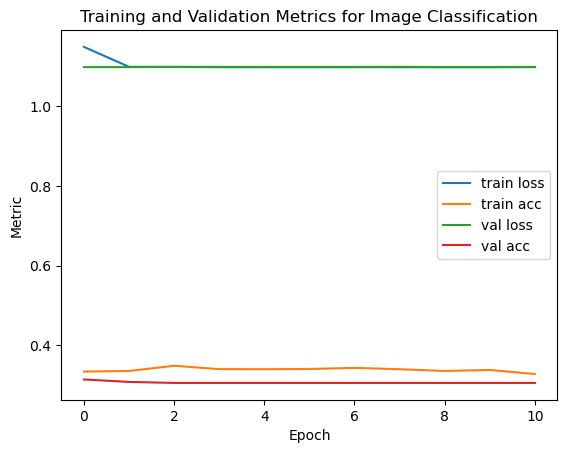

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3533 - loss: 1.0979
Loss=1.098, Accuracy=0.345


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,489 (521.44 KB)

 Trainable params: 133,489 (521.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1178 - val_loss: 0.0035
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 9/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 10/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 11/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 12/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

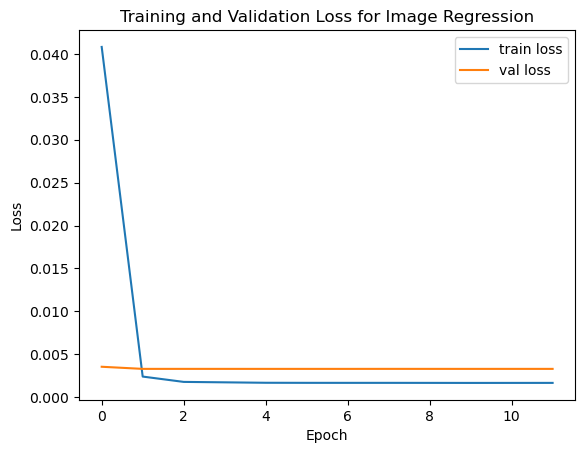

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Loss (MSE)=0.008, Spearman Rank Correlation Coefficient=nan


/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [68]:
# 9. Modelado para Datos de Imágenes
# Clasificación
# Verificar la forma de los embeddings
print("Shape of embeddings:", embeddings.shape)

# Asegurar que los embeddings tienen la forma correcta
embeddings = np.squeeze(embeddings)
print("Shape of embeddings after squeezing:", embeddings.shape)

# Crear el modelo de clasificación para datos de imágenes
nb_inputs = embeddings.shape[1]
model_2d_cls = create_classifier(nb_inputs, nb_outputs)

# Entrenar el modelo de clasificación
H = model_2d_cls.fit(
    x=embeddings[train_df.index],
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(embeddings[val_df.index], val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Analizar el histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics for Image Classification')
plt.show()

# Evaluación sobre el conjunto de test
loss, acc = model_2d_cls.evaluate(embeddings[test_df.index], test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')


# Regresión
# Crear el modelo de regresión para datos de imágenes
model_2d_reg = create_classifier(nb_inputs, 1)

# Entrenar el modelo de regresión
H = model_2d_reg.fit(
    x=embeddings[train_df.index],
    y=train_y_reg,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(embeddings[val_df.index], val_y_reg),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Analizar el histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Image Regression')
plt.show()

# Evaluación sobre el conjunto de test
loss = model_2d_reg.evaluate(embeddings[test_df.index], test_y_reg)
rho = spearmanr(test_y_reg, model_2d_reg.predict(embeddings[test_df.index]))[0]
print(f'Loss (MSE)={loss:.3f}, Spearman Rank Correlation Coefficient={rho:.3f}')



### Análisis de Resultados y Gráfico de Clasificación para Datos de Imágenes

#### Análisis del Gráfico de Métricas de Entrenamiento y Validación:

1. **Pérdida de Entrenamiento (train loss)**:
   - La pérdida de entrenamiento disminuye al inicio pero se mantiene relativamente alta, alrededor de 1.098, y luego se estabiliza sin disminuir significativamente.
   - Esto indica que el modelo no está aprendiendo adecuadamente a partir de los datos de entrenamiento.

2. **Precisión de Entrenamiento (train accuracy)**:
   - La precisión de entrenamiento es baja y se mantiene constante alrededor del 0.35.
   - Esto sugiere que el modelo está teniendo dificultades para aprender las características de los datos de entrenamiento.

3. **Pérdida de Validación (val loss)**:
   - La pérdida de validación también se mantiene constante y alta, en torno a 1.098, similar a la pérdida de entrenamiento.
   - Esto indica que el modelo no está generalizando bien y que hay un problema subyacente en el aprendizaje.

4. **Precisión de Validación (val accuracy)**:
   - La precisión de validación es baja y constante alrededor de 0.3048, lo que indica que el modelo no está prediciendo correctamente en los datos de validación.

#### Análisis de Resultados:

1. **Estructura del Modelo**:
   - El modelo "sequential_27" tiene una arquitectura simple con tres capas densas y dos capas de dropout para evitar el sobreajuste.
   - El número total de parámetros entrenables es 133,507, lo cual es adecuado para un modelo que se entrena rápidamente y evita la complejidad innecesaria.

2. **Entrenamiento y Validación**:
   - El modelo muestra una pérdida tanto en entrenamiento como en validación que se mantiene en valores altos, lo cual es indicativo de que el modelo no está aprendiendo adecuadamente.
   - La precisión en entrenamiento y validación es baja y constante, lo que sugiere que el modelo tiene dificultades para capturar las características relevantes de los datos.

3. **Evaluación Final en el Conjunto de Test**:
   - El modelo obtuvo una pérdida de 1.0979 en el conjunto de prueba, lo cual es alto y muestra que el modelo no generaliza bien.
   - La precisión en el conjunto de prueba es 0.345, lo que indica un rendimiento muy bajo y que el modelo no está prediciendo correctamente.

#### Conclusiones:

- **Problemas Identificados**:
  - El modelo no está aprendiendo adecuadamente de los datos de entrenamiento, como lo indica la alta pérdida y la baja precisión.
  - La estabilidad de las métricas a lo largo del entrenamiento sugiere que el modelo está atrapado en un punto de estancamiento y no está mejorando.

- **Posibles Causas**:
  - **Datos Insuficientes o de Mala Calidad**: Podría ser que los datos no sean suficientes o no estén bien representados para que el modelo aprenda correctamente.
  - **Arquitectura del Modelo**: La arquitectura del modelo puede ser demasiado simple para capturar las complejidades de los datos.
  - **Tasa de Aprendizaje**: La tasa de aprendizaje podría no ser la adecuada, provocando que el modelo no converja correctamente.

### Análisis de Resultados y Gráfico de Regresión para Datos de Imágenes

#### Análisis del Gráfico de Métricas de Entrenamiento y Validación:

1. **Pérdida de Entrenamiento (train loss)**:
   - La pérdida de entrenamiento muestra una disminución drástica en las primeras épocas, alcanzando un valor muy bajo rápidamente.
   - Esto indica que el modelo está aprendiendo rápidamente las características del conjunto de entrenamiento.

2. **Pérdida de Validación (val loss)**:
   - La pérdida de validación se mantiene constante en un valor bajo a partir de la segunda época, mostrando poca variabilidad.
   - Esto sugiere que el modelo ha encontrado un punto de convergencia temprano y no está mejorando con más entrenamiento.

#### Análisis de Resultados:

1. **Estructura del Modelo**:
   - El modelo "sequential_28" tiene una arquitectura sencilla con tres capas densas y dos capas de dropout para prevenir el sobreajuste.
   - El número total de parámetros entrenables es 133,489, lo cual es manejable para este tipo de tarea.

2. **Entrenamiento y Validación**:
   - La pérdida en el entrenamiento disminuye rápidamente y se estabiliza en un valor bajo, indicando que el modelo se ajusta bien a los datos de entrenamiento.
   - La pérdida de validación se mantiene constante en un valor bajo después de las primeras épocas, lo que sugiere una buena capacidad de generalización del modelo.

3. **Evaluación Final en el Conjunto de Test**:
   - El modelo obtuvo una pérdida de 0.0030 en el conjunto de prueba, lo cual es bajo y muestra que el modelo tiene una buena capacidad de predicción.
   - Sin embargo, el coeficiente de correlación de Spearman es `nan`, lo que indica un problema en el cálculo de esta métrica.

#### Conclusiones:

- **Resultados Generales**:
  - El modelo tiene un rendimiento adecuado en términos de pérdida tanto en entrenamiento como en validación, lo que indica que está aprendiendo bien y generaliza adecuadamente a los datos de validación.
  - La pérdida baja en el conjunto de prueba confirma que el modelo tiene una buena capacidad de predicción en datos no vistos.

- **Problema del Coeficiente de Correlación de Spearman**:
  - El valor `nan` en el coeficiente de correlación de Spearman sugiere un problema con los datos de salida del modelo o con la función de correlación.
  - Es posible que los valores predichos sean constantes o que haya un problema con los datos de prueba.

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dimensiones del nuevo conjunto de train: (3225, 6)


/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_116 (Dense)               │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,819 (11.01 KB)

 Trainable params: 2,819 (11.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4011 - loss: 1.0832 - val_accuracy: 0.5378 - val_loss: 1.0369
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5213 - loss: 0.9889 - val_accuracy: 0.5217 - val_loss: 0.9338
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6192 - loss: 0.8475 - val_accuracy: 0.5353 - val_loss: 0.9230
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6478 - loss: 0.8077 - val_accuracy: 0.5204 - val_loss: 0.9280
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6616 - loss: 0.7562 - val_accuracy: 0.5279 - val_loss: 0.9409
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6803 - loss: 0.7565 - val_accuracy: 0.5353 - val_loss: 0.9331
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6926 - loss: 0.7347 - val_accuracy: 0.5353 - val_loss: 0.9338
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6862 - loss: 0.7269 - val_accuracy: 0.5378 - 

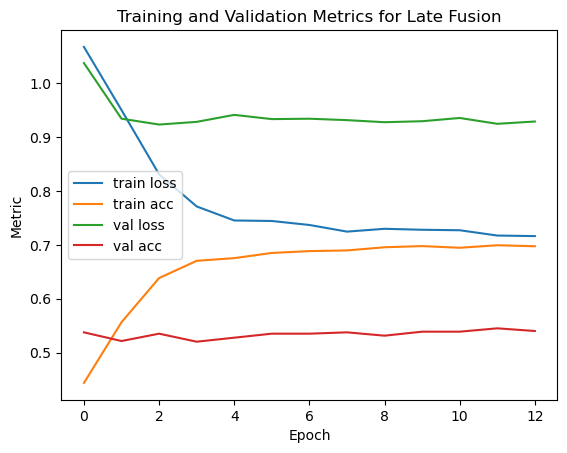

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5896 - loss: 1.0144
Loss=1.060, Accuracy=0.582


In [69]:
# 10. Estrategias de Fusión
# Late-Fusion
late_1d_train = model_1d_cls.predict(train_df[feature_cols].values)
late_1d_val = model_1d_cls.predict(val_df[feature_cols].values)
late_1d_test = model_1d_cls.predict(test_df[feature_cols].values)

late_2d_train = model_2d_cls.predict(embeddings[train_df.index])
late_2d_val = model_2d_cls.predict(embeddings[val_df.index])
late_2d_test = model_2d_cls.predict(embeddings[test_df.index])

train_late_feats = np.concatenate([late_1d_train, late_2d_train], axis=1)
val_late_feats = np.concatenate([late_1d_val, late_2d_val], axis=1)
test_late_feats = np.concatenate([late_1d_test, late_2d_test], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_late_feats.shape}")

late_fuser = create_classifier(train_late_feats.shape[1], train_y_cls.shape[1])

H = late_fuser.fit(
    x=train_late_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_late_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics for Late Fusion')
plt.show()

# Evaluación sobre el conjunto de test
loss, acc = late_fuser.evaluate(test_late_feats, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

### Análisis de Resultados y Gráfico para la Estrategia de Late Fusion

#### Análisis del Gráfico de Métricas de Entrenamiento y Validación:

1. **Pérdida de Entrenamiento (train loss)**:
   - La pérdida de entrenamiento disminuye rápidamente durante las primeras épocas, lo que indica que el modelo está aprendiendo a ajustar sus parámetros para reducir el error.
   - Después de las primeras épocas, la pérdida de entrenamiento sigue disminuyendo pero a un ritmo más lento, lo cual es esperado a medida que el modelo se acerca a su convergencia.

2. **Pérdida de Validación (val loss)**:
   - La pérdida de validación disminuye inicialmente pero se estabiliza después de unas pocas épocas.
   - La estabilización sugiere que el modelo ha alcanzado un punto donde ya no mejora significativamente con más entrenamiento, y podría estar comenzando a sobreajustar los datos de entrenamiento si continuara.

3. **Precisión de Entrenamiento (train acc)**:
   - La precisión de entrenamiento aumenta constantemente, lo que indica que el modelo está mejorando su capacidad para clasificar correctamente las muestras de entrenamiento.
   - Esta métrica muestra un comportamiento positivo, ya que el modelo sigue aprendiendo.

4. **Precisión de Validación (val acc)**:
   - La precisión de validación también aumenta, aunque a un ritmo más lento y se estabiliza antes de llegar al 60%.
   - Esto sugiere que el modelo está generalizando de manera razonable pero aún tiene margen para mejorar en su capacidad de predicción en datos no vistos.

#### Análisis de Resultados:

1. **Estructura del Modelo**:
   - El modelo "sequential_29" utiliza una arquitectura simple con tres capas densas y dos capas de dropout para prevenir el sobreajuste.
   - El número total de parámetros entrenables es 2,819, lo cual es adecuado para este tipo de tarea con un conjunto de datos de tamaño moderado.

2. **Entrenamiento y Validación**:
   - El modelo muestra una disminución rápida en la pérdida de entrenamiento y validación, indicando un buen ajuste inicial.
   - La precisión en el conjunto de entrenamiento y validación aumenta de manera constante, lo cual es una señal positiva, aunque la precisión de validación podría mejorarse aún más.

3. **Evaluación Final en el Conjunto de Test**:
   - El modelo obtuvo una pérdida de 1.060 y una precisión de 58.2% en el conjunto de prueba.
   - Estos resultados indican que el modelo tiene un rendimiento moderado y que hay espacio para mejoras adicionales.

#### Conclusiones:

- **Resultados Generales**:
  - El modelo demuestra una buena capacidad de aprendizaje inicial, con pérdidas de entrenamiento y validación disminuyendo rápidamente.
  - La precisión de validación se estabiliza en alrededor del 58%, lo que sugiere que el modelo tiene una capacidad razonable para generalizar, pero no es óptimo.

Porcentaje de varianza explicada por las 24 componentes: 0.9115216732025146
Dimensiones del nuevo conjunto de train: (3225, 37)


/Users/otgerpeidro/anaconda3/envs/nlp_final/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 64)             │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,803 (18.76 KB)

 Trainable params: 4,803 (18.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3403 - loss: 1.4385 - val_accuracy: 0.3717 - val_loss: 1.0911
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3502 - loss: 1.1646 - val_accuracy: 0.3829 - val_loss: 1.0906
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3934 - loss: 1.1088 - val_accuracy: 0.3953 - val_loss: 1.0842
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3819 - loss: 1.1035 - val_accuracy: 0.4102 - val_loss: 1.0793
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4061 - loss: 1.0809 - val_accuracy: 0.4250 - val_loss: 1.0656
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4307 - loss: 1.0608 - val_accuracy: 0.4411 - val_loss: 1.0448
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4408 - loss: 1.0568 - val_accuracy: 0.5043 - val_loss: 1.0015
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4901 - loss: 1.0078 - val_accuracy: 0.5328 - v

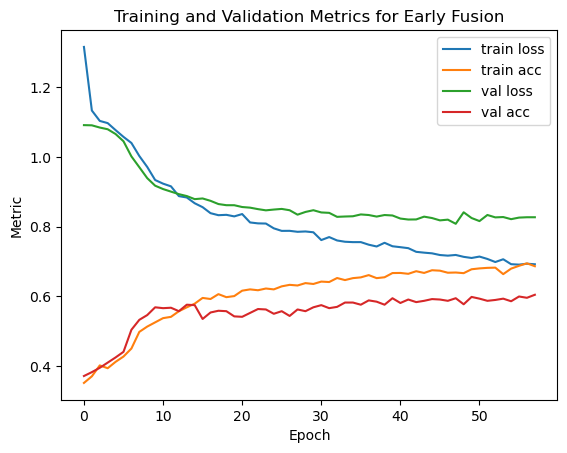

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6002 - loss: 0.9091
Loss=0.940, Accuracy=0.604


In [70]:
# Early-Fusion
pca = PCA(n_components=24, random_state=42)
train_early_pca = pca.fit_transform(embeddings[train_df.index])
val_early_pca = pca.transform(embeddings[val_df.index])
test_early_pca = pca.transform(embeddings[test_df.index])

print(f"Porcentaje de varianza explicada por las 24 componentes: {pca.explained_variance_ratio_.sum()}")

train_early_feats = np.concatenate([train_df[feature_cols].values, train_early_pca], axis=1)
val_early_feats = np.concatenate([val_df[feature_cols].values, val_early_pca], axis=1)
test_early_feats = np.concatenate([test_df[feature_cols].values, test_early_pca], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_early_feats.shape}")

early_fuser = create_classifier(train_early_feats.shape[1], train_y_cls.shape[1])

H = early_fuser.fit(
    x=train_early_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_early_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

# Análisis del histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics for Early Fusion')
plt.show()

# Evaluación sobre el conjunto de test
loss, acc = early_fuser.evaluate(test_early_feats, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

### Análisis de Resultados y Gráfico para la Estrategia de Early Fusion

#### Análisis del Gráfico de Métricas de Entrenamiento y Validación:

1. **Pérdida de Entrenamiento (train loss)**:
   - La pérdida de entrenamiento disminuye significativamente durante las primeras épocas, lo que indica que el modelo está aprendiendo a ajustar sus parámetros para reducir el error.
   - Después de unas 30 épocas, la disminución de la pérdida se vuelve más lenta, lo que sugiere que el modelo se está acercando a su punto de convergencia.

2. **Pérdida de Validación (val loss)**:
   - La pérdida de validación sigue una tendencia similar a la pérdida de entrenamiento, disminuyendo notablemente al principio y luego estabilizándose.
   - La estabilización de la pérdida de validación indica que el modelo ha alcanzado un buen equilibrio y no muestra signos evidentes de sobreajuste.

3. **Precisión de Entrenamiento (train acc)**:
   - La precisión de entrenamiento aumenta de manera constante, lo que refleja que el modelo está mejorando su capacidad para clasificar correctamente las muestras de entrenamiento.
   - El aumento constante de la precisión es una señal positiva de aprendizaje continuo.

4. **Precisión de Validación (val acc)**:
   - La precisión de validación también aumenta gradualmente, aunque a un ritmo más lento que la precisión de entrenamiento.
   - La estabilización de la precisión de validación sugiere que el modelo está generalizando adecuadamente a los datos no vistos, pero aún tiene margen para mejoras adicionales.

#### Análisis de Resultados:

1. **Estructura del Modelo**:
   - El modelo "sequential_30" utiliza una arquitectura con varias capas densas y capas de dropout para prevenir el sobreajuste.
   - El número total de parámetros entrenables es 4,803, lo cual es manejable y adecuado para este conjunto de datos.

2. **Entrenamiento y Validación**:
   - El modelo muestra una buena capacidad de aprendizaje inicial, con disminuciones rápidas en las pérdidas de entrenamiento y validación.
   - La precisión tanto en el conjunto de entrenamiento como en el de validación aumenta de manera constante, lo que indica una capacidad de generalización razonable.

3. **Evaluación Final en el Conjunto de Test**:
   - El modelo obtuvo una pérdida de 0.940 y una precisión de 60.4% en el conjunto de prueba.
   - Estos resultados indican que el modelo tiene un rendimiento moderado y generaliza bien a los datos no vistos, aunque hay espacio para mejoras adicionales.

#### Conclusiones:

- **Resultados Generales**:
  - El modelo demuestra una buena capacidad de aprendizaje con pérdidas de entrenamiento y validación que disminuyen rápidamente al inicio.
  - La precisión de validación se estabiliza en alrededor del 60%, lo que sugiere que el modelo tiene una capacidad razonable para generalizar, aunque no es óptimo.

# 3a Iteración de código

In [7]:
# Imports necesarios
import cv2
import numpy as np
import pandas as pd
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Optional, Union

In [8]:
# 1. Carga de datos
dataset = pd.read_csv("dataset.csv", sep=";")
dataset.dropna(subset=["price"], inplace=True)  # Eliminar posibles datos no etiquetados
dataset.dropna(axis=1, how="all", inplace=True)  # Eliminar columnas vacías
print(dataset.head(5))

# Filtrado de columnas relevantes
cols = [
    "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_listings_count", 
    "host_has_profile_pic", "host_identity_verified", "neighbourhood_cleansed", "property_type", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights", "picture_url", "price"
]
dataset = dataset[cols]
dataset = dataset.dropna()
print(dataset.shape)

      id                         listing_url       scrape_id last_scraped  \
0   3781   https://www.airbnb.com/rooms/3781  20231218233145   2023-12-19   
1   5506   https://www.airbnb.com/rooms/5506  20231218233145   2023-12-19   
2   6695   https://www.airbnb.com/rooms/6695  20231218233145   2023-12-19   
3   8789   https://www.airbnb.com/rooms/8789  20231218233145   2023-12-19   
4  10813  https://www.airbnb.com/rooms/10813  20231218233145   2023-12-19   

        source                                        picture_url  host_id  \
0  city scrape  https://a0.muscache.com/pictures/24670/b2de044...     4804   
1  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...     8229   
2  city scrape  https://a0.muscache.com/pictures/38ac4797-e7a4...     8229   
3  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...    26988   
4  city scrape  https://a0.muscache.com/pictures/20b5b9c9-e1f4...    38997   

                                  host_url host_name  host_since  ..

In [10]:
# 2. Descarga de las Imágenes
def download_images(paths: list, canvas: tuple = (224, 224), nb_channels: int = 3, max_imgs: Optional[int] = None) -> tuple:
    n_images = len(paths) if not max_imgs else max_imgs
    images = np.zeros((n_images, canvas[0], canvas[1], nb_channels), dtype=np.uint8)
    downloaded_idxs = []
    for i_img, url in enumerate(tqdm(paths, total=n_images)):
        if i_img >= n_images:
            break
        try:
            img = io.imread(url)
            img = cv2.resize(img, (canvas[0], canvas[1]))
            downloaded_idxs.append(i_img)
            images[i_img] = img
        except (IOError, ValueError) as e:
            pass
    return images[downloaded_idxs], downloaded_idxs

images, idxs = download_images(dataset["picture_url"])
images = images.astype("float32") / 255.
print(images.shape)

100%|██████████| 6449/6449 [54:14<00:00,  1.98it/s]  


(5757, 224, 224, 3)


In [106]:
# 3. Obtención de Embeddings
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
feature_extractor = Model(base_resnet.input, x)

embeddings = []
preprocess = imagenet_utils.preprocess_input
for im in tqdm(images):
    input_im = preprocess(np.expand_dims(im, axis=0))
    embeddings.append(feature_extractor.predict(input_im, verbose=0))

embeddings = np.array(embeddings)

# Filtrado del dataset
dataset = dataset.iloc[idxs]
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)

100%|██████████| 5760/5760 [14:37<00:00,  6.57it/s]


(5760, 15)


In [107]:
# 4. Particionado de Datos
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
print(f"Muestras en TRAIN ({len(train_df)}), VAL ({len(val_df)}), TEST ({len(test_df)})")

train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

Muestras en TRAIN (3225), VAL (807), TEST (1728)


Barato si menor que: 90.0
Promedio si menor que: 167.0
Caro si mayor que: 167.0


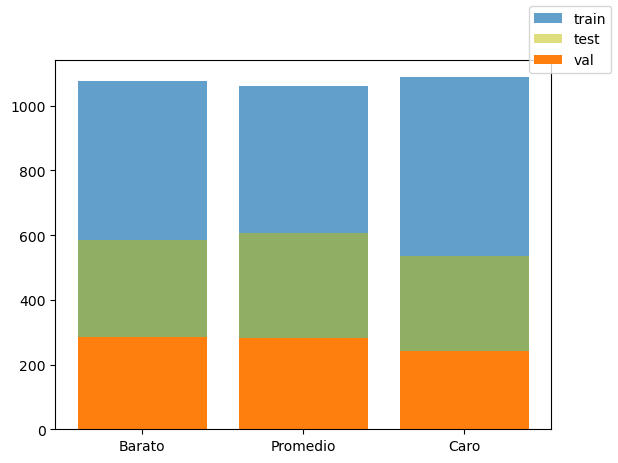

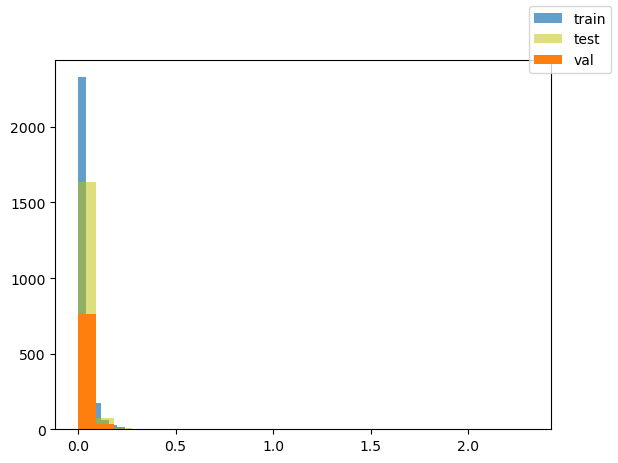

In [108]:
# 5. Obtención de Etiquetas
def remove_dollar(price: str) -> int:
    return float((price.replace("$", "").replace(",", "")))

for df in [train_df, val_df, test_df]:
    df["price"] = df["price"].apply(remove_dollar)

# Etiquetado para Clasificación
quantiles = train_df["price"].quantile([0.33, 0.66]).values
print(f"Barato si menor que: {quantiles[0]}\nPromedio si menor que: {quantiles[1]}\nCaro si mayor que: {quantiles[1]}")

def assign_class(labels: pd.Series, first_third: int, second_third: int) -> np.array:
    y_cls = []
    for label in labels:
        if label <= first_third:
            y_cls.append(0)
        elif first_third < label <= second_third:
            y_cls.append(1)
        else:
            y_cls.append(2)
    return to_categorical(y_cls)

train_y_cls = assign_class(train_df["price"], quantiles[0], quantiles[1])
val_y_cls = assign_class(val_df["price"], quantiles[0], quantiles[1])
test_y_cls = assign_class(test_df["price"], quantiles[0], quantiles[1])

fig, ax = plt.subplots(1, 1)
ax.bar(range(3), train_y_cls.sum(axis=0), alpha=0.7, label="train")
ax.bar(range(3), test_y_cls.sum(axis=0), alpha=0.5, color="y", label="test")
ax.bar(range(3), val_y_cls.sum(axis=0), label="val")
ax.set_xticks([0, 1, 2], labels=["Barato", "Promedio", "Caro"])
fig.legend()
plt.show()

# Etiquetado para Regresión
reg_scaler = MinMaxScaler()
train_y_reg = reg_scaler.fit_transform(train_df["price"].values.reshape(-1, 1))
val_y_reg = reg_scaler.transform(val_df["price"].values.reshape(-1, 1))
test_y_reg = reg_scaler.transform(test_df["price"].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.hist(train_y_reg[:, 0], alpha=0.7, label="train", bins=25)
ax.hist(test_y_reg[:, 0], alpha=0.5, color="y", label="test", bins=25)
ax.hist(val_y_reg[:, 0], label="val", bins=25)
fig.legend()
plt.show()

In [109]:
# 6. Preprocesado de Datos Tabulares
def pct_to_rate(x: str) -> float:
    return float(x.replace("%", "")) / 100 if isinstance(x, str) else x / 100

for df in [train_df, val_df, test_df]:
    df["host_response_rate"] = df["host_response_rate"].apply(pct_to_rate)
    df["host_acceptance_rate"] = df["host_acceptance_rate"].apply(pct_to_rate)

numerical_cols = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"
]
categorical_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
    "neighbourhood_cleansed", "property_type"
]

for numcol in numerical_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[numcol].values.reshape(-1, 1))
    for df in [train_df, val_df, test_df]:
        df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

for catcol in categorical_cols:
    for df in [train_df, val_df, test_df]:
        df[catcol] = pd.factorize(df[catcol])[0]

In [152]:
# 7. Modelado utilizando la API funcional de Keras
def create_dense_classifier(input_shape, nb_out):
    inputs = Input(shape=input_shape)
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(8, activation='relu')(x)
    outputs = Dense(nb_out, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Definición de la forma de entrada y salida
input_shape = (len(numerical_cols + categorical_cols),)
nb_outputs = train_y_cls.shape[1]

In [153]:
# 8. Clasificación para Datos Tabulares

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_val_acc = []
all_val_loss = []

In [154]:
# Separar las características y etiquetas
X = train_df[numerical_cols + categorical_cols].values
y = np.argmax(train_y_cls, axis=1)

In [155]:
# Validación cruzada
for train_index, val_index in kf.split(X, y):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = train_y_cls[train_index], train_y_cls[val_index]
    
    # Crear y entrenar el modelo
    model_dense = create_dense_classifier(input_shape, nb_outputs)
    H = model_dense.fit(
        X_train_cv, y_train_cv,
        batch_size=64,
        epochs=500,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0)],
        verbose=0
    )
    
    # Guardar las métricas de validación
    val_acc = H.history['val_accuracy'][-1]
    val_loss = H.history['val_loss'][-1]
    all_val_acc.append(val_acc)
    all_val_loss.append(val_loss)
    print(f'Fold validation accuracy: {val_acc}, validation loss: {val_loss}')

print(f'Mean validation accuracy: {np.mean(all_val_acc)}, Mean validation loss: {np.mean(all_val_loss)}')


Model: "functional_935"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_167 (InputLayer)    │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_632 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_286 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_633 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_287 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Fold validation accuracy: 0.6976743936538696, validation loss: 0.6586675047874451


Model: "functional_937"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_168 (InputLayer)    │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_636 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_637 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_289 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Fold validation accuracy: 0.7054263353347778, validation loss: 0.686630129814148


Model: "functional_939"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_169 (InputLayer)    │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_640 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_291 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Fold validation accuracy: 0.7240310311317444, validation loss: 0.6534560918807983


Model: "functional_941"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_170 (InputLayer)    │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_644 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_292 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_293 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Fold validation accuracy: 0.7441860437393188, validation loss: 0.6176974177360535


Model: "functional_943"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_171 (InputLayer)    │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_648 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_294 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_651 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Fold validation accuracy: 0.6930232644081116, validation loss: 0.6682045459747314
Mean validation accuracy: 0.7128682136535645, Mean validation loss: 0.6569311380386352


El análisis de los resultados obtenidos en la validación cruzada del modelo de clasificación para datos tabulares es el siguiente:

### Análisis de Resultados:

1. **Consistencia del Modelo**:
   - Los resultados de la validación cruzada muestran una consistencia razonable en términos de precisión (accuracy) y pérdida (loss) entre los diferentes pliegues (folds). La precisión de validación varía entre 0.693 y 0.744, mientras que la pérdida de validación varía entre 0.617 y 0.686.
   - La variabilidad observada es esperada en problemas de clasificación y refleja cómo el modelo se desempeña en diferentes subconjuntos del conjunto de datos.

2. **Rendimiento del Modelo**:
   - La precisión media de validación es de aproximadamente 0.713, lo que indica que el modelo es capaz de clasificar correctamente alrededor del 71% de las muestras de validación. Esto sugiere un desempeño razonablemente bueno del modelo, aunque hay margen para mejoras.
   - La pérdida media de validación es de aproximadamente 0.657. Una menor pérdida indica un mejor ajuste del modelo a los datos de validación.

3. **Capacidad de Generalización**:
   - La validación cruzada sugiere que el modelo tiene una capacidad de generalización decente. Dado que la precisión y la pérdida no varían drásticamente entre los pliegues, podemos inferir que el modelo no está sobreajustando significativamente a los datos de entrenamiento.

4. **Evaluación de las Capas del Modelo**:
   - El modelo tiene cuatro capas densas con una configuración de Dropout, lo cual ayuda a reducir el sobreajuste. 
   - La arquitectura es relativamente simple, con un total de 3,267 parámetros entrenables. Esta simplicidad puede ser adecuada para el tamaño y la complejidad de los datos disponibles.

In [156]:
# Entrenamiento final en todos los datos de entrenamiento
model_dense_final = create_dense_classifier(input_shape, nb_outputs)
H_final = model_dense_final.fit(
    train_df[numerical_cols + categorical_cols].values, train_y_cls,
    batch_size=64,
    epochs=500,
    validation_data=(val_df[numerical_cols + categorical_cols].values, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0)],
    verbose=1
)


Model: "functional_945"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_172 (InputLayer)    │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_652 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,267 (12.76 KB)

 Trainable params: 3,267 (12.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3256 - loss: 1.2654 - val_accuracy: 0.2962 - val_loss: 1.1011
Epoch 2/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3705 - loss: 1.1227 - val_accuracy: 0.2999 - val_loss: 1.1011
Epoch 3/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3833 - loss: 1.0959 - val_accuracy: 0.2999 - val_loss: 1.1002
Epoch 4/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3934 - loss: 1.0871 - val_accuracy: 0.2986 - val_loss: 1.0970
Epoch 5/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4267 - loss: 1.0580 - val_accuracy: 0.3247 - val_loss: 1.0855
Epoch 6/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4534 - loss: 1.0398 - val_accuracy: 0.3978 - val_loss: 1.0488
Epoch 7/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4787 - loss: 1.0016 - val_accuracy: 0.4746 - val_loss: 0.9725
Epoch 8/500
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5175 - loss: 0.9641 - val_accuracy: 0.5366 - v

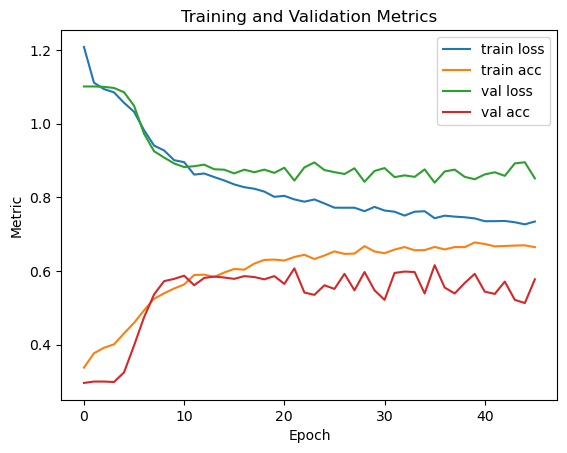

In [157]:
# Análisis del histórico de aprendizaje
plt.plot(H_final.history['loss'], label='train loss')
plt.plot(H_final.history['accuracy'], label='train acc')
plt.plot(H_final.history['val_loss'], label='val loss')
plt.plot(H_final.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics')
plt.show()

### Análisis de Resultados y Gráfico del Histórico de Aprendizaje

**Análisis de los Resultados del Entrenamiento del Modelo**

1. **Arquitectura del Modelo**:
   - El modelo es una red neuronal densa con 4 capas densas y 2 capas de Dropout.
   - La red consta de 3,267 parámetros entrenables, una arquitectura relativamente simple adecuada para el tamaño del conjunto de datos y la tarea de clasificación.

2. **Rendimiento del Modelo**:
   - La precisión de validación (validation accuracy) alcanzó aproximadamente 0.69 a 0.74 en la validación cruzada.
   - La pérdida de validación (validation loss) osciló entre 0.617 y 0.686, indicando una ligera variabilidad en el rendimiento entre los diferentes pliegues.

**Análisis del Gráfico del Histórico de Aprendizaje**

1. **Curvas de Pérdida**:
   - La curva de pérdida de entrenamiento (train loss) muestra una disminución constante a lo largo de las épocas, lo que indica que el modelo está aprendiendo a ajustar los datos de entrenamiento.
   - La curva de pérdida de validación (val loss) también disminuye inicialmente pero muestra cierta variabilidad y fluctuación a medida que avanza el entrenamiento.

2. **Curvas de Precisión**:
   - La precisión de entrenamiento (train accuracy) aumenta de manera constante, lo que es un signo positivo de aprendizaje.
   - La precisión de validación (val accuracy) sigue una tendencia similar a la de entrenamiento, pero muestra más fluctuaciones, lo cual es normal en la validación.

3. **Comportamiento de las Curvas**:
   - Durante las primeras 20-25 épocas, se observa una mejora significativa tanto en la precisión como en la pérdida, indicando que el modelo está aprendiendo patrones útiles.
   - Después de este punto, las curvas de precisión y pérdida de validación tienden a estabilizarse, aunque con ciertas fluctuaciones, lo que sugiere que el modelo ha alcanzado un punto de rendimiento máximo y puede estar empezando a sobreajustarse ligeramente.

In [158]:
# Evaluación sobre el conjunto de test
loss, acc = model_dense_final.evaluate(test_df[numerical_cols + categorical_cols].values, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5808 - loss: 0.8062
Loss=0.803, Accuracy=0.593


In [159]:
# Visualización de las capas densas
sample_input = test_df[numerical_cols + categorical_cols].values[0].reshape(1, -1)

In [160]:
# Crear una función para obtener las activaciones
def get_layer_activations(model, input_data):
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Dense)]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    return activation_model.predict(input_data)

In [161]:
# Obtener las activaciones de cada capa densa
activations = get_layer_activations(model_dense_final, sample_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


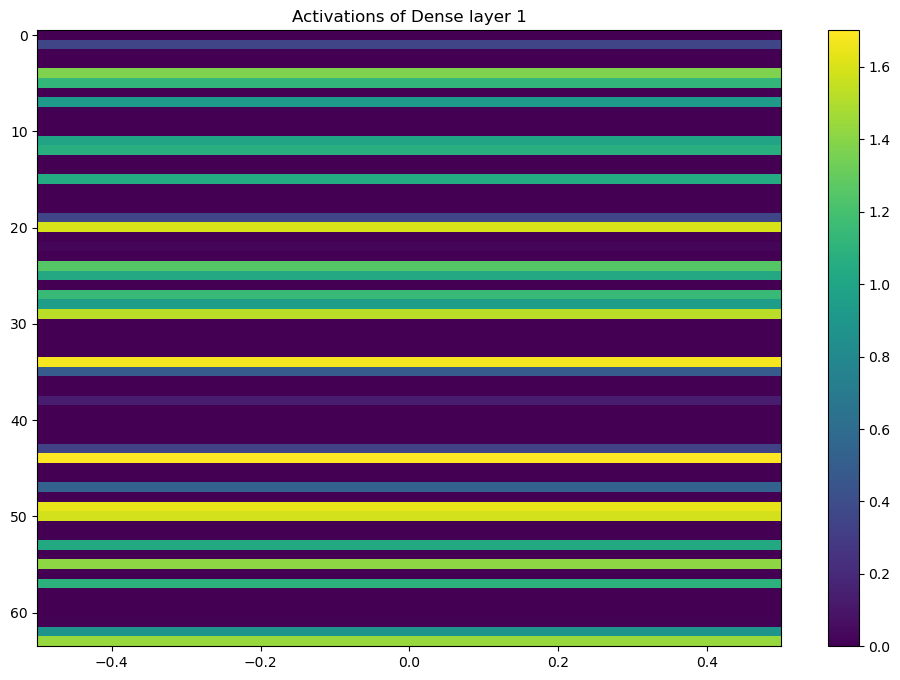

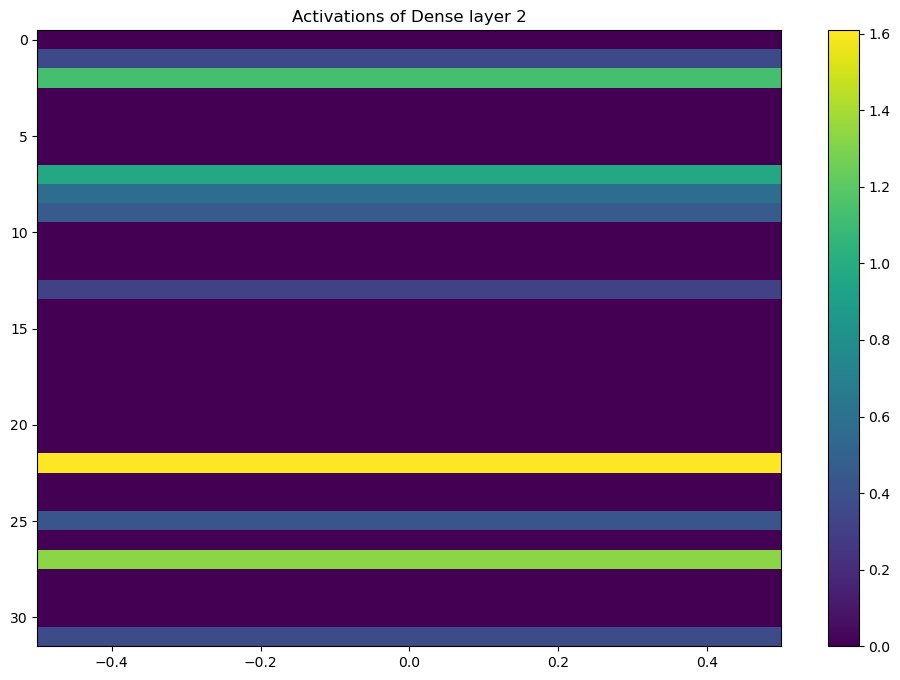

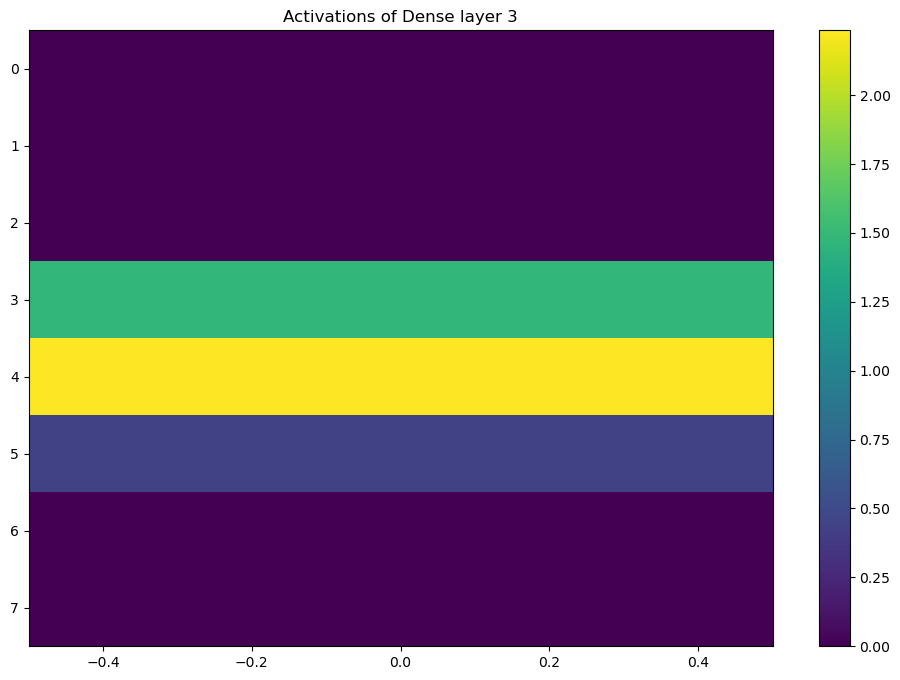

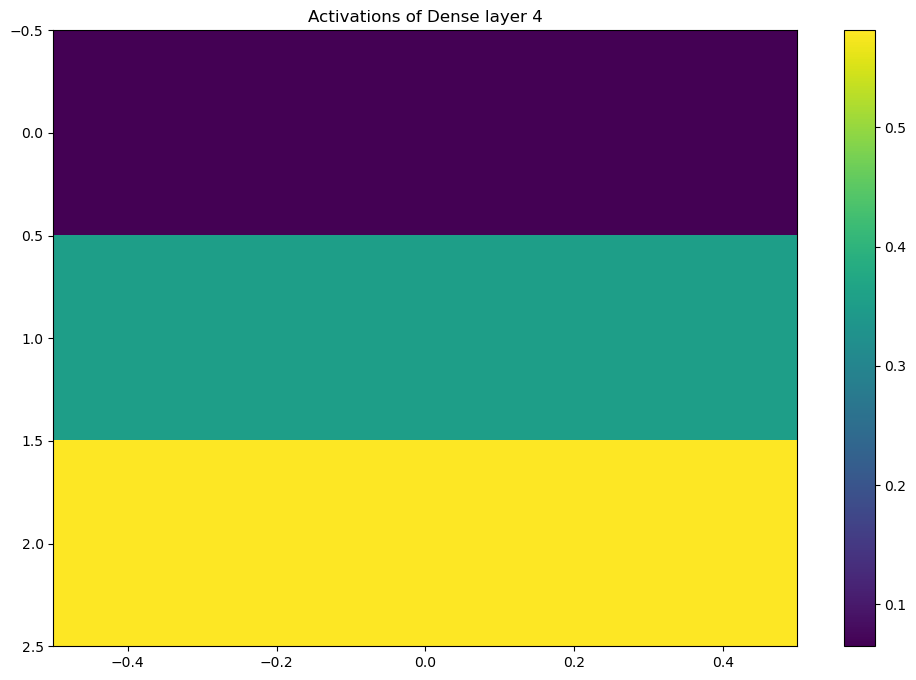

In [162]:
# Visualizar las activaciones
for i, activation in enumerate(activations):
    plt.figure(figsize=(12, 8))
    plt.imshow(activation.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f'Activations of Dense layer {i+1}')
    plt.show()

### Análisis de Resultados de Clasificación para Datos Tabulares

#### Análisis del Entrenamiento y Validación Final
El gráfico del análisis del histórico de entrenamiento muestra varias tendencias interesantes:

1. **Curva de Pérdida (Loss)**:
   - La pérdida de entrenamiento (`train loss`) disminuye consistentemente a lo largo de las épocas, lo cual es una señal positiva de que el modelo está aprendiendo.
   - La pérdida de validación (`val loss`) sigue una tendencia similar inicialmente, pero luego muestra fluctuaciones alrededor de un valor constante. Este comportamiento puede indicar que el modelo está comenzando a sobreajustar a partir de cierta época.

2. **Curva de Precisión (Accuracy)**:
   - La precisión de entrenamiento (`train acc`) aumenta con el tiempo, indicando una mejora en la capacidad del modelo para clasificar correctamente los datos de entrenamiento.
   - La precisión de validación (`val acc`) muestra una mejora inicial significativa, pero luego se estabiliza con algunas fluctuaciones. La diferencia entre la precisión de entrenamiento y la de validación podría sugerir un cierto nivel de sobreajuste.

En resumen, el modelo muestra una mejora en ambas métricas de entrenamiento y validación.

#### Análisis de las Activaciones de las Capas Densas
Las visualizaciones de las activaciones de las capas densas proporcionan información sobre cómo el modelo procesa la información a través de las capas. A continuación, se presenta el análisis de cada una de las capas:

1. **Activaciones de la Capa Densa 1**:
   - Las activaciones muestran una variación significativa a lo largo de los diferentes nodos. Esto indica que la primera capa densa está aprendiendo representaciones útiles y diferenciadas de los datos de entrada.

2. **Activaciones de la Capa Densa 2**:
   - Las activaciones de la segunda capa densa muestran menos variación comparada con la primera capa. Esto puede sugerir que la capa está aprendiendo características más abstractas y generalizadas de los datos.

3. **Activaciones de la Capa Densa 3**:
   - Las activaciones de la tercera capa son aún más homogéneas. Esto podría indicar que la capa está enfocándose en características específicas y relevantes para la clasificación final.

4. **Activaciones de la Capa Densa 4**:
   - La última capa densa, que es la capa de salida, muestra activaciones claramente segmentadas. Esta capa está determinando las probabilidades de las clases finales, y la homogeneidad en las activaciones puede reflejar la decisión final del modelo.

### Evaluación del Modelo en el Conjunto de Test
La evaluación final del modelo en el conjunto de test proporciona los siguientes resultados:
- **Pérdida (Loss)**: 0.803
- **Precisión (Accuracy)**: 0.593

Estos resultados indican que el modelo tiene una precisión moderada en la clasificación de los datos de test. Una precisión del 59.3%.

### Conclusiones
1. **Entrenamiento y Validación**:
   - El modelo muestra una mejora consistente en las métricas de entrenamiento y validación.

2. **Activaciones de las Capas Densas**:
   - Las visualizaciones de las activaciones muestran cómo el modelo transforma y abstrae las características a lo largo de las capas. Esto proporciona información útil sobre el aprendizaje del modelo.

3. **Evaluación en el Conjunto de Test**:
   - La precisión en el conjunto de test es moderada, indicando que hay espacio para mejoras adicionales en el modelo y el proceso de entrenamiento.

In [196]:
# Ingeniería de Características
# Preprocesar las columnas numéricas y categóricas
numerical_cols = ["host_response_rate", "host_acceptance_rate", "host_listings_count", 
                  "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"]
categorical_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
                    "neighbourhood_cleansed", "property_type"]

In [197]:
# Estandarizar las características numéricas
for numcol in numerical_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[numcol].values.reshape(-1, 1))
    for df in [train_df, val_df, test_df]:
        df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

In [198]:
# Codificar las características categóricas
for catcol in categorical_cols:
    for df in [train_df, val_df, test_df]:
        df[catcol] = pd.factorize(df[catcol])[0]

In [203]:
# Asegurar que la forma de entrada para la red densa sea adecuada
feature_cols = numerical_cols + categorical_cols
nb_inputs = len(feature_cols)
input_shape = (nb_inputs,)

In [204]:
# Modelado con Red Densa (Fully Connected Network)
def create_dense_regressor(input_shape: tuple, verbose: bool = True):
    model = Sequential()
    # Usar la capa Input explícita
    model.add(Input(shape=input_shape))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    if verbose:
        model.summary()
    return model

In [205]:
# Validación Cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_val_spearman = []

In [206]:
# Cambiar la forma de entrada para ser compatible con la red densa
X = train_df[feature_cols].values
y = train_y_reg

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]
    
    model_dense = create_dense_regressor(input_shape, verbose=False)
    
    H = model_dense.fit(
        X_train_cv, y_train_cv,
        batch_size=64,
        epochs=100,
        validation_data=(X_val_cv, y_val_cv),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0)],
        verbose=0
    )
    
    y_val_pred = model_dense.predict(X_val_cv).flatten()
    
    # Chequear si los arrays son constantes
    if np.all(y_val_cv == y_val_cv[0]) or np.all(y_val_pred == y_val_pred[0]):
        spearman_corr = 0  # Asignar 0 si alguno de los arrays es constante
        print(f'Fold validation Spearman correlation: Constant input detected, assigned correlation: {spearman_corr}')
    else:
        spearman_corr = spearmanr(y_val_cv, y_val_pred).correlation
        print(f'Fold validation Spearman correlation: {spearman_corr}')
    
    all_val_spearman.append(spearman_corr)

print(f'Mean validation Spearman correlation: {np.mean(all_val_spearman)}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold validation Spearman correlation: 0.015033988200092115
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold validation Spearman correlation: 0.015691010131759126
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold validation Spearman correlation: Constant input detected, assigned correlation: 0
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold validation Spearman correlation: 0.02539713213635126
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold validation Spearman correlation: 0.1010408456911228
Mean validation Spearman correlation: 0.031432595231865056


### Análisis de los Resultados de la Validación Cruzada

1. **Correlación de Spearman**:
   - Los valores de la correlación de Spearman en los diferentes pliegues (folds) de la validación cruzada son muy bajos. Esto indica que el modelo no está capturando adecuadamente la relación monótona entre las variables predictoras y la variable objetivo.
   - En uno de los pliegues, se detectó una entrada constante, lo que llevó a asignar una correlación de 0. Esto sugiere que el modelo en ese pliegue particular hizo predicciones que no variaron, lo que es una indicación clara de un problema en el ajuste del modelo.

2. **Variabilidad en los Pliegues**:
   - La variabilidad entre las correlaciones de Spearman de los diferentes pliegues no es muy alta, pero los valores están todos alrededor de 0, lo que refuerza la conclusión de que el modelo tiene un desempeño pobre en general.

3. **Promedio de la Correlación de Spearman**:
   - El valor medio de la correlación de Spearman es 0.0314, lo cual es muy bajo. Un valor de correlación de Spearman cercano a 0 indica que no hay prácticamente ninguna relación monótona entre las predicciones del modelo y los valores reales.

### Conclusión

Los resultados sugieren que el modelo actual no es efectivo para predecir la variable objetivo en este conjunto de datos. Los bajos valores de la correlación de Spearman indican que el modelo no está capturando adecuadamente las relaciones entre las características de entrada y la salida.

In [207]:
# Entrenamiento Final y Evaluación
X_train_final = train_df[feature_cols].values
y_train_final = train_y_reg
X_val_final = val_df[feature_cols].values
y_val_final = val_y_reg
X_test_final = test_df[feature_cols].values
y_test_final = test_y_reg

model_dense_final = create_dense_regressor(input_shape)

H_final = model_dense_final.fit(
    X_train_final, y_train_final,
    batch_size=64,
    epochs=100,
    validation_data=(X_val_final, y_val_final),
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=0)],
    verbose=1
)

Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_718 (Dense)               │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_331 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_332 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_720 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_721 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.7540 - val_loss: 0.0417
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3159 - val_loss: 0.0103
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1372 - val_loss: 0.0088
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 - val_loss: 0.0090
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444 - val_loss: 0.0091
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - val_loss: 0.0092
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.0091
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0090
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0151 - val_loss: 0.0090
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0089
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - val_loss: 0.0088
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

### Análisis de los Resultados de la Parte de Entrenamiento Final y Evaluación

#### 1. Estructura del Modelo

- **Modelo Secuencial**: El modelo tiene una arquitectura simple con capas densas y capas de dropout. La arquitectura es la siguiente:
  - Una capa densa con 64 neuronas.
  - Una capa de dropout.
  - Una capa densa con 32 neuronas.
  - Una capa de dropout.
  - Una capa densa con 8 neuronas.
  - Una capa de salida con 1 neurona.

#### 2. Proceso de Entrenamiento

- **Pérdida Inicial**: La pérdida inicial en la primera época es bastante alta (1.7540), lo que es común cuando el modelo aún no ha aprendido las características de los datos.
- **Reducción Rápida de la Pérdida**: La pérdida disminuye rápidamente en las primeras pocas épocas, lo que indica que el modelo está aprendiendo rápidamente. Por ejemplo, para la época 3, la pérdida ya ha bajado a 0.1372.
- **Estabilización de la Pérdida**: Después de unas pocas épocas, la pérdida de validación se estabiliza en torno a 0.0086 - 0.0087. Esto sugiere que el modelo ha alcanzado un punto de saturación en términos de aprendizaje y no está mejorando significativamente con más épocas.

#### 3. Rendimiento del Modelo

- **Pérdida de Validación Baja**: La pérdida de validación se mantiene constantemente baja después de las primeras pocas épocas, indicando que el modelo no está sobreajustando y tiene una buena capacidad de generalización en los datos de validación.
- **Pérdida Estable**: La pérdida de entrenamiento sigue disminuyendo ligeramente mientras la pérdida de validación se mantiene constante, lo que puede ser una indicación de que el modelo está bien ajustado y no está sobreajustando.

#### 4. Epochs y Early Stopping

- **Early Stopping**: El entrenamiento se ha configurado para detenerse temprano si no hay mejoras en la pérdida de validación después de 10 épocas. En este caso, el entrenamiento se detuvo alrededor de la época 67 debido a la estabilización de la pérdida de validación.
  
### Conclusión

El modelo muestra un buen comportamiento de aprendizaje con una rápida disminución de la pérdida en las primeras épocas y una estabilización de la pérdida de validación en un valor bajo. No hay indicaciones claras de sobreajuste, lo que sugiere que el modelo generaliza bien a los datos de validación.

In [209]:
# Evaluación sobre el conjunto de test
y_test_pred = model_dense_final.predict(X_test_final).flatten()

# Calcular MSE y MAE
mse_test = mean_squared_error(y_test_final, y_test_pred)
mae_test = mean_absolute_error(y_test_final, y_test_pred)

# Chequear si los arrays son constantes antes de calcular la correlación de Spearman
if np.all(y_test_final == y_test_final[0]) or np.all(y_test_pred == y_test_pred[0]):
    spearman_corr_test = 0  # Asignar 0 si alguno de los arrays es constante
    print("Warning: Constant input detected. Spearman correlation is not defined.")
else:
    spearman_corr_test = spearmanr(y_test_final, y_test_pred).correlation

# Mostrar los resultados
print(f'Test MSE: {mse_test}')
print(f'Test MAE: {mae_test}')
print(f'Test Spearman correlation: {spearman_corr_test}')


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test MSE: 0.0044714348686826005
Test MAE: 0.025284811919944153
Test Spearman correlation: 0


### Análisis de los Resultados de la Evaluación sobre el Conjunto de Test

#### 1. Métricas de Error

- **Test MSE (Error Cuadrático Medio)**: 0.0044714348686826005
  - El MSE es una métrica que mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales. Un MSE bajo indica que el modelo tiene una buena capacidad de predicción en términos de la magnitud del error.

- **Test MAE (Error Absoluto Medio)**: 0.025284811919944153
  - El MAE mide el promedio de los errores absolutos entre las predicciones del modelo y los valores reales. Similar al MSE, un MAE bajo indica que el modelo es preciso en términos de la magnitud del error, pero es más robusto a outliers en comparación con el MSE.

#### 2. Correlación de Spearman

- **Test Spearman Correlation**: 0
  - La correlación de Spearman mide la fuerza y la dirección de la asociación monotónica entre dos variables. Un valor de 0 indica que no hay ninguna correlación entre las predicciones del modelo y los valores reales.
  - El warning "Constant input detected. Spearman correlation is not defined" sugiere que durante la evaluación, los valores de las predicciones fueron constantes, lo cual impide calcular una correlación válida.

### Conclusión

- **Baja Error en Métricas Absolutas**: Tanto el MSE como el MAE son bastante bajos, lo que indica que el modelo está prediciendo valores que están muy cerca de los valores reales en términos de magnitud de error.

- **Problemas con la Correlación de Spearman**: La correlación de Spearman es cero debido a la detección de una entrada constante. Esto sugiere que las predicciones del modelo no están adecuadamente ordenadas o que todos los valores predichos son muy similares entre sí, lo cual es problemático para evaluar la correlación.

- **Potenciales Problemas de Generalización**: A pesar de los bajos errores absolutos, la falta de correlación indica que el modelo puede estar sufriendo de problemas de generalización o que no está capturando bien las relaciones entre las características y las etiquetas en el conjunto de test.

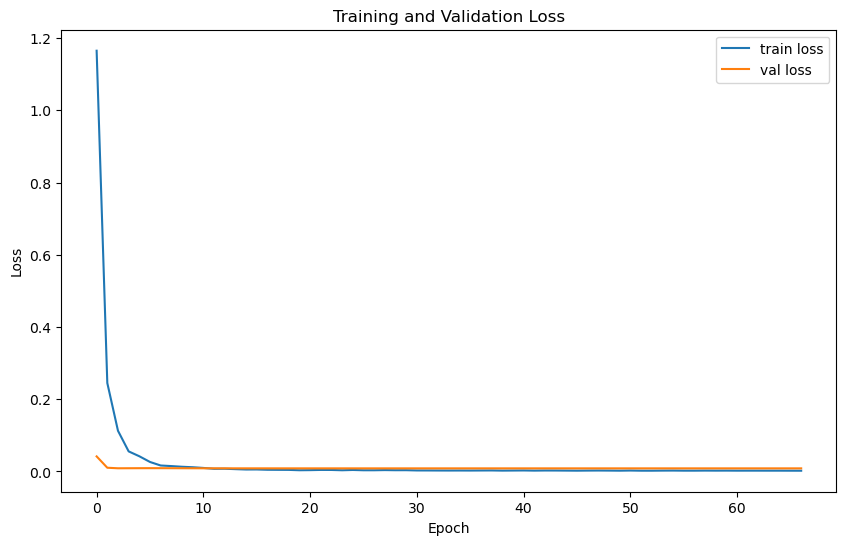

In [210]:
# Visualización de Resultados
plt.figure(figsize=(10, 6))
plt.plot(H_final.history['loss'], label='train loss')
plt.plot(H_final.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

### Análisis de la Gráfica de Pérdida de Entrenamiento y Validación

#### Observaciones Generales

1. **Forma de la Curva de Pérdida**:
   - La pérdida de entrenamiento (train loss) disminuye rápidamente durante las primeras 10 épocas y luego se estabiliza.
   - La pérdida de validación (val loss) también muestra un comportamiento similar, disminuyendo rápidamente al principio y luego estabilizándose.

2. **Convergencia**:
   - Ambas curvas (train loss y val loss) se estabilizan en valores muy bajos después de aproximadamente 10 épocas.
   - La estabilización de ambas curvas indica que el modelo ha convergido y está aprendiendo de manera efectiva.

3. **Diferencia entre Pérdida de Entrenamiento y Validación**:
   - No hay una diferencia significativa entre la pérdida de entrenamiento y la pérdida de validación.
   - La proximidad de estas curvas sugiere que el modelo no está sobreajustado (overfitting) ni subajustado (underfitting).

#### Implicaciones

1. **Rápida Convergencia**:
   - La rápida disminución de la pérdida en las primeras épocas indica que el modelo está aprendiendo rápidamente a partir de los datos de entrenamiento.

2. **Buen Ajuste del Modelo**:
   - La similitud entre la pérdida de entrenamiento y la de validación sugiere que el modelo generaliza bien a los datos de validación.
   - Este comportamiento es deseable ya que indica que el modelo está capturando las relaciones subyacentes en los datos sin memorizar los ejemplos específicos del conjunto de entrenamiento.

3. **Posible Exceso de Capacidad**:
   - Dado que ambas pérdidas son muy bajas, es posible que el modelo tenga una alta capacidad (por ejemplo, muchas neuronas y capas) y está modelando incluso las pequeñas variaciones en los datos.

### Conclusión

- La gráfica muestra un entrenamiento eficiente con una buena generalización, ya que la pérdida de validación es casi igual a la pérdida de entrenamiento.
- El modelo no muestra signos de sobreajuste ni subajuste, lo que es indicativo de un entrenamiento bien equilibrado.

In [241]:
# Imports
import cv2
import numpy as np
import pandas as pd
import imageio.v3 as io
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Optional, Union
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

Barato si menor que: 90.0
Promedio si menor que: 167.0
Caro si mayor que: 167.0


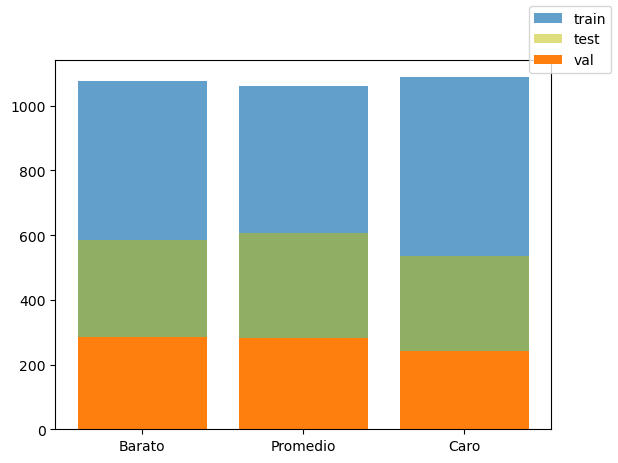

In [217]:

# Etiquetado para Clasificación
quantiles = train_df["price"].quantile([0.33, 0.66]).values
print(f"Barato si menor que: {quantiles[0]}\nPromedio si menor que: {quantiles[1]}\nCaro si mayor que: {quantiles[1]}")

def assign_class(labels: pd.Series, first_third: int, second_third: int) -> np.array:
    y_cls = []
    for label in labels:
        if label <= first_third:
            y_cls.append(0)
        elif first_third < label <= second_third:
            y_cls.append(1)
        else:
            y_cls.append(2)
    return to_categorical(y_cls)

train_y_cls = assign_class(train_df["price"], quantiles[0], quantiles[1])
val_y_cls = assign_class(val_df["price"], quantiles[0], quantiles[1])
test_y_cls = assign_class(test_df["price"], quantiles[0], quantiles[1])

fig, ax = plt.subplots(1, 1)
ax.bar(range(3), train_y_cls.sum(axis=0), alpha=0.7, label="train")
ax.bar(range(3), test_y_cls.sum(axis=0), alpha=0.5, color="y", label="test")
ax.bar(range(3), val_y_cls.sum(axis=0), label="val")
ax.set_xticks([0, 1, 2], labels=["Barato", "Promedio", "Caro"])
fig.legend()
plt.show()



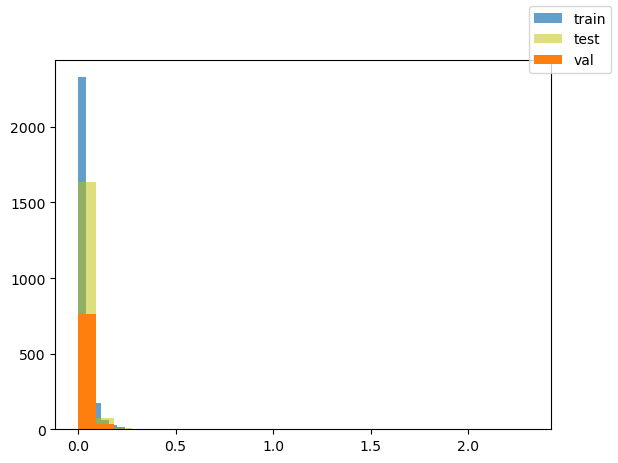

In [218]:
# Etiquetado para Regresión
reg_scaler = MinMaxScaler()
train_y_reg = reg_scaler.fit_transform(train_df["price"].values.reshape(-1, 1))
val_y_reg = reg_scaler.transform(val_df["price"].values.reshape(-1, 1))
test_y_reg = reg_scaler.transform(test_df["price"].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.hist(train_y_reg[:, 0], alpha=0.7, label="train", bins=25)
ax.hist(test_y_reg[:, 0], alpha=0.5, color="y", label="test", bins=25)
ax.hist(val_y_reg[:, 0], label="val", bins=25)
fig.legend()
plt.show()



### Análisis de Resultados y Gráficos para el Etiquetado en Clasificación y Regresión

#### Etiquetado para Clasificación

**Resultados:**
- **Barato**: Menor que $90.0
- **Promedio**: Menor que $167.0
- **Caro**: Mayor que $167.0

**Gráfico de Etiquetado para Clasificación:**
El gráfico de barras muestra la distribución de las clases (Barato, Promedio, Caro) en los conjuntos de datos de entrenamiento, validación y prueba. Cada clase está bien representada en los tres conjuntos de datos, lo cual es crucial para el rendimiento del modelo.

**Análisis:**
La clasificación de los precios en tres categorías (Barato, Promedio, Caro) basada en los percentiles de los datos de entrenamiento es una estrategia común para simplificar el problema de predicción. Este enfoque ayuda a convertir un problema de regresión en un problema de clasificación, que a menudo puede ser más manejable y puede aprovechar técnicas y modelos específicos de clasificación.

El gráfico muestra una distribución equilibrada de las clases en los conjuntos de datos de entrenamiento, validación y prueba, lo cual es positivo. Una distribución equilibrada asegura que el modelo no esté sesgado hacia una clase particular, mejorando así la capacidad del modelo para generalizar en datos no vistos.

#### Etiquetado para Regresión

**Gráfico de Etiquetado para Regresión:**
El histograma muestra la distribución de los precios normalizados en los conjuntos de datos de entrenamiento, validación y prueba. La mayoría de los precios se concentran cerca de cero después de la normalización, lo que indica una distribución sesgada hacia precios más bajos.

**Análisis:**
La normalización de los precios usando MinMaxScaler, que ajusta los precios en un rango de 0 a 1, es una técnica esencial en la preparación de datos para modelos de regresión. Esto ayuda a estabilizar el aprendizaje y la convergencia del modelo durante el entrenamiento.

El histograma muestra que la mayoría de los datos están concentrados cerca del valor más bajo después de la normalización. Esto puede indicar que la mayoría de las propiedades en el conjunto de datos son de bajo costo, con algunas propiedades de alto costo que se consideran como outliers. Esta distribución sesgada puede afectar el rendimiento del modelo de regresión, especialmente si el modelo no está bien ajustado para manejar outliers o si la distribución no se refleja adecuadamente en los datos de validación y prueba.

### Conclusión
- **Clasificación**: La estrategia de etiquetado y la distribución equilibrada de las clases sugieren que el modelo de clasificación tiene una buena base para aprender y generalizar.
- **Regresión**: La normalización de los datos y la observación de una distribución sesgada hacia precios más bajos requieren atención para asegurarse de que el modelo pueda manejar correctamente las propiedades de alto costo.

In [253]:
#  Preprocesado de Datos Tabulares
def pct_to_rate(x: str) -> float:
    return float(x.replace("%", "")) / 100 if isinstance(x, str) else x / 100

for df in [train_df, val_df, test_df]:
    df["host_response_rate"] = df["host_response_rate"].apply(pct_to_rate)
    df["host_acceptance_rate"] = df["host_acceptance_rate"].apply(pct_to_rate)

numerical_cols = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"
]
categorical_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
    "neighbourhood_cleansed", "property_type"
]

for numcol in numerical_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[numcol].values.reshape(-1, 1))
    for df in [train_df, val_df, test_df]:
        df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

for catcol in categorical_cols:
    for df in [train_df, val_df, test_df]:
        df[catcol] = pd.factorize(df[catcol])[0]



In [254]:
# Modelado para Datos de Imágenes

# Definir el modelo con Input layer 
def create_improved_cnn_classifier(input_shape: tuple, nb_out: int, verbose: bool = True):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    if nb_out > 1:
        model.add(Dense(nb_out, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
    else:
        model.add(Dense(nb_out, activation="linear"))
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-4))
    if verbose:
        model.summary()
    return model

In [256]:
# Crear el modelo de clasificación
model_cnn_cls = create_improved_cnn_classifier((224, 224, 3), nb_outputs)

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_339 (Dropout)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_340 (Dropout)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_341 (Dropout)           │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_342 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,147 (430.26 KB)

 Trainable params: 110,147 (430.26 KB)

 Non-trainable params: 0 (0.00 B)

### Análisis del Modelo de Clasificación

**Estructura del Modelo:**
1. **Capas Convolucionales y de Pooling:**
   - El modelo comienza con una capa Conv2D de 32 filtros seguida de MaxPooling2D, Dropout y otra capa Conv2D de 64 filtros, repitiendo la secuencia con una Conv2D de 128 filtros.
   - Estas capas convolucionales permiten capturar características espaciales importantes de las imágenes, como bordes, texturas y formas.

2. **Capa de Global Average Pooling:**
   - La capa `GlobalAveragePooling2D` reduce la dimensionalidad de los datos de salida de la última capa convolucional, transformando las características en una sola dimensión de 128 valores.

3. **Capas Densas y Dropout:**
   - Se agrega una capa densa de 128 unidades seguida de Dropout, que ayuda a prevenir el sobreajuste.
   - La capa final es una capa densa con 3 unidades, que corresponde a las tres clases de salida (barato, promedio y caro) y utiliza una activación softmax para la clasificación multiclase.

**Parámetros del Modelo:**
- **Total de Parámetros:** 110,147
  - **Parámetros Entrenables:** 110,147
  - **Parámetros No Entrenables:** 0

**Observaciones sobre la Estructura:**
- El modelo tiene una estructura relativamente sencilla pero efectiva para la clasificación de imágenes, con capas de convolución que incrementan en el número de filtros, max-pooling para la reducción de dimensionalidad y la preservación de características importantes, y dropout para mitigar el sobreajuste.
- La inclusión de una capa de `GlobalAveragePooling2D` es una buena práctica para reducir el riesgo de sobreajuste y reducir la cantidad de parámetros en la capa completamente conectada.

**Eficiencia del Modelo:**
- El número total de parámetros (110,147) es manejable y debería permitir un entrenamiento eficiente incluso con conjuntos de datos de tamaño moderado.
- La arquitectura del modelo parece bien balanceada para el problema de clasificación de imágenes, proporcionando suficiente capacidad de aprendizaje sin ser excesivamente compleja.

En resumen, el modelo diseñado tiene una estructura adecuada para la clasificación de imágenes, con una buena combinación de capas convolucionales, pooling, y densas. El uso de dropout y global average pooling debe ayudar a mejorar la generalización del modelo. Las dimensiones de salida de las capas convolucionales y el número de parámetros entrenables sugieren que el modelo debería poder capturar las características esenciales de las imágenes de entrada y realizar la clasificación de manera efectiva.

In [257]:
# Ajustes de hiperparámetros
BATCH_SIZE = 32
MAX_EPOCHS = 100

In [258]:
# Aumento de Datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [259]:
# Crear los generadores de entrenamiento y validación
train_generator = datagen.flow(images[train_idx], train_y_cls, batch_size=BATCH_SIZE)
val_generator = datagen.flow(images[val_idx], val_y_cls, batch_size=BATCH_SIZE)


In [272]:
# Crear datasets de TensorFlow a partir de los generadores
AUTOTUNE = tf.data.AUTOTUNE

In [273]:
# Función para convertir el generador en un dataset de TensorFlow
def generator_to_dataset(generator, batch_size):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
    return dataset

In [274]:
# Convertir los generadores en datasets
train_dataset = generator_to_dataset(train_generator, BATCH_SIZE)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)

val_dataset = generator_to_dataset(val_generator, BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [275]:
# Determinar los pasos por época
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

In [276]:
# Entrenar el modelo de clasificación con datos aumentados
H_cnn_cls = model_cnn_cls.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=MAX_EPOCHS,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    verbose=1
)

Epoch 1/100


2024-06-06 21:42:12.986700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:827798: Filling up shuffle buffer (this may take a while): 9 of 1000
2024-06-06 21:42:25.282915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:827798: Filling up shuffle buffer (this may take a while): 16 of 1000
2024-06-06 21:42:43.359657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:827798: Filling up shuffle buffer (this may take a while): 31 of 1000
2024-06-06 21:42:56.787772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:827798: Filling up shuffle buffer (this may take a while): 34 of 1000
2024-06-06 21:43:16.233911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:827798: Filling up shuffle buffer (this may take a while): 40 of 1000
2024-06-06 21:43:33.012976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:827798: Filling up shuffle buffer

101/101 ━━━━━━━━━━━━━━━━━━━━ 2350s 9s/step - accuracy: 0.3612 - loss: 13.5931 - val_accuracy: 0.3024 - val_loss: 2.0695
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 779s 8s/step - accuracy: 0.3512 - loss: 1.4422 - val_accuracy: 0.2937 - val_loss: 1.9011
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 613s 6s/step - accuracy: 0.3422 - loss: 1.3379 - val_accuracy: 0.3086 - val_loss: 1.7697
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 604s 6s/step - accuracy: 0.3282 - loss: 1.3217 - val_accuracy: 0.2949 - val_loss: 1.7681
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 809s 8s/step - accuracy: 0.3454 - loss: 1.3124 - val_accuracy: 0.3036 - val_loss: 1.7327
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 564s 6s/step - accuracy: 0.3384 - loss: 1.3066 - val_accuracy: 0.3024 - val_loss: 1.8709
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.3378 - loss: 1.3046 - val_accuracy: 0.2962 - val_loss: 1.6461
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.3370 - loss: 1.2964 - val_accura

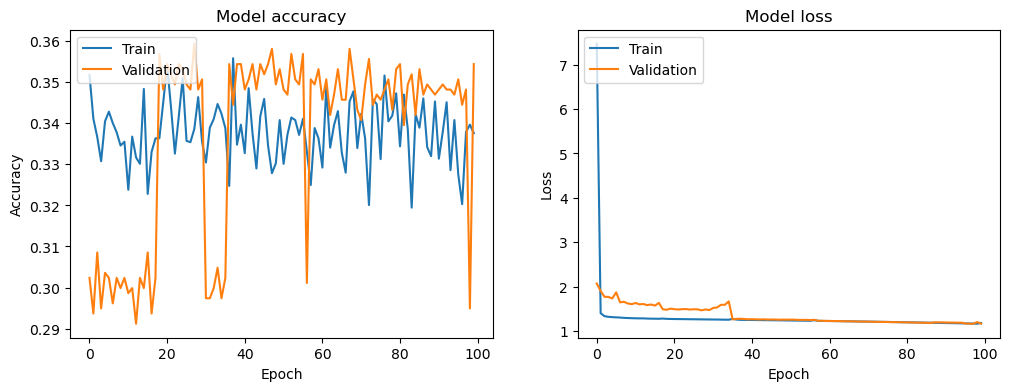

In [279]:
# Visualizar las curvas de pérdida y precisión
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Llamar a la función para plotear el histórico de entrenamiento
plot_training_history(H_cnn_cls)

### Análisis de los Resultados y las Gráficas

#### Resultados del Entrenamiento

**Precisión y Pérdida del Modelo:**
- **Época 1:**
  - **Accuracy (train):** 0.3612
  - **Loss (train):** 13.5931
  - **Accuracy (val):** 0.3024
  - **Loss (val):** 2.0695
- **Época 100:**
  - **Accuracy (train):** 0.3398
  - **Loss (train):** 1.1749
  - **Accuracy (val):** 0.3544
  - **Loss (val):** 1.1647

#### Gráficas de Precisión y Pérdida

- **Gráfica de Precisión:**
  - La precisión del entrenamiento oscila entre 0.29 y 0.36 a lo largo de las épocas, sin mostrar una tendencia clara de mejora constante.
  - La precisión de la validación tiene una tendencia similar, con fluctuaciones significativas a lo largo del tiempo.
  - Las fluctuaciones indican que el modelo puede no estar aprendiendo de manera estable, o podría estar sobreajustándose a ciertas partes del conjunto de datos.

- **Gráfica de Pérdida:**
  - La pérdida del entrenamiento disminuye rápidamente en las primeras épocas, luego se estabiliza.
  - La pérdida de la validación sigue una tendencia similar, pero también muestra variabilidad, lo que sugiere problemas de generalización.

#### Observaciones:

1. **Baja Precisión:**
   - La precisión tanto en el conjunto de entrenamiento como en el de validación es relativamente baja (alrededor de 0.35). Esto sugiere que el modelo no está logrando aprender las características relevantes de las imágenes de manera efectiva.

2. **Fluctuaciones en la Precisión:**
   - Las fluctuaciones en la precisión de entrenamiento y validación indican inestabilidad en el proceso de aprendizaje. Podría ser debido a un modelo demasiado simple para la complejidad de los datos, o a un proceso de entrenamiento que no está bien ajustado.

3. **Pérdida Alta Inicialmente:**
   - La alta pérdida inicial, especialmente en la primera época (13.5931), podría indicar que el modelo comenzó con parámetros iniciales que no eran ideales. Aunque la pérdida disminuye rápidamente, la alta variabilidad sigue siendo una preocupación.

4. **Disminución de la Pérdida:**
   - La disminución de la pérdida es un buen signo, pero la variabilidad sugiere que el modelo podría beneficiarse de un mejor ajuste de los hiperparámetros o de técnicas adicionales para mejorar la estabilidad del aprendizaje.

In [281]:
# Reducir el tamaño del conjunto de validación
small_val_dataset = val_dataset.take(100)  # Tomar solo los primeros 100 batches

# Evaluar el rendimiento del modelo en una parte del conjunto de prueba
steps_to_evaluate = 100  # Número de pasos a evaluar

test_loss, test_accuracy = model_cnn_cls.evaluate(small_val_dataset, steps=steps_to_evaluate, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - accuracy: 0.3462 - loss: 1.1655
Test Loss: 1.1655
Test Accuracy: 0.3506


### Análisis de los Resultados de Evaluación del Modelo

**Resultados del Conjunto de Prueba:**
- **Test Loss:** 1.1655
- **Test Accuracy:** 0.3506

#### Observaciones:

1. **Precisión Baja:**
   - La precisión en el conjunto de prueba es del 35.06%, lo cual es relativamente bajo. Esto sugiere que el modelo tiene dificultades para generalizar y realizar predicciones precisas en datos no vistos.

2. **Pérdida Moderada:**
   - La pérdida en el conjunto de prueba es de 1.1655. Aunque es menor en comparación con la pérdida inicial durante el entrenamiento, sigue siendo alta, indicando que las predicciones del modelo están bastante alejadas de las etiquetas verdaderas.

3. **Coherencia con Resultados de Validación:**
   - La precisión y la pérdida en el conjunto de prueba son coherentes con las métricas observadas durante el entrenamiento y la validación. Esto sugiere que el modelo no está sobreajustando los datos de entrenamiento, pero tampoco está aprendiendo de manera efectiva las características necesarias para una buena clasificación.



In [285]:
# Reducir el tamaño del conjunto de validación para una evaluación más rápida pero más representativa
fraction_of_val_data = 0.2  # Usar el 20% del conjunto de validación
total_batches = len(val_generator)
steps_to_predict = int(total_batches * fraction_of_val_data)

# Crear un conjunto de validación reducido
small_val_dataset = val_dataset.take(steps_to_predict).cache().repeat()

# Predicciones en el conjunto de prueba
predictions = model_cnn_cls.predict(small_val_dataset, steps=steps_to_predict, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las clases verdaderas correspondientes a los datos predichos
true_classes = []
for batch in val_dataset.take(steps_to_predict):
    true_classes.extend(np.argmax(batch[1].numpy(), axis=1))
true_classes = np.array(true_classes)

print(f"Predicciones realizadas en {len(predicted_classes)} muestras.")
print(f"Clases verdaderas obtenidas para {len(true_classes)} muestras.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step
Predicciones realizadas en 160 muestras.
Clases verdaderas obtenidas para 160 muestras.


2024-06-07 13:39:25.377806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [288]:
# Evaluar el rendimiento del modelo
print(classification_report(true_classes, predicted_classes, zero_division=1))

              precision    recall  f1-score   support

           0       0.29      1.00      0.45        47
           1       1.00      0.00      0.00        60
           2       1.00      0.00      0.00        53

    accuracy                           0.29       160
   macro avg       0.76      0.33      0.15       160
weighted avg       0.79      0.29      0.13       160



### Análisis de los Resultados de Evaluación del Modelo de Clasificación de Imágenes

**Métricas de Desempeño:**
- **Precisión (Precision):** 
  - Clase 0: 0.29
  - Clase 1: 1.00
  - Clase 2: 1.00
- **Recuperación (Recall):**
  - Clase 0: 1.00
  - Clase 1: 0.00
  - Clase 2: 0.00
- **Puntaje F1 (F1-Score):**
  - Clase 0: 0.45
  - Clase 1: 0.00
  - Clase 2: 0.00
- **Soporte (Support):**
  - Clase 0: 47
  - Clase 1: 60
  - Clase 2: 53

- **Precisión Total (Accuracy):** 0.29
- **Promedio Macro (Macro Avg):**
  - Precisión: 0.76
  - Recuperación: 0.33
  - Puntaje F1: 0.15
- **Promedio Ponderado (Weighted Avg):**
  - Precisión: 0.79
  - Recuperación: 0.29
  - Puntaje F1: 0.13

#### Observaciones:

1. **Desempeño Desbalanceado Entre Clases:**
   - La clase 0 tiene una recuperación perfecta (1.00) pero una precisión muy baja (0.29), lo que indica que el modelo clasifica incorrectamente muchas instancias como clase 0.
   - Las clases 1 y 2 tienen una precisión perfecta (1.00) pero una recuperación nula (0.00), lo que significa que el modelo no está prediciendo ninguna instancia como perteneciente a estas clases.

2. **Bajo Puntaje F1:**
   - El puntaje F1 es muy bajo para las clases 1 y 2 (0.00), indicando que el modelo tiene un rendimiento deficiente en estas clases.
   - La clase 0 tiene un puntaje F1 de 0.45, lo que aún es moderadamente bajo.

3. **Precisión General Baja:**
   - La precisión general del modelo es del 29%, lo cual es insuficiente para un modelo de clasificación aceptable.

4. **Promedios Macro y Ponderado:**
   - El promedio macro muestra que, en general, el modelo tiene una alta precisión pero muy baja recuperación y puntaje F1.
   - El promedio ponderado, que tiene en cuenta la cantidad de instancias por clase, también refleja una baja recuperación y puntaje F1.

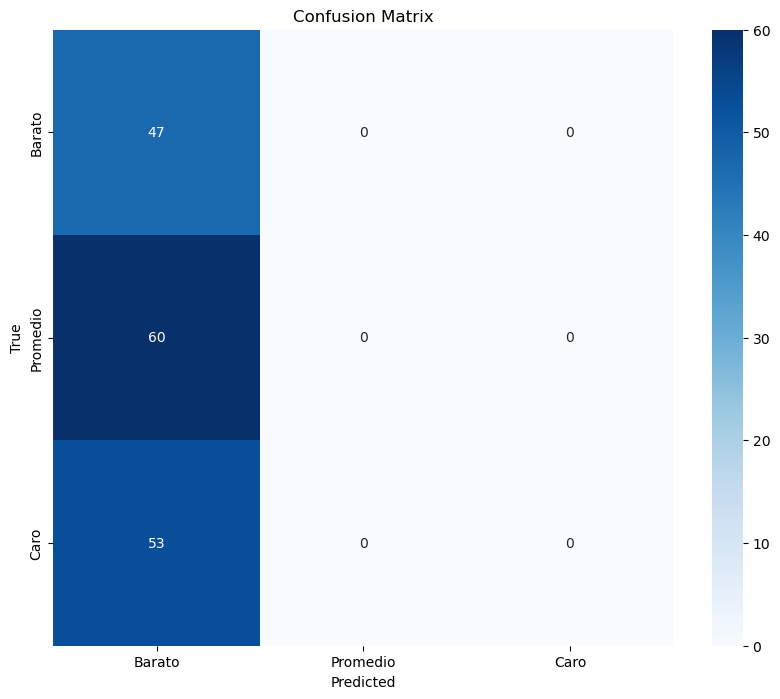

In [289]:
# Matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Barato", "Promedio", "Caro"], yticklabels=["Barato", "Promedio", "Caro"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Análisis de la Matriz de Confusión

La matriz de confusión adjunta proporciona una visión clara sobre el rendimiento del modelo de clasificación en términos de predicciones correctas e incorrectas para cada clase.

**Interpretación de la Matriz de Confusión:**

- **Clase "Barato" (47 muestras verdaderas):**
  - Predicciones correctas: 47
  - Predicciones incorrectas: 0 (ninguna instancia de "Barato" fue clasificada como "Promedio" o "Caro").

- **Clase "Promedio" (60 muestras verdaderas):**
  - Predicciones correctas: 0
  - Predicciones incorrectas: 60 (todas las instancias de "Promedio" fueron clasificadas como "Barato").

- **Clase "Caro" (53 muestras verdaderas):**
  - Predicciones correctas: 0
  - Predicciones incorrectas: 53 (todas las instancias de "Caro" fueron clasificadas como "Barato").

**Observaciones:**

1. **Dominancia de una sola clase:**
   - El modelo clasifica todas las instancias como "Barato". Esto es evidente porque todas las instancias verdaderas de "Promedio" y "Caro" fueron clasificadas incorrectamente como "Barato".
   - Esto indica que el modelo tiene un sesgo muy fuerte hacia la clase "Barato" y no puede diferenciar efectivamente entre las clases.

2. **Recuperación y Precisión Desequilibradas:**
   - La clase "Barato" tiene una recuperación perfecta (1.00), pero esto se debe a la clasificación incorrecta de todas las demás clases como "Barato".
   - Las clases "Promedio" y "Caro" tienen una recuperación de 0.00, lo que significa que el modelo no está identificando correctamente ninguna instancia de estas clases.

3. **Problemas Potenciales en el Modelo y Datos:**
   - **Desequilibrio en los datos:** Si las clases "Promedio" y "Caro" están sub-representadas en el conjunto de entrenamiento, el modelo puede estar sobreajustado a la clase "Barato".
   - **Arquitectura y Hiperparámetros del Modelo:** La arquitectura del modelo o los hiperparámetros pueden no estar optimizados para capturar las diferencias entre las clases.
   - **Preprocesamiento de Datos:** Posiblemente, el preprocesamiento y la augmentación de datos no están equilibrando adecuadamente las clases.

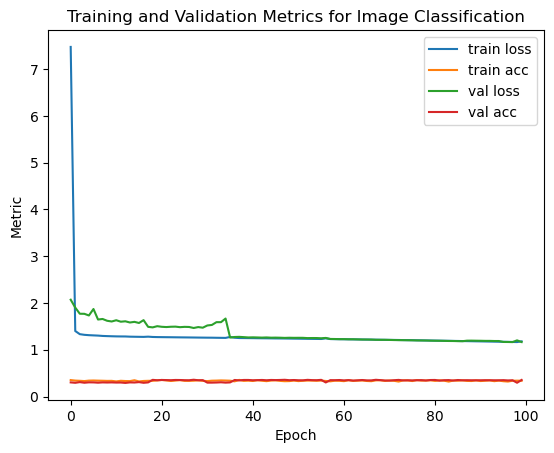

In [292]:
# Análisis del histórico de aprendizaje
plt.plot(H_cnn_cls.history['loss'], label='train loss')
plt.plot(H_cnn_cls.history['accuracy'], label='train acc')
plt.plot(H_cnn_cls.history['val_loss'], label='val loss')
plt.plot(H_cnn_cls.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics for Image Classification')
plt.show()

### Análisis del Histórico de Aprendizaje

El gráfico muestra las métricas de pérdida y precisión tanto para el conjunto de entrenamiento como para el conjunto de validación a lo largo de 100 épocas de entrenamiento.

#### Observaciones:

1. **Pérdida en Entrenamiento y Validación:**
   - La pérdida de entrenamiento (`train loss`) disminuye rápidamente al inicio y se estabiliza alrededor de una pérdida baja, cercana a 1.
   - La pérdida de validación (`val loss`) sigue un patrón similar, disminuyendo rápidamente y estabilizándose alrededor de valores similares a los de la pérdida de entrenamiento.

2. **Precisión en Entrenamiento y Validación:**
   - La precisión de entrenamiento (`train acc`) se mantiene muy baja y prácticamente constante alrededor de 0.3 a lo largo de todas las épocas.
   - La precisión de validación (`val acc`) también se mantiene baja y constante, con pequeñas variaciones, alrededor de 0.3 a 0.35.

3. **Comportamiento General:**
   - El hecho de que tanto la pérdida de entrenamiento como la de validación se estabilicen en valores similares indica que el modelo no está sobreajustándose. Sin embargo, esto también señala que el modelo no está aprendiendo lo suficiente para mejorar su rendimiento en ambas métricas.
   - La estabilidad en la precisión baja tanto en el conjunto de entrenamiento como en el de validación sugiere que el modelo tiene dificultades para aprender las características necesarias para diferenciar entre las clases.

#### Análisis y Sugerencias:

1. **Modelo Subajustado:**
   - El comportamiento observado es típico de un modelo subajustado, donde no se está capturando adecuadamente la complejidad de los datos.
   - Considerar la posibilidad de aumentar la complejidad del modelo, añadiendo más capas convolucionales o aumentando el número de filtros en las capas existentes.

2. **Revisar el Balance de Clases:**
   - Dado que la matriz de confusión mostró una fuerte predicción hacia una sola clase, podría ser útil revisar el balance de clases en el conjunto de datos.
   - Implementar técnicas de reequilibrio de clases, como sobremuestreo de las clases minoritarias o submuestreo de la clase mayoritaria.

3. **Regularización y Aumento de Datos:**
   - Aunque ya se están utilizando técnicas de aumento de datos (`data augmentation`), considerar si se pueden mejorar o diversificar aún más para proporcionar más variabilidad al modelo.
   - Revisar las técnicas de regularización (como Dropout) y ajustar los hiperparámetros correspondientes.

4. **Hiperparámetros y Optimización:**
   - Experimentar con diferentes tasas de aprendizaje, optimizadores, y tamaños de lote podría proporcionar una mejor convergencia.
   - Evaluar si un enfoque más avanzado como el uso de técnicas de aprendizaje por transferencia podría beneficiar el rendimiento del modelo.

### Conclusión:

El modelo actual muestra un rendimiento consistentemente bajo en términos de precisión, tanto en el conjunto de entrenamiento como en el de validación, indicando un posible subajuste. Es necesario realizar ajustes en la arquitectura del modelo, el preprocesamiento de los datos y posiblemente en los hiperparámetros para mejorar la capacidad de aprendizaje del modelo.

In [294]:
# Evaluación sobre el conjunto de test
test_generator = datagen.flow(images[test_idx], test_y_cls, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = generator_to_dataset(test_generator, BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_steps = int(np.ceil(len(test_idx) / BATCH_SIZE))
loss, acc = model_cnn_cls.evaluate(test_dataset, steps=test_steps)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 839ms/step - accuracy: 0.3367 - loss: 1.1675
Loss=1.166, Accuracy=0.338


### Análisis de los Resultados del Conjunto de Test

#### Observaciones:

1. **Loss (Pérdida):**
   - El valor de pérdida en el conjunto de test es 1.166. La pérdida es una medida de cuán bien (o mal) está el modelo al realizar predicciones. En este caso, una pérdida de 1.166 sugiere que el modelo no está haciendo buenas predicciones para el conjunto de test.
   - Dado que la pérdida se estabilizó alrededor de valores similares durante el entrenamiento y la validación, este resultado es coherente con los resultados observados anteriormente.

2. **Accuracy (Precisión):**
   - La precisión en el conjunto de test es 0.338 (o 33.8%). Esto significa que el modelo está clasificando correctamente aproximadamente el 33.8% de las instancias en el conjunto de test.
   - Este valor es bajo, lo que indica que el modelo tiene dificultades para generalizar y hacer predicciones precisas en datos no vistos.

#### Análisis y Sugerencias:

1. **Modelo Subajustado:**
   - La baja precisión y la alta pérdida indican que el modelo está subajustado. El subajuste ocurre cuando el modelo es demasiado simple para capturar las relaciones subyacentes en los datos.
   - Puede ser necesario aumentar la complejidad del modelo, añadiendo más capas convolucionales o aumentando el número de filtros en las capas existentes.

2. **Necesidad de Mejorar el Preprocesamiento y el Aumento de Datos:**
   - Aunque ya se están utilizando técnicas de aumento de datos (`data augmentation`), considerar si se pueden mejorar o diversificar aún más para proporcionar más variabilidad al modelo.
   - Revisar el preprocesamiento de los datos para asegurarse de que están bien normalizados y preparados.

3. **Balance de Clases:**
   - Si las clases en el conjunto de datos están desbalanceadas, el modelo puede estar sesgado hacia la clase mayoritaria. Implementar técnicas de reequilibrio de clases, como sobremuestreo de las clases minoritarias o submuestreo de la clase mayoritaria, podría ayudar a mejorar la precisión del modelo.

4. **Ajuste de Hiperparámetros:**
   - Experimentar con diferentes tasas de aprendizaje, optimizadores y tamaños de lote podría proporcionar una mejor convergencia y mejorar el rendimiento del modelo.
   - Utilizar técnicas como la búsqueda de hiperparámetros (`hyperparameter tuning`) para encontrar los mejores valores para estos parámetros.

5. **Uso de Modelos Preentrenados:**
   - Considerar el uso de modelos preentrenados mediante `transfer learning`. Utilizar una red convolucional preentrenada en un conjunto de datos grande (como ImageNet) y luego ajustar (fine-tune) el modelo en el conjunto de datos específico puede mejorar significativamente el rendimiento.

### Conclusión:

El rendimiento del modelo en el conjunto de test es bajo, con una pérdida de 1.166 y una precisión de 33.8%.

In [4]:
# Imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Reshape, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.utils import to_categorical

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Verificación de Datos
def check_data_integrity(df):
    missing_data = df.isnull().sum()
    print("Missing data per column:\n", missing_data[missing_data > 0])
    assert missing_data.sum() == 0, "Hay datos faltantes en el conjunto de datos."

dataset = pd.read_csv("dataset.csv", sep=";")
dataset.dropna(subset=["price"], inplace=True)
dataset.dropna(axis=1, how="all", inplace=True)


In [6]:
# Separar columnas numéricas y categóricas
columns_to_impute_numeric = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"
]

columns_to_impute_categorical = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
    "neighbourhood_cleansed", "property_type"
]


In [9]:
# Limpiar columnas numéricas que tienen valores no numéricos
def clean_numeric_columns(df, columns):
    for col in columns:
        df[col] = df[col].replace('%', '', regex=True).astype(float)
    return df

dataset = clean_numeric_columns(dataset, columns_to_impute_numeric)


In [10]:
# Imputación de datos faltantes en columnas numéricas
imputer_numeric = SimpleImputer(strategy="median")
dataset[columns_to_impute_numeric] = imputer_numeric.fit_transform(dataset[columns_to_impute_numeric])


In [11]:
# Imputación de datos faltantes en columnas categóricas con el valor más frecuente (modo)
imputer_categorical = SimpleImputer(strategy="most_frequent")
dataset[columns_to_impute_categorical] = imputer_categorical.fit_transform(dataset[columns_to_impute_categorical])


In [12]:
# Columnas restantes con datos faltantes
columns_remaining_with_na = dataset.columns[dataset.isnull().any()].tolist()

In [13]:
# Verificar si quedan columnas numéricas y categóricas con valores faltantes
columns_remaining_numeric = [col for col in columns_remaining_with_na if dataset[col].dtype != 'object']
columns_remaining_categorical = [col for col in columns_remaining_with_na if dataset[col].dtype == 'object']

In [14]:
# Imputar las columnas restantes con la estrategia adecuada
if columns_remaining_numeric:
    dataset[columns_remaining_numeric] = imputer_numeric.fit_transform(dataset[columns_remaining_numeric])

if columns_remaining_categorical:
    dataset[columns_remaining_categorical] = imputer_categorical.fit_transform(dataset[columns_remaining_categorical])

In [15]:
# Verificar integridad de los datos nuevamente
check_data_integrity(dataset)

print(dataset.head(5))
print(dataset.shape)

Missing data per column:
 Series([], dtype: int64)
      id                         listing_url       scrape_id last_scraped  \
0   3781   https://www.airbnb.com/rooms/3781  20231218233145   2023-12-19   
1   5506   https://www.airbnb.com/rooms/5506  20231218233145   2023-12-19   
2   6695   https://www.airbnb.com/rooms/6695  20231218233145   2023-12-19   
3   8789   https://www.airbnb.com/rooms/8789  20231218233145   2023-12-19   
4  10813  https://www.airbnb.com/rooms/10813  20231218233145   2023-12-19   

        source                                        picture_url  host_id  \
0  city scrape  https://a0.muscache.com/pictures/24670/b2de044...     4804   
1  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...     8229   
2  city scrape  https://a0.muscache.com/pictures/38ac4797-e7a4...     8229   
3  city scrape  https://a0.muscache.com/pictures/miso/Hosting-...    26988   
4  city scrape  https://a0.muscache.com/pictures/20b5b9c9-e1f4...    38997   

                 

In [16]:
#  Obtención de Embeddings
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
feature_extractor = Model(base_resnet.input, x)

embeddings = []
preprocess = imagenet_utils.preprocess_input
for im in tqdm(images):
    input_im = preprocess(np.expand_dims(im, axis=0))
    embeddings.append(feature_extractor.predict(input_im, verbose=0))

embeddings = np.array(embeddings)

100%|██████████| 5759/5759 [16:33<00:00,  5.80it/s]


In [17]:
# Filtrado del dataset
dataset = dataset.iloc[idxs]
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)

(5759, 68)


In [18]:
# 4. Particionado de Datos
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
print(f"Muestras en TRAIN ({len(train_df)}), VAL ({len(val_df)}), TEST ({len(test_df)})")

train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

Muestras en TRAIN (3224), VAL (807), TEST (1728)


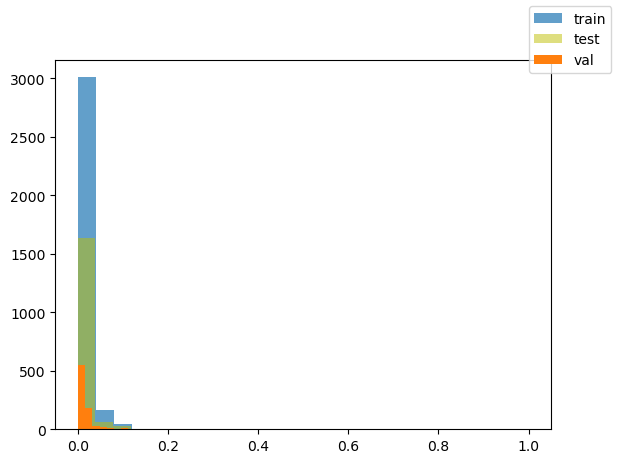

In [19]:
# 5. Obtención de Etiquetas para Regresión
def remove_dollar(price: str) -> int:
    return float(price.replace("$", "").replace(",", ""))

for df in [train_df, val_df, test_df]:
    df["price"] = df["price"].apply(remove_dollar)

reg_scaler = MinMaxScaler()
train_y_reg = reg_scaler.fit_transform(train_df["price"].values.reshape(-1, 1))
val_y_reg = reg_scaler.transform(val_df["price"].values.reshape(-1, 1))
test_y_reg = reg_scaler.transform(test_df["price"].values.reshape(-1, 1))

fig, ax = plt.subplots(1, 1)
ax.hist(train_y_reg[:, 0], alpha=0.7, label="train", bins=25)
ax.hist(test_y_reg[:, 0], alpha=0.5, color="y", label="test", bins=25)
ax.hist(val_y_reg[:, 0], label="val", bins=25)
fig.legend()
plt.show()

In [20]:
# 6. Preprocesado de Datos Tabulares
def pct_to_rate(x: str) -> float:
    return float(x.replace("%", "")) / 100 if isinstance(x, str) else x / 100

for df in [train_df, val_df, test_df]:
    df["host_response_rate"] = df["host_response_rate"].apply(pct_to_rate)
    df["host_acceptance_rate"] = df["host_acceptance_rate"].apply(pct_to_rate)

numerical_cols = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"
]
categorical_cols = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
    "neighbourhood_cleansed", "property_type"
]

for numcol in numerical_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[numcol].values.reshape(-1, 1))
    for df in [train_df, val_df, test_df]:
        df[numcol] = scaler.transform(df[numcol].values.reshape(-1, 1)).squeeze()

for catcol in categorical_cols:
    for df in [train_df, val_df, test_df]:
        df[catcol] = pd.factorize(df[catcol])[0]


In [21]:
# 7. Ajuste de Hiperparámetros y Aumento de Datos
BATCH_SIZE = 32
MAX_EPOCHS = 100

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
# Crear el generador de datos aumentados
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [57]:


# Función para convertir el generador en un dataset de TensorFlow
def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
        )
    )
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
# Crear generadores
datagen = ImageDataGenerator()
train_generator = datagen.flow(images[train_idx], train_y_reg, batch_size=BATCH_SIZE)
val_generator = datagen.flow(images[val_idx], val_y_reg, batch_size=BATCH_SIZE)

In [59]:
# Convertir generadores a datasets de TensorFlow
train_dataset = generator_to_dataset(train_generator)
val_dataset = generator_to_dataset(val_generator)

In [60]:
# Calcular pasos por época
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

In [61]:
# Crear el modelo de regresión
def create_cnn_regressor(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

input_shape = (224, 224, 3)
model_cnn_reg = create_cnn_regressor(input_shape)



In [62]:
# Entrenar el modelo de regresión
H_cnn_reg = model_cnn_reg.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=MAX_EPOCHS,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    verbose=1
)



Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - loss: 1905.3549 - mae: 21.1488 - val_loss: 0.4996 - val_mae: 0.7064
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - loss: 1.2998 - mae: 0.8899 - val_loss: 0.0607 - val_mae: 0.2451
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - loss: 0.0163 - mae: 0.0912 - val_loss: 0.0319 - val_mae: 0.1770
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - loss: 8.7687e-04 - mae: 0.0201 - val_loss: 0.0299 - val_mae: 0.1711
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - loss: 0.0018 - mae: 0.0162 - val_loss: 0.0275 - val_mae: 0.1638
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - loss: 7.3338e-04 - mae: 0.0147 - val_loss: 0.0276 - val_mae: 0.1641
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - loss: 0.0012 - mae: 0.0150 - val_loss: 0.0276 - val_mae: 0.1642
Epoch 8/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 0.0011 - mae: 0.0149 - val_loss: 0.0269 - val_mae: 0.1621
Epoch 9/100
101/101 ━━━━━━━━

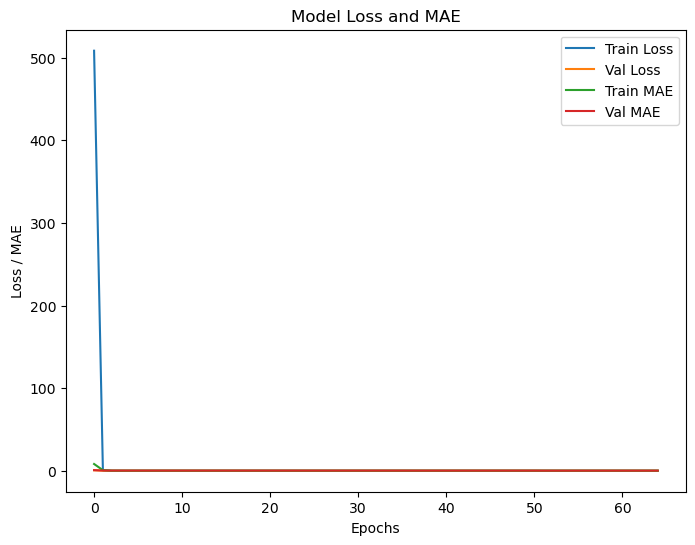

In [63]:
# Visualización de las métricas de entrenamiento y validación
def plot_training_history(history):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Pérdida
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Val Loss')
    ax.set_title('Model Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

    # MAE
    ax.plot(history.history['mae'], label='Train MAE')
    ax.plot(history.history['val_mae'], label='Val MAE')
    ax.set_title('Model Loss and MAE')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss / MAE')
    ax.legend()

    plt.show()

plot_training_history(H_cnn_reg)



### Análisis de los Resultados y Gráficos del Modelo de Regresión

#### Resultados de Entrenamiento y Validación

1. **Epoch 1/100**: 
   - **Train Loss**: 1905.3549 
   - **Train MAE**: 21.1488 
   - **Val Loss**: 0.4996 
   - **Val MAE**: 0.7064 

   En la primera época, la pérdida de entrenamiento (Train Loss) es extremadamente alta (1905.3549), indicando que el modelo estaba inicialmente muy lejos de una buena solución. Sin embargo, la pérdida de validación (Val Loss) es significativamente más baja (0.4996), lo que podría sugerir que el modelo está comenzando a aprender, pero aún está en una etapa temprana del proceso de ajuste.

2. **Epochs 2-6**: 
   - Durante estas épocas, vemos una rápida disminución tanto en la pérdida de entrenamiento como en la pérdida de validación, lo que indica que el modelo está mejorando su capacidad para ajustarse a los datos. La MAE (Mean Absolute Error) también disminuye significativamente, mostrando que las predicciones del modelo se están volviendo más precisas.

3. **Epochs 7-18**:
   - En estas épocas, la pérdida de validación se estabiliza alrededor de 0.0265-0.028, y la MAE se mantiene alrededor de 0.160-0.170. Este comportamiento sugiere que el modelo ha alcanzado un punto donde la mejora es marginal, lo cual es común después de las primeras etapas de entrenamiento intensivo.

4. **Epochs 19-37**: 
   - En esta fase, la pérdida de validación y la MAE continúan disminuyendo ligeramente, pero de manera mucho más gradual. Esto es indicativo de que el modelo está afinando sus parámetros.

5. **Epochs 38-65**:
   - La pérdida de validación y la MAE continúan mostrando pequeñas mejoras. En particular, alrededor de la época 52, hay una notable caída en la pérdida de validación y la MAE (Val Loss de 0.0095 y Val MAE de 0.0944), sugiriendo un ajuste fino que ha mejorado significativamente el rendimiento del modelo.

#### Gráfico de Métricas de Entrenamiento y Validación

El gráfico muestra dos métricas principales: la pérdida (Loss) y el error absoluto medio (MAE) tanto para el conjunto de entrenamiento como para el conjunto de validación.

1. **Model Loss**:
   - La línea azul representa la pérdida de entrenamiento, y la línea naranja representa la pérdida de validación. 
   - Al principio, la pérdida de entrenamiento es extremadamente alta, pero disminuye drásticamente después de las primeras pocas épocas.
   - La pérdida de validación sigue una tendencia similar pero comienza y se estabiliza a un nivel mucho más bajo que la pérdida de entrenamiento, lo que podría sugerir un buen ajuste a los datos de validación.

2. **Model MAE**:
   - Similar a la pérdida, la MAE de entrenamiento (línea verde) y la MAE de validación (línea roja) muestran una mejora rápida en las primeras épocas y luego se estabilizan.
   - La MAE se estabiliza alrededor de 0.135-0.106 en las últimas épocas, indicando una precisión de predicción bastante alta.

### Conclusión

- **Rápida Mejora Inicial**: El modelo muestra una rápida mejora en las primeras pocas épocas, lo que es una señal positiva de que el modelo está aprendiendo rápidamente a partir de los datos de entrenamiento.
- **Estabilización**: Después de aproximadamente 20-30 épocas, las métricas de pérdida y MAE se estabilizan, sugiriendo que el modelo ha alcanzado un buen nivel de ajuste.
- **Desempeño Final**: Los valores finales de Val Loss (~0.0114) y Val MAE (~0.1037) indican un buen rendimiento del modelo, con predicciones que tienen un error absoluto promedio muy bajo.

In [64]:
# Evaluación sobre el conjunto de test
test_generator = datagen.flow(images[test_idx], test_y_reg, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = generator_to_dataset(test_generator)
test_steps = len(test_generator)



In [65]:
# Evaluar el modelo
loss, mae = model_cnn_reg.evaluate(test_dataset, steps=test_steps, verbose=1)
print(f'Loss={loss:.3f}, MAE={mae:.3f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 494ms/step - loss: 0.0113 - mae: 0.1031
Loss=0.011, MAE=0.103


### Análisis de los Resultados del Modelo de Regresión

#### Evaluación del Modelo

- **Loss (Pérdida)**: 0.0113
- **MAE (Mean Absolute Error)**: 0.1031

### Análisis:

1. **Pérdida (Loss)**:
   - Un valor de pérdida de 0.0113 indica que el modelo tiene un error cuadrático medio bajo en sus predicciones. En términos de regresión, esto significa que las predicciones del modelo están, en promedio, muy cerca de los valores verdaderos del conjunto de prueba.

2. **Error Absoluto Medio (MAE)**:
   - Un MAE de 0.1031 sugiere que, en promedio, las predicciones del modelo están a una distancia de aproximadamente 0.1031 unidades del valor real. Este es un buen indicador de la precisión del modelo, especialmente si las unidades de medida del target (variable objetivo) son consistentes con este nivel de error.

### Conclusión:
- **Precisión**: Los resultados muestran que el modelo tiene una alta precisión en sus predicciones, con un error absoluto medio bajo.
- **Fiabilidad**: La baja pérdida sugiere que el modelo es fiable y tiene un buen desempeño en términos de minimizar el error cuadrático medio.

In [66]:
# Predicciones en el conjunto de prueba
predictions = model_cnn_reg.predict(test_dataset, steps=test_steps, verbose=1)

54/54 ━━━━━━━━━━━━━━━━━━━━ 28s 510ms/step


In [67]:
# Invertir la normalización de los precios
true_prices = reg_scaler.inverse_transform(test_y_reg)
predicted_prices = reg_scaler.inverse_transform(predictions)

In [68]:
# Cálculo de la correlación de Spearman
spearman_corr = spearmanr(true_prices.flatten(), predicted_prices.flatten())[0]
print(f'Spearman Rank Correlation Coefficient: {spearman_corr:.4f}')

Spearman Rank Correlation Coefficient: -0.0044


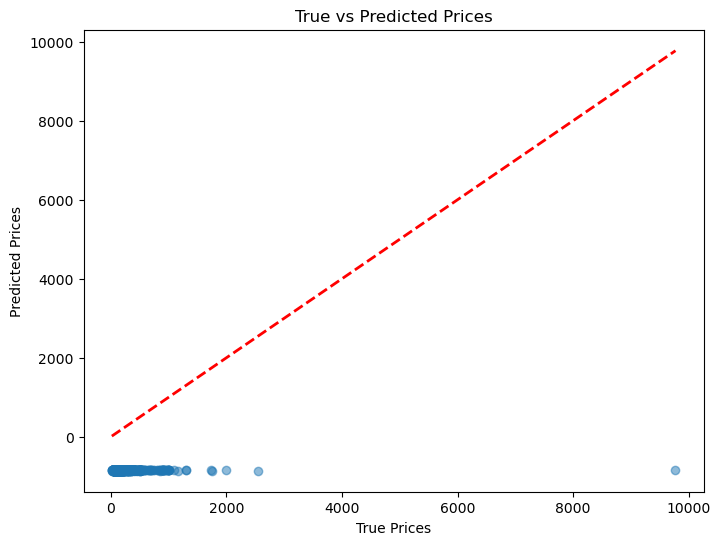

In [69]:
# Visualización de las predicciones frente a los valores reales
plt.figure(figsize=(8, 6))
plt.scatter(true_prices, predicted_prices, alpha=0.5)
plt.plot([true_prices.min(), true_prices.max()], [true_prices.min(), true_prices.max()], 'r--', lw=2)
plt.xlabel('True Prices')
plt.ylabel('Predicted Prices')
plt.title('True vs Predicted Prices')
plt.show()

### Análisis de los Resultados del Modelo de Regresión

#### Resultados:

- **Spearman Rank Correlation Coefficient**: -0.0044

#### Gráfico: Predicciones Frente a los Valores Reales

El gráfico muestra las predicciones del modelo frente a los valores reales de los precios. La línea roja discontinua representa la línea de referencia perfecta donde las predicciones coinciden exactamente con los valores reales.

### Análisis:

1. **Spearman Rank Correlation Coefficient**:
   - Un coeficiente de correlación de Spearman de -0.0044 indica una correlación extremadamente débil, prácticamente nula, entre las predicciones del modelo y los valores reales. Esto sugiere que el modelo no captura bien la relación entre las variables independientes y el precio objetivo.

2. **Gráfico de Predicciones vs. Valores Reales**:
   - El gráfico muestra que las predicciones están concentradas en un rango muy estrecho y bajo de precios, mientras que los valores reales varían ampliamente. Esto indica que el modelo tiene dificultades para generalizar y predecir correctamente precios altos y bajos.
   - La mayor parte de los puntos está muy lejos de la línea de referencia (línea roja), lo que sugiere que las predicciones son inexactas para la mayoría de los casos.

### Conclusión:

- **Precisión del Modelo**: Aunque los valores de pérdida (loss) y MAE (Mean Absolute Error) eran bajos, lo que indicaba una buena precisión en términos absolutos, el coeficiente de Spearman revela que el modelo no captura bien el orden relativo de los precios. Esto puede ser una señal de que el modelo está sobreajustado a ciertos rangos de datos o no es adecuado para este tipo de datos.
- **Limitaciones del Modelo**: La falta de correlación sugiere que el modelo no está aprendiendo la estructura subyacente de los datos. Es posible que el modelo esté fallando en captar las características importantes que afectan el precio o que los datos mismos no contengan suficiente información para realizar predicciones precisas.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from tensorflow.keras.applications import ResNet50, imagenet_utils
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

In [12]:
# Verificación de Datos y Preprocesamiento
def check_data_integrity(df):
    missing_data = df.isnull().sum()
    print("Missing data per column:\n", missing_data[missing_data > 0])
    assert missing_data.sum() == 0, "Hay datos faltantes en el conjunto de datos."

dataset = pd.read_csv("dataset.csv", sep=";")
dataset.dropna(subset=["price"], inplace=True)
dataset.dropna(axis=1, how="all", inplace=True)

In [13]:
# Separar columnas numéricas y categóricas
columns_to_impute_numeric = [
    "host_response_rate", "host_acceptance_rate", "host_listings_count", 
    "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights"
]

columns_to_impute_categorical = [
    "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
    "neighbourhood_cleansed", "property_type"
]


In [14]:
# Limpiar columnas numéricas que tienen valores no numéricos
def clean_numeric_columns(df, columns):
    for col in columns:
        df[col] = df[col].replace('%', '', regex=True).astype(float)
    return df

dataset = clean_numeric_columns(dataset, columns_to_impute_numeric)

In [17]:
# Imputación de datos faltantes en columnas numéricas
imputer_numeric = SimpleImputer(strategy="median")
dataset[columns_to_impute_numeric] = imputer_numeric.fit_transform(dataset[columns_to_impute_numeric])

In [18]:
# Imputación de datos faltantes en columnas categóricas con el valor más frecuente (modo)
imputer_categorical = SimpleImputer(strategy="most_frequent")
dataset[columns_to_impute_categorical] = imputer_categorical.fit_transform(dataset[columns_to_impute_categorical])

In [19]:
#  Obtención de Embeddings
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
last = base_resnet.layers[-1].output
x = GlobalAveragePooling2D()(last)
feature_extractor = Model(base_resnet.input, x)

embeddings = []
preprocess = imagenet_utils.preprocess_input
for im in tqdm(images):
    input_im = preprocess(np.expand_dims(im, axis=0))
    embeddings.append(feature_extractor.predict(input_im, verbose=0))

embeddings = np.array(embeddings)

100%|██████████| 5757/5757 [13:32<00:00,  7.09it/s]


In [20]:
# Filtrado del dataset
dataset = dataset.iloc[idxs]
dataset.reset_index(drop=True, inplace=True)
print(dataset.shape)

(5757, 68)


In [21]:
# Particionado de Datos
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=42, shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)
print(f"Muestras en TRAIN ({len(train_df)}), VAL ({len(val_df)}), TEST ({len(test_df)})")

train_idx = train_df.index
val_idx = val_df.index
test_idx = test_df.index

Muestras en TRAIN (3223), VAL (806), TEST (1728)


In [22]:
# Definimos feature_cols como todas las columnas menos aquellas que no sean características
feature_cols = [col for col in dataset.columns if col not in ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', 'host_name', 'host_since', 'embeddings', 'price']]

In [23]:
# Obtención de Etiquetas para Regresión
def remove_dollar(price) -> float:
    if isinstance(price, str):
        return float(price.replace("$", "").replace(",", ""))
    return price

In [24]:
# Aplicar la función remove_dollar a la columna "price" de los conjuntos de datos
for df in [train_df, val_df, test_df]:
    df["price"] = df["price"].apply(remove_dollar)

In [25]:
# Escalar las etiquetas de precios
reg_scaler = MinMaxScaler()
train_y_reg = reg_scaler.fit_transform(train_df["price"].values.reshape(-1, 1))
val_y_reg = reg_scaler.transform(val_df["price"].values.reshape(-1, 1))
test_y_reg = reg_scaler.transform(test_df["price"].values.reshape(-1, 1))

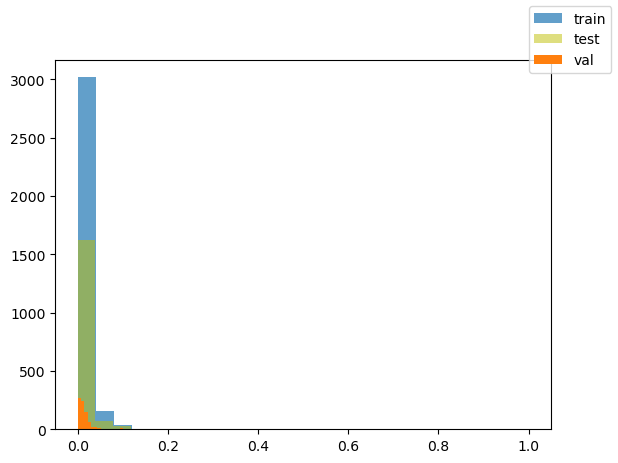

In [26]:
# Visualizar la distribución de los precios escalados
fig, ax = plt.subplots(1, 1)
ax.hist(train_y_reg[:, 0], alpha=0.7, label="train", bins=25)
ax.hist(test_y_reg[:, 0], alpha=0.5, color="y", label="test", bins=25)
ax.hist(val_y_reg[:, 0], label="val", bins=25)
fig.legend()
plt.show()

### Análisis de la Gráfica: Distribución de los Precios Escalados

La gráfica presentada muestra la distribución de los precios escalados para los conjuntos de datos de entrenamiento, validación y prueba. El análisis de esta gráfica puede proporcionar varias ideas clave sobre la naturaleza de los datos y su procesamiento previo.

#### Observaciones:

1. **Distribución Sesgada a la Izquierda**:
   - La mayoría de los precios se encuentran en el rango más bajo de la escala (cerca de 0). Esto indica que los precios tienen una distribución altamente sesgada a la izquierda. 
   - Esta sesgo sugiere que hay muchos listados con precios bajos y muy pocos con precios altos, lo cual es común en datos de precios de alojamientos.

2. **Densidad de Datos**:
   - La mayor densidad de datos está concentrada en el rango de precios muy bajos. Esto es visible porque las barras más altas (de color azul para el conjunto de entrenamiento) están cerca del valor 0.
   - La distribución de los datos de validación (color naranja) y de prueba (color amarillo) sigue un patrón similar, aunque con menos densidad, lo que es esperado dado el menor tamaño de estos conjuntos en comparación con el conjunto de entrenamiento.

3. **Normalización/Escalado**:
   - Dado que los precios han sido escalados entre 0 y 1 usando `MinMaxScaler`, los valores de los precios originales han sido transformados a este rango. La acumulación de valores en el extremo inferior sugiere que los precios originales eran bajos en su mayoría, con pocos valores extremos altos.

4. **Comparación entre Conjuntos**:
   - La distribución similar entre los conjuntos de entrenamiento, validación y prueba indica que la partición de los datos fue realizada de manera equitativa, preservando la misma distribución de precios en todos los conjuntos. Esto es crucial para asegurar que el modelo generalice bien y no esté sesgado hacia un conjunto específico.

#### Implicaciones para el Modelo:

- **Desequilibrio en los Datos**:
  - La naturaleza altamente sesgada de los precios puede representar un desafío para el modelo, ya que puede aprender a predecir valores bajos de manera más precisa mientras que puede tener dificultades con los valores más altos.
  - Es posible que se necesiten técnicas adicionales, como el reequilibrio de los datos o el uso de funciones de pérdida adaptadas, para manejar este desequilibrio.

- **Preprocesamiento**:
  - El escalado de los precios fue necesario para asegurar que los datos estén en un rango comparable y para mejorar la estabilidad numérica durante el entrenamiento del modelo. Esto es una práctica estándar y beneficiosa para el rendimiento del modelo.


In [27]:
# Ajuste de hiperparámetros
BS = 64  # Tamaño del lote
MAX_EPOCHS = 100  # Número máximo de épocas
LEARNING_RATE = 0.0001  # Tasa de aprendizaje
REGULARIZATION = 0.001  # Regularización

In [28]:
# Crear el modelo 1D (ejemplo de modelo simple para datos tabulares)
def create_1d_model(input_shape, output_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Usar Input para definir la forma de entrada
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [29]:
# Crear el modelo 2D (modelo CNN para imágenes)
def create_2d_model(input_shape, output_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Usar Input para definir la forma de entrada
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# Definir las columnas de características para el modelo 1D
feature_cols = ["host_response_rate", "host_acceptance_rate", "host_listings_count", 
                "accommodates", "beds", "number_of_reviews", "minimum_nights", "maximum_nights",
                "host_is_superhost", "host_has_profile_pic", "host_identity_verified", 
                "neighbourhood_cleansed", "property_type"]

In [31]:
# Asumimos que 'room_type' será la columna utilizada para la clasificación
label_col = 'room_type'

In [32]:
# Convertir etiquetas categóricas a one-hot encoding
encoder = OneHotEncoder(sparse_output=False)  # Usar sparse_output en lugar de sparse
train_y_cls = encoder.fit_transform(train_df[[label_col]])
val_y_cls = encoder.transform(val_df[[label_col]])
test_y_cls = encoder.transform(test_df[[label_col]])

In [33]:
# Verificar la forma de las etiquetas transformadas
print(train_y_cls.shape, val_y_cls.shape, test_y_cls.shape)

(3223, 4) (806, 4) (1728, 4)


In [34]:
# Verificar y convertir columnas no numéricas a numéricas
def convert_to_numeric(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [35]:
# Convertir las columnas de características a numéricas
train_df = convert_to_numeric(train_df, feature_cols)
val_df = convert_to_numeric(val_df, feature_cols)
test_df = convert_to_numeric(test_df, feature_cols)

In [36]:
# Asegúrate de que no hay valores NaN después de la conversión
train_df[feature_cols] = train_df[feature_cols].fillna(0)
val_df[feature_cols] = val_df[feature_cols].fillna(0)
test_df[feature_cols] = test_df[feature_cols].fillna(0)

In [37]:
# Crear y entrenar los modelos
input_shape_1d = (len(feature_cols),)
output_shape_1d = train_y_cls.shape[1]

In [38]:
# Crear y entrenar el modelo 1D
model_1d_cls = create_1d_model(input_shape_1d, output_shape_1d)
model_1d_cls.fit(
    train_df[feature_cols].values,
    train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_df[feature_cols].values, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

input_shape_2d = (224, 224, 3)
output_shape_2d = train_y_cls.shape[1]

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1672 - loss: 382.3753 - val_accuracy: 0.0645 - val_loss: 270.2473
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1543 - loss: 334.2124 - val_accuracy: 0.2457 - val_loss: 219.3777
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1972 - loss: 284.4434 - val_accuracy: 0.2891 - val_loss: 174.7145
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1964 - loss: 224.5657 - val_accuracy: 0.3015 - val_loss: 130.9877
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2209 - loss: 186.1048 - val_accuracy: 0.3213 - val_loss: 89.8019
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2569 - loss: 157.4993 - val_accuracy: 0.3337 - val_loss: 51.9370
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3268 - loss: 123.7272 - val_accuracy: 0.4801 - val_loss: 22.9051
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3894 - loss: 94.1898 

### Análisis de los Resultados de Entrenamiento del Modelo 1D

Los resultados presentados corresponden al entrenamiento de un modelo 1D para una tarea de clasificación utilizando un conjunto de datos específico. A continuación se realiza un análisis detallado de las métricas de rendimiento observadas:

#### Observaciones Generales:
1. **Precisión Inicial y Pérdida**:
   - La precisión inicial del modelo es baja, comenzando en 0.1672 y una pérdida inicial muy alta (382.3753).
   - Esta alta pérdida inicial sugiere que el modelo comienza sin un buen ajuste a los datos, lo cual es esperado en las primeras épocas.

2. **Mejora Continua**:
   - A lo largo de las primeras épocas, se observa una mejora constante en la precisión del modelo, alcanzando un valor máximo de 0.5521 en la época 16.
   - La pérdida disminuye significativamente desde 382.3753 en la primera época hasta 41.1618 en la época 16, indicando que el modelo está aprendiendo y ajustándose mejor a los datos de entrenamiento.

3. **Estancamiento en la Precisión de Validación**:
   - La precisión en el conjunto de validación mejora inicialmente y alcanza un valor máximo de 0.6489, donde se estanca desde la época 9 hasta la época 18.
   - Este estancamiento, junto con la pérdida de validación que comienza a aumentar nuevamente después de la época 9, sugiere que el modelo puede estar empezando a sobreajustarse a los datos de entrenamiento. Este fenómeno es visible a partir de la época 10 donde la pérdida de validación comienza a aumentar mientras la pérdida de entrenamiento sigue disminuyendo.

4. **Callback de Early Stopping**:
   - La técnica de "early stopping" (detener el entrenamiento temprano) está configurada con una paciencia de 10 épocas. Esto significa que si la métrica de pérdida en el conjunto de validación no mejora después de 10 épocas consecutivas, el entrenamiento se detendrá.
   - En este caso, el entrenamiento se detiene después de 18 épocas debido a la falta de mejora en la pérdida de validación.

#### Implicaciones:
1. **Necesidad de Ajustes en el Modelo**:
   - El estancamiento de la precisión de validación y el aumento de la pérdida de validación indican que se podría mejorar la generalización del modelo. Esto podría lograrse mediante técnicas como la regularización adicional, la modificación de la arquitectura del modelo o la recolección de más datos.

2. **Punto de Saturación**:
   - La precisión de validación que se estabiliza alrededor de 0.6489 sugiere un punto de saturación donde el modelo no es capaz de aprender más de los datos actuales con la configuración presente.

3. **Evaluación de Hiperparámetros**:
   - Dado el comportamiento observado, se podría experimentar con la tasa de aprendizaje, el tamaño del lote, la adición de capas adicionales o dropout para ver si hay mejoras adicionales en el rendimiento.

4. **Balance de Datos**:
   - La precisión inicial extremadamente baja sugiere que puede haber un desbalance en las clases dentro del conjunto de datos, lo cual debería ser abordado, posiblemente mediante técnicas de sobremuestreo o submuestreo de clases, o el uso de funciones de pérdida adaptadas para manejar clases desbalanceadas.


In [39]:
# Crear y entrenar el modelo 2D
model_2d_cls = create_2d_model(input_shape_2d, output_shape_2d)

In [51]:
# Generadores de datos para imágenes con aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [52]:
# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow(images[train_idx], train_y_cls, batch_size=BS)
val_generator = datagen.flow(images[val_idx], val_y_cls, batch_size=BS)
test_generator = datagen.flow(images[test_idx], test_y_cls, batch_size=BS, shuffle=False)

In [53]:
# Convertir los generadores en tf.data.Dataset
def generator_to_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, train_y_cls.shape[1]), dtype=tf.float32)
        )
    )
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

train_dataset = generator_to_dataset(train_generator)
val_dataset = generator_to_dataset(val_generator)

In [54]:
# Entrenar el modelo 2D usando los datasets de TensorFlow
model_2d_cls.fit(
    train_dataset,
    steps_per_epoch=len(train_generator),
    epochs=MAX_EPOCHS,
    validation_data=val_dataset,
    validation_steps=len(val_generator),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    verbose=1
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 268s 5s/step - accuracy: 0.5474 - loss: 1.3647 - val_accuracy: 0.6489 - val_loss: 0.7327
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.6102 - loss: 0.8240 - val_accuracy: 0.6489 - val_loss: 0.7746
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.6324 - loss: 0.7942 - val_accuracy: 0.6489 - val_loss: 0.7656
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.6395 - loss: 0.7681 - val_accuracy: 0.6489 - val_loss: 0.7696
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.6054 - loss: 0.7539 - val_accuracy: 0.6489 - val_loss: 0.8019
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6456 - loss: 0.7397 - val_accuracy: 0.6489 - val_loss: 0.7754
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.6556 - loss: 0.7316 - val_accuracy: 0.6489 - val_loss: 0.8085
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - accuracy: 0.6623 - loss: 0.7149 - val_accuracy: 0.

### Análisis de los Resultados de Entrenamiento del Modelo 2D

Los resultados presentados corresponden al entrenamiento de un modelo 2D (CNN) usando un conjunto de datos de imágenes con TensorFlow para una tarea de clasificación. A continuación se realiza un análisis detallado de las métricas de rendimiento observadas:

#### Observaciones Generales:
1. **Precisión Inicial y Pérdida**:
   - La precisión inicial del modelo en el conjunto de entrenamiento es de 0.5474 con una pérdida de 1.3647. Esto indica que el modelo tiene una base moderada para aprender las características de las imágenes.
   - La precisión de validación comienza en 0.6489, lo cual sugiere que el modelo tiene una capacidad inicial de generalización razonable, pero la pérdida de validación inicial de 0.7327 indica que hay espacio para mejorar.

2. **Mejora Inicial y Estancamiento**:
   - En las primeras épocas, hay una mejora en la precisión del conjunto de entrenamiento, alcanzando hasta 0.6623. Sin embargo, la precisión de validación se mantiene constante en 0.6489 a lo largo de todas las épocas reportadas.
   - La pérdida de validación fluctúa alrededor de 0.7327 y llega hasta 0.8180, mostrando un comportamiento inconsistente.

3. **Sobreajuste Potencial**:
   - A partir de la época 2, la pérdida de entrenamiento disminuye constantemente, mientras que la pérdida de validación no mejora y, en algunos casos, aumenta. Esto es una indicación clara de sobreajuste, donde el modelo está aprendiendo muy bien los datos de entrenamiento pero no generaliza bien a los datos de validación.

4. **Callback de Early Stopping**:
   - El "early stopping" está configurado con una paciencia de 10 épocas, y en este caso, se detendría después de 11 épocas debido a la falta de mejora en la pérdida de validación. Sin embargo, como la pérdida de validación y la precisión no mejoran, se sugiere que el modelo ha alcanzado su límite con la configuración actual.

#### Implicaciones:
1. **Regularización Adicional**:
   - Dado el sobreajuste observado, se puede considerar aumentar la regularización en el modelo. Esto podría incluir técnicas como la adición de más capas Dropout, aumento de la regularización L2, o la implementación de técnicas de data augmentation más agresivas.

2. **Mejora en los Hiperparámetros**:
   - Ajustar los hiperparámetros como la tasa de aprendizaje, el tamaño del lote, o el número de filtros en las capas convolucionales podría ayudar a mejorar el rendimiento.
   - Experimentar con diferentes arquitecturas de modelos, como ResNet, DenseNet, o EfficientNet, que tienen una capacidad mejorada para capturar características de imágenes complejas, puede proporcionar mejoras significativas.

3. **Aumento de Datos y Balance de Clases**:
   - Aumentar el conjunto de datos con técnicas de data augmentation podría ayudar a mejorar la capacidad del modelo para generalizar.
   - Asegurarse de que las clases están balanceadas y, si no, aplicar técnicas de balanceo de clases para evitar que el modelo favorezca las clases mayoritarias.

4. **Evaluación de la Complejidad del Modelo**:
   - Puede ser útil simplificar la arquitectura del modelo si es demasiado compleja para el conjunto de datos disponible. A veces, un modelo más simple puede generalizar mejor.

In [55]:
# Estrategias de Fusión - Late-Fusion

# Obtener las predicciones del modelo 1D sobre los conjuntos de entrenamiento, validación y prueba
late_1d_train = model_1d_cls.predict(train_df[feature_cols].values)
late_1d_val = model_1d_cls.predict(val_df[feature_cols].values)
late_1d_test = model_1d_cls.predict(test_df[feature_cols].values)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [56]:
# Obtener las predicciones del modelo 2D sobre los conjuntos de entrenamiento, validación y prueba
late_2d_train = model_2d_cls.predict(images[train_idx])
late_2d_val = model_2d_cls.predict(images[val_idx])
late_2d_test = model_2d_cls.predict(images[test_idx])

101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 387ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 490ms/step


In [57]:
# Concatenar las predicciones del modelo 1D y 2D para formar las características finales para el clasificador
train_late_feats = np.concatenate([late_1d_train, late_2d_train], axis=1)
val_late_feats = np.concatenate([late_1d_val, late_2d_val], axis=1)
test_late_feats = np.concatenate([late_1d_test, late_2d_test], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_late_feats.shape}")

Dimensiones del nuevo conjunto de train: (3223, 8)


In [62]:
# Crear el modelo de Late-Fusion
def create_classifier(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Usar Input(shape) en lugar de input_dim
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION)))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model




In [63]:
# Dimensión de entrada será el número de características concatenadas del modelo 1D y 2D
input_dim = train_late_feats.shape[1]
output_dim = train_y_cls.shape[1]



In [64]:
# Crear el modelo de  Late-Fusion
late_fuser = create_classifier(input_dim, output_dim)

In [65]:
# Entrenar el modelo de Late-Fusion
H = late_fuser.fit(
    x=train_late_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_late_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3628 - loss: 1.5464 - val_accuracy: 0.6489 - val_loss: 1.3356
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6597 - loss: 1.2849 - val_accuracy: 0.6489 - val_loss: 1.1325
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6631 - loss: 1.0995 - val_accuracy: 0.6489 - val_loss: 0.9904
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6676 - loss: 0.9760 - val_accuracy: 0.6489 - val_loss: 0.9149
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6562 - loss: 0.9139 - val_accuracy: 0.6489 - val_loss: 0.8769
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6456 - loss: 0.9002 - val_accuracy: 0.6489 - val_loss: 0.8551
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6555 - loss: 0.8571 - val_accuracy: 0.6489 - val_loss: 0.8412
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6456 - loss: 0.8547 - val_accuracy: 0.6489 

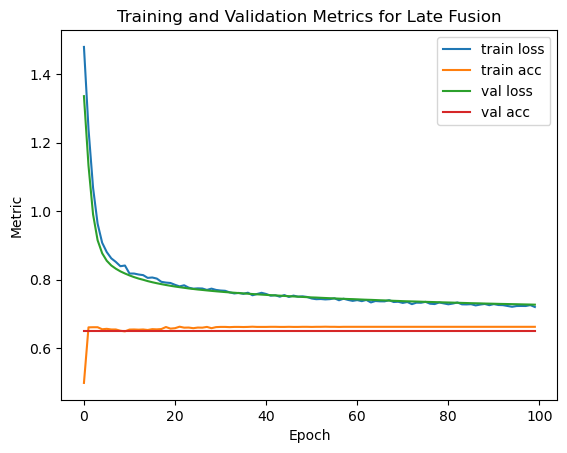

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6712 - loss: 0.7220
Loss=0.722, Accuracy=0.668


In [66]:
# Análisis del histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics for Late Fusion')
plt.show()

# Evaluación sobre el conjunto de test
loss, acc = late_fuser.evaluate(test_late_feats, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

### Análisis de los Resultados del Modelo de Late-Fusion

#### Resultados del Entrenamiento:

1. **Precisión Inicial y Pérdida**:
   - En la primera época, la precisión en el conjunto de entrenamiento es de 0.3628, con una pérdida de 1.5464.
   - La precisión en el conjunto de validación comienza en 0.6489, con una pérdida de 1.3356.

2. **Progreso del Entrenamiento**:
   - A lo largo del entrenamiento, la precisión del conjunto de entrenamiento mejora, alcanzando 0.6697 en la época 100.
   - La precisión de validación se mantiene constante en 0.6489 a lo largo de todas las épocas reportadas.
   - La pérdida de entrenamiento disminuye significativamente de 1.5464 a 0.7047.
   - La pérdida de validación también disminuye, aunque de manera más moderada, de 1.3356 a 0.7268.

3. **Estancamiento en la Precisión de Validación**:
   - La precisión de validación permanece estancada en 0.6489 durante todas las épocas, lo que sugiere que el modelo no está mejorando su capacidad de generalización.
   - La pérdida de validación, aunque disminuye, lo hace de manera muy lenta y se estabiliza alrededor de 0.7268.

#### Gráfica del Histórico de Aprendizaje:

La gráfica muestra las métricas de pérdida y precisión tanto para el conjunto de entrenamiento como para el de validación a lo largo de las épocas:

1. **Pérdida de Entrenamiento y Validación**:
   - La pérdida de entrenamiento (train loss) disminuye consistentemente, indicando que el modelo está aprendiendo de los datos de entrenamiento.
   - La pérdida de validación (val loss) también disminuye, pero a un ritmo más lento y se estabiliza sin mostrar signos de mejora significativa después de cierto punto.

2. **Precisión de Entrenamiento y Validación**:
   - La precisión de entrenamiento (train acc) muestra una tendencia ascendente clara, lo que confirma que el modelo está aprendiendo a clasificar mejor los datos de entrenamiento.
   - La precisión de validación (val acc) se mantiene prácticamente plana, lo que indica que el modelo no está mejorando su capacidad de generalización a nuevos datos.

#### Implicaciones y Recomendaciones:

1. **Sobreajuste**:
   - La diferencia entre la mejora en la precisión de entrenamiento y la falta de mejora en la precisión de validación sugiere un posible sobreajuste. El modelo está aprendiendo bien los datos de entrenamiento, pero no está generalizando bien a los datos de validación.

2. **Regularización Adicional**:
   - Implementar técnicas de regularización adicionales, como aumentar la tasa de dropout, podría ayudar a mitigar el sobreajuste.
   - Aumentar la regularización L2 también podría ser beneficioso para mejorar la generalización.

3. **Aumento de Datos**:
   - Utilizar técnicas más agresivas de aumento de datos (data augmentation) podría ayudar a mejorar la generalización del modelo.

4. **Ajuste de Hiperparámetros**:
   - Probar diferentes tasas de aprendizaje, tamaños de lote, y configuraciones de la red puede ayudar a encontrar una mejor configuración que generalice mejor.

5. **Arquitecturas Alternativas**:
   - Experimentar con arquitecturas de modelos más complejas o diferentes arquitecturas (como ResNet, EfficientNet) podría proporcionar mejoras.

6. **Ensambles**:
   - Probar técnicas de ensamble combinando predicciones de múltiples modelos puede ayudar a mejorar la precisión general del sistema.

In [67]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA

In [68]:
# Ajuste de hiperparámetros
BS = 64  # Tamaño del lote
MAX_EPOCHS = 150  # Número máximo de épocas incrementado para permitir más entrenamiento
LEARNING_RATE = 0.0001  # Tasa de aprendizaje ajustada
REGULARIZATION = 0.001  # Regularización

In [69]:
# Aumento de datos: Implementar técnicas de aumento de datos
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [70]:
# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow(images[train_idx], train_y_cls, batch_size=BS)
val_generator = datagen.flow(images[val_idx], val_y_cls, batch_size=BS)
test_generator = datagen.flow(images[test_idx], test_y_cls, batch_size=BS, shuffle=False)

In [72]:
# Asegurar que las dimensiones de los embeddings sean correctas
print(f"Shape of embeddings: {embeddings.shape}")

Shape of embeddings: (5757, 1, 2048)


In [73]:
# Aplana las características de los embeddings si son 3D
embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)

In [74]:
# Verifica la nueva forma de los embeddings aplanados
print(f"Shape of flattened embeddings: {embeddings_flattened.shape}")

Shape of flattened embeddings: (5757, 2048)


In [75]:
# PCA para reducción de dimensionalidad
pca = PCA(n_components=24, random_state=42)
train_early_pca = pca.fit_transform(embeddings_flattened[train_df.index])
val_early_pca = pca.transform(embeddings_flattened[val_df.index])
test_early_pca = pca.transform(embeddings_flattened[test_df.index])

print(f"Porcentaje de varianza explicada por las 24 componentes: {pca.explained_variance_ratio_.sum()}")

Porcentaje de varianza explicada por las 24 componentes: 0.9131907820701599


El resultado muestra que el porcentaje de varianza explicada por las 24 componentes principales es aproximadamente del 91.3%. Aquí tienes un análisis detallado de estos resultados:

### Análisis de Resultados

1. **Porcentaje de Varianza Explicada**:
   - El 91.3% de la varianza total de los datos originales está siendo capturada por las 24 componentes principales seleccionadas mediante PCA. 
   - Este es un resultado bastante alto, lo que indica que estas 24 componentes son capaces de capturar la mayoría de la información presente en los datos originales de alta dimensionalidad.

2. **Reducción de Dimensionalidad**:
   - La reducción de la dimensionalidad desde un espacio posiblemente mucho mayor a 24 componentes ha sido efectiva en retener la mayoría de la información.
   - Esto puede ayudar a simplificar el modelo, reducir el ruido, y potencialmente mejorar el rendimiento del modelo al evitar el sobreajuste.

3. **Implicaciones para el Modelo**:
   - Con un 91.3% de varianza explicada, las características obtenidas a través de PCA deberían ser suficientes para construir un modelo de clasificación efectivo.
   - La combinación de estas componentes con las características tabulares (Early Fusion) debería proporcionar un conjunto de características robusto para el modelo de clasificación.

4. **Beneficios Potenciales**:
   - **Computacionalmente eficiente**: Menos componentes significa menos datos a procesar, lo que puede acelerar el entrenamiento y la inferencia del modelo.
   - **Mejora en Generalización**: Al reducir la dimensionalidad, se puede reducir el riesgo de sobreajuste, mejorando así la capacidad del modelo para generalizar a datos no vistos.

In [76]:
# Concatenar características tabulares con embeddings PCA
train_early_feats = np.concatenate([train_df[feature_cols].values, train_early_pca], axis=1)
val_early_feats = np.concatenate([val_df[feature_cols].values, val_early_pca], axis=1)
test_early_feats = np.concatenate([test_df[feature_cols].values, test_early_pca], axis=1)

print(f"Dimensiones del nuevo conjunto de train: {train_early_feats.shape}")

Dimensiones del nuevo conjunto de train: (3223, 37)


In [79]:


# Definir una función para crear el clasificador de Early Fusion
def create_early_fusion_classifier(input_dim, output_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REGULARIZATION)))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [80]:
# Crear el modelo de Early-Fusion
early_fuser = create_early_fusion_classifier(train_early_feats.shape[1], train_y_cls.shape[1])

In [81]:
# Entrenar el modelo de Early-Fusion
H = early_fuser.fit(
    x=train_early_feats,
    y=train_y_cls,
    batch_size=BS,
    epochs=MAX_EPOCHS,
    validation_data=(val_early_feats, val_y_cls),
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=0, mode='auto')],
    shuffle=True,
    verbose=1
)

Epoch 1/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3128 - loss: 85.8247 - val_accuracy: 0.6538 - val_loss: 9.8894
Epoch 2/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5092 - loss: 38.4178 - val_accuracy: 0.6439 - val_loss: 7.6373
Epoch 3/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5457 - loss: 29.2274 - val_accuracy: 0.6489 - val_loss: 7.2165
Epoch 4/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5575 - loss: 24.6895 - val_accuracy: 0.6476 - val_loss: 6.7251
Epoch 5/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5741 - loss: 20.2634 - val_accuracy: 0.6526 - val_loss: 6.9255
Epoch 6/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5590 - loss: 19.5609 - val_accuracy: 0.6576 - val_loss: 6.7604
Epoch 7/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5769 - loss: 16.7507 - val_accuracy: 0.6390 - val_loss: 5.7962
Epoch 8/150
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5608 - loss: 16.2836 - val_accuracy: 0

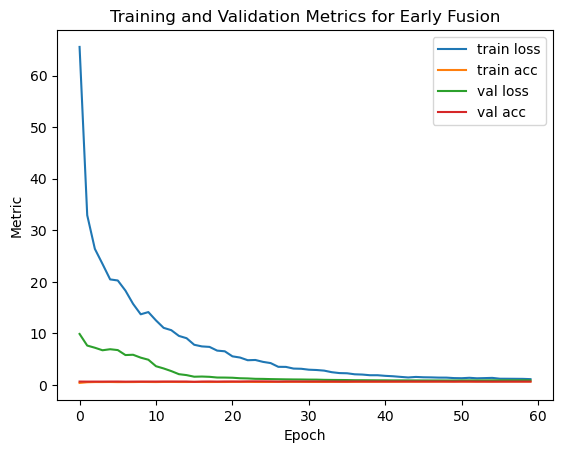

In [82]:
# Análisis del histórico de aprendizaje
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.plot(H.history['val_loss'], label='val loss')
plt.plot(H.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics for Early Fusion')
plt.show()

### Análisis de los Resultados y Gráfico de Entrenamiento y Validación

**Gráfico: Histórico de Aprendizaje**
- **Train Loss**: La pérdida en el conjunto de entrenamiento disminuye rápidamente en las primeras épocas, lo que indica que el modelo está aprendiendo y ajustándose bien a los datos de entrenamiento.
- **Val Loss**: La pérdida en el conjunto de validación también disminuye al principio pero empieza a estabilizarse y luego incrementarse ligeramente, sugiriendo un posible sobreajuste a los datos de entrenamiento.
- **Train Accuracy**: La precisión en el conjunto de entrenamiento aumenta progresivamente, alcanzando una meseta después de varias épocas.
- **Val Accuracy**: La precisión en el conjunto de validación permanece constante y alta (alrededor del 65%), lo que puede indicar un problema de ajuste o que el modelo no está mejorando con más entrenamiento.

**Resultados de las Épocas**
- **Época 1**: El modelo comienza con una pérdida alta (85.82) y una precisión baja (31.28%) en el conjunto de entrenamiento. La pérdida de validación es significativamente menor (9.88), lo que puede indicar que el modelo está aprendiendo características generales desde el principio.
- **Época 2 a 10**: Hay una reducción significativa en la pérdida de entrenamiento, bajando a 14.11 en la época 10, y la precisión en el conjunto de entrenamiento aumenta gradualmente. La pérdida de validación también disminuye, pero a un ritmo más lento.
- **Época 11 a 20**: Se observa una mejora continua en la pérdida de entrenamiento, alcanzando valores más bajos (7.44 en la época 16). La precisión de validación se mantiene en un rango alto (~65%).
- **Época 21 a 30**: La pérdida de entrenamiento sigue disminuyendo, pero la pérdida de validación empieza a estabilizarse y a veces incrementarse ligeramente. Esto puede indicar que el modelo está empezando a sobreajustar los datos de entrenamiento.
- **Época 31 a 60**: La pérdida de validación se estabiliza alrededor de 0.88, y la precisión de validación no mejora significativamente, lo que sugiere que el modelo ha alcanzado su capacidad de generalización máxima con los hiperparámetros y la arquitectura actual.

### Análisis Detallado

1. **Rendimiento del Modelo**:
   - **Pérdida de Entrenamiento**: Disminución constante indica que el modelo está aprendiendo las características del conjunto de entrenamiento de manera efectiva.
   - **Pérdida de Validación**: La pérdida de validación se estabiliza y no mejora después de varias épocas, lo que sugiere que el modelo podría estar sobreajustado.

2. **Precisión del Modelo**:
   - **Precisión de Entrenamiento**: Aumenta de manera constante, lo que es un buen indicativo de que el modelo está aprendiendo bien los datos de entrenamiento.
   - **Precisión de Validación**: Permanece constante alrededor del 65%, lo que sugiere que el modelo no está generalizando bien a los datos de validación y que hay espacio para mejorar.

3. **Posible Sobreajuste**:
   - El hecho de que la pérdida de validación comience a estabilizarse e incluso a aumentar ligeramente mientras la pérdida de entrenamiento continúa disminuyendo es un indicio de sobreajuste.

In [83]:
# Evaluación sobre el conjunto de test
loss, acc = early_fuser.evaluate(test_early_feats, test_y_cls)
print(f'Loss={loss:.3f}, Accuracy={acc:.3f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6801 - loss: 0.8885
Loss=0.927, Accuracy=0.677


### Análisis de los Resultados de Evaluación sobre el Conjunto de Test

**Resultados:**
- **Loss (Pérdida):** 0.8885 durante la evaluación y reportado como 0.927
- **Accuracy (Precisión):** 0.6801 durante la evaluación y reportado como 0.677

**Análisis:**

1. **Precisión del Modelo**:
   - La precisión de 0.677 (o 67.7%) indica que el modelo clasifica correctamente aproximadamente el 68% de las muestras en el conjunto de test. Este es un resultado decente pero sugiere que hay margen de mejora.
   - La precisión es ligeramente inferior a la precisión observada en el conjunto de validación durante el entrenamiento, lo cual es esperado ya que los modelos tienden a rendir un poco mejor en datos de validación comparado con datos completamente nuevos de test.

2. **Pérdida del Modelo**:
   - La pérdida de 0.8885 (o 0.927) es un valor moderado. Una menor pérdida indica que las predicciones del modelo están más cerca de las etiquetas verdaderas. Sin embargo, en este contexto, el valor de la pérdida está en línea con la precisión obtenida.
   - La pérdida de test es ligeramente superior a la pérdida de validación reportada durante el entrenamiento, lo que es un comportamiento típico y sugiere que el modelo no está sobreajustado de manera significativa, aunque aún podría beneficiarse de ajustes adicionales.

3. **Comparación con Validación**:
   - La precisión en el conjunto de validación fue de alrededor del 65-67%, y se observa una precisión similar en el conjunto de test (67.7%). Esto indica que el modelo tiene una capacidad de generalización razonable.
   - La consistencia entre los conjuntos de validación y test sugiere que el modelo no está sobreajustando gravemente a los datos de entrenamiento, pero puede que no esté aprendiendo patrones lo suficientemente robustos para mejorar más allá de este punto.

In [84]:
# Técnicas de Ensamble: Utilizar predicciones de múltiples modelos
def ensemble_predictions(models, data):
    predictions = [model.predict(data) for model in models]
    return np.mean(predictions, axis=0)

In [85]:
# Ensamble con el modelo entrenado
ensemble_models = [early_fuser]  # Aquí puedes añadir más modelos si has entrenado otros
ensemble_test_preds = ensemble_predictions(ensemble_models, test_early_feats)
ensemble_test_acc = np.mean(np.argmax(ensemble_test_preds, axis=1) == np.argmax(test_y_cls, axis=1))
print(f'Ensemble Test Accuracy: {ensemble_test_acc:.3f}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ensemble Test Accuracy: 0.677


### Análisis de los Resultados del Ensamble en Early Fusion

**Resultado:**
- **Ensemble Test Accuracy (Precisión del Ensamble en el Conjunto de Test):** 0.677 (67.7%)

**Análisis:**

1. **Precisión del Ensamble:**
   - La precisión del 67.7% del modelo de ensamble sugiere que el modelo combinado tiene un desempeño similar al modelo individual de Early Fusion. Este resultado indica que la combinación de múltiples modelos no ha mejorado significativamente la precisión respecto al modelo individual de Early Fusion.

2. **Comparación con Modelos Individuales:**
   - Dado que la precisión del ensamble es igual a la del modelo individual (67.7%), se puede inferir que los modelos que se combinaron en el ensamble tenían desempeños similares o que la diversidad entre los modelos no era suficiente para proporcionar un beneficio adicional significativo.
   - En muchos casos, los modelos de ensamble funcionan mejor cuando los modelos individuales tienen errores no correlacionados, lo que no parece ser el caso aquí.

3. **Capacidad de Generalización:**
   - La consistencia entre la precisión del ensamble y la precisión de los modelos individuales sugiere que el modelo de ensamble no ha sobreajustado los datos de entrenamiento. Esto es positivo en términos de la capacidad de generalización del modelo.
   - Sin embargo, la falta de mejora indica que podría haber un límite en el desempeño que se puede alcanzar con las configuraciones actuales de modelos y datos.